<a href="https://colab.research.google.com/github/Ayazdani1997/stock-feature-prediction-final-pro/blob/master/Phase1_OCHLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas
!pip install tensorflow
!pip install tensorflow-gpu

In [2]:
pip install --upgrade tensorflow-gpu

Requirement already up-to-date: tensorflow-gpu in ./venv/lib/python3.6/site-packages (2.2.0)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives
from tensorflow.keras import optimizers


import pandas
import matplotlib.pyplot as plt
# from google.colab import drive
from os.path import join
import numpy

ROOT = '/content/drive'

In [3]:
# drive.mount(ROOT)
# HOME = join(ROOT,'My Drive')
# print('enter the environment directory')
# directory = input()
COLAB_DIR = '.'
data = pandas.read_csv(join(COLAB_DIR, 'data.csv'), encoding='utf-16')

In [4]:
data = data.drop(['Unnamed: 0', 'VAL', 'NUM_OF_TRANSACTIONS','CLOSE_ONE_DAY_BEFORE'], axis=1).rename(columns={'DTYYYYMMDD': 'DATE'})
data['DATE'] = pandas.to_datetime(data['DATE'],format='%Y%m%d')

In [5]:
labels = pandas.DataFrame()
labels['CLASS'] = numpy.where(data['CLOSE'] > data['CLOSE'].shift(1), 1.0, 0.0)
labels['DATE'] = data['DATE'].copy()
labels['TICKER'] = data['TICKER'].copy()
labels.head(10)

CLASS       DATE TICKER
0    0.0 2019-11-20   مظنه
1    0.0 2019-11-23   مظنه
2    0.0 2019-11-24   مظنه
3    0.0 2019-11-25   مظنه
4    0.0 2019-11-26   مظنه
5    0.0 2019-11-27   مظنه
6    0.0 2019-11-30   مظنه
7    0.0 2019-12-01   مظنه
8    0.0 2019-12-02   مظنه
9    0.0 2019-12-03   مظنه

Let's assert if we are using GPU.

In [6]:
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
physical_devices = tensorflow.config.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [8]:
import matplotlib.dates as mdates

def draw_ochlv(data_related_to_stock, from_date, to_date):
    fig, axs = plt.subplots(3, 2, sharex=True, figsize=(10,10))
    fig.tight_layout()

    
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    years_fmt = mdates.DateFormatter('%Y')

    axs[0][0].xaxis.set_major_locator(years)
    axs[0][0].xaxis.set_major_formatter(years_fmt)
    axs[0][0].xaxis.set_minor_locator(months)

    mask = (data_related_to_stock['DATE'] >= from_date) & (data_related_to_stock['DATE'] <= to_date ) 
    period = data_related_to_stock.loc[mask]
    
    starting_date = str(from_date)
    ending_date = str(to_date)

    axs[0][0].plot(period['DATE'], period['CLOSE'])
    axs[0][0].set(ylabel='closing price (in tomans)')
    axs[0][0].set_title('closing price')
    
    axs[1][0].plot(period['DATE'], period['OPEN'])
    axs[1][0].set(ylabel='opening price (in tomans)')
    axs[1][0].set_title('opening price')
                     
    
    axs[0][1].plot(period['DATE'], period['VOL'])
    axs[0][1].set(ylabel='daily volume traded (in share)')
    axs[0][1].set_title('daily volume')
                     
    
    axs[1][1].plot(period['DATE'], period['HIGH'])
    axs[1][1].set(ylabel='high price (in tomans)')
    axs[1][1].set_title('high price')
                     
    axs[2][0].plot(period['DATE'], period['LOW'])
    axs[2][0].set(ylabel='low price (in tomans)')
    axs[2][0].set_title('low price')

    axs[0][0].grid(True)
    axs[0][1].grid(True)
    axs[1][0].grid(True)
    axs[1][1].grid(True)
    axs[2][0].grid(True)

    axs[0][0].format_xdata = mdates.DateFormatter('%Y-%m-%d')

    plt.show()

In [9]:
ten_stocks_with_max_trading_days = data.groupby('TICKER').agg({'DATE': ['min', 'max', 'count'], 'VOL': ['mean']}).reset_index().sort_values(('DATE', 'count'), ascending=False).head(10)
stock_with_max_trading_days = ten_stocks_with_max_trading_days['TICKER'].iloc[0]
ten_stocks_with_max_trading_days.head(10)

TICKER       DATE                            VOL
                   min        max count          mean
1616  وپترو 2001-03-25 2020-04-13  4366  2.323352e+06
1522  وساخت 2001-03-25 2020-04-13  4356  1.464725e+06
56    آريان 2010-10-06 2020-04-13  4347  2.723661e+06
624   خودرو 2001-03-25 2020-04-13  4340  1.123416e+07
1539   وسپه 2001-03-27 2020-04-13  4323  2.620691e+06
753   زنجان 2011-01-05 2020-04-13  4318  9.637195e+05
567   خبهمن 2001-04-07 2020-04-13  4315  6.061205e+06
1603  ونيكي 2001-04-07 2020-04-13  4302  1.712802e+06
900   شاراك 2001-03-27 2020-04-13  4298  2.342162e+06
1474  وبشهر 2001-03-25 2020-04-13  4291  2.265908e+06

## **Stateful LSTM**

In this section, we train our model on the stock with max trading days. first of all, let's visualize the whole market to investigate the oscilations of price.

In [10]:
start_period = pandas.to_datetime('20010101', format='%Y%m%d', errors='ignore')
end_period = pandas.to_datetime('20200414', format='%Y%m%d', errors='ignore')

In [10]:
data_related_to_max_stock = data[ data['TICKER'] == stock_with_max_trading_days ]

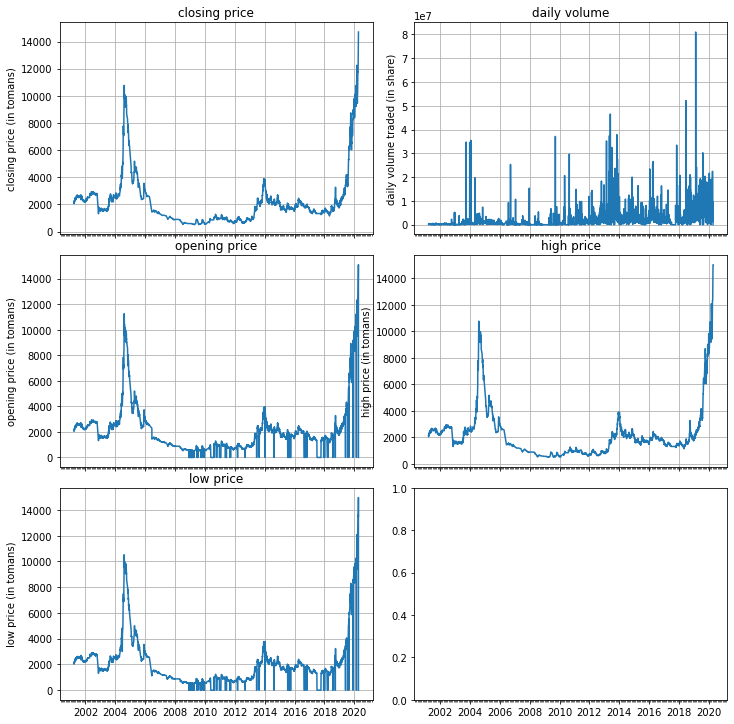

In [15]:
draw_ochlv(data_related_to_max_stock, start_period, end_period)

In [11]:

class MyNormalizer:
  def __init__(self):
    self.max = 0
    self.min = 0

  def fit(self, data):
    self.max = data.max()
    self.min = data.min()
  
  def transform(self, data):
    return (data - self.min) / (self.max - self.min)


def align_data(x, y, window_in_days, batch_size):
  rows_to_insert_to_x = pandas.DataFrame(numpy.zeros((window_in_days+(batch_size - len(x) % batch_size),\
                                                      len(x.columns))), columns=x.columns)
  rows_to_insert_to_y = pandas.DataFrame(numpy.zeros(\
                                                     (window_in_days+(batch_size - len(x) % batch_size), \
                                                      len(y.columns))), columns=y.columns)

  return pandas.concat([rows_to_insert_to_x, x], ignore_index=True), \
        pandas.concat([rows_to_insert_to_y, y], ignore_index=True)
  

def split_data_to_train_test(original_dataset, labels, stock, \
                             training_start, training_end, testing_start, testing_end, \
                             test_required=True, drop_date=True):
  data_related_to_stock = original_dataset[ original_dataset['TICKER'] == stock ].drop('TICKER', axis=1)
  labels_related_to_stock = labels[ labels['TICKER'] == stock ].drop('TICKER', axis=1)

 
  training_period_mask = (data_related_to_stock['DATE'] >= training_start) \
    & (data_related_to_stock['DATE'] <= training_end ) 
  training_period = data_related_to_stock.loc[training_period_mask]
  if drop_date:
        training_period = training_period.drop('DATE', axis=1)
  training_period_labels = labels_related_to_stock.loc[training_period_mask]
  if drop_date:
        training_period_labels = training_period_labels.drop('DATE', axis=1)

  testing_period = None
  testing_period_labels = None
  if test_required:
    testing_period_mask = (data_related_to_stock['DATE'] >= testing_start) \
        & (data_related_to_stock['DATE'] <= testing_end )
    testing_period = data_related_to_stock.loc[testing_period_mask]
    if drop_date:
        testing_period = testing_period.drop('DATE', axis=1)
    testing_period_labels = labels_related_to_stock.loc[testing_period_mask]
    if drop_date:
        testing_period_labels = testing_period_labels.drop('DATE', axis=1)

  return training_period, training_period_labels , testing_period, testing_period_labels


def normalize_dataframe_with_max_min(dataframe, train_max, train_min):
    normalized_df=(dataframe - train_min)/(train_max - train_min)
    return normalized_df



In [12]:
training_start = pandas.to_datetime('20080101', format='%Y%m%d', errors='ignore')
training_end = pandas.to_datetime('20170919', format='%Y%m%d', errors='ignore')
testing_start = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')
testing_end = pandas.to_datetime('20180719', format='%Y%m%d', errors='ignore')

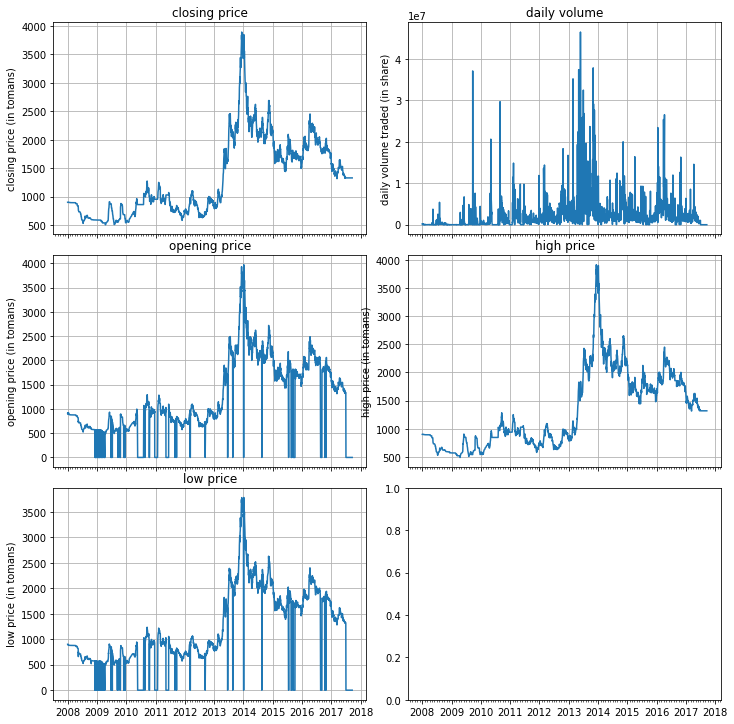

In [12]:
draw_ochlv(data_related_to_max_stock, training_start, training_end)

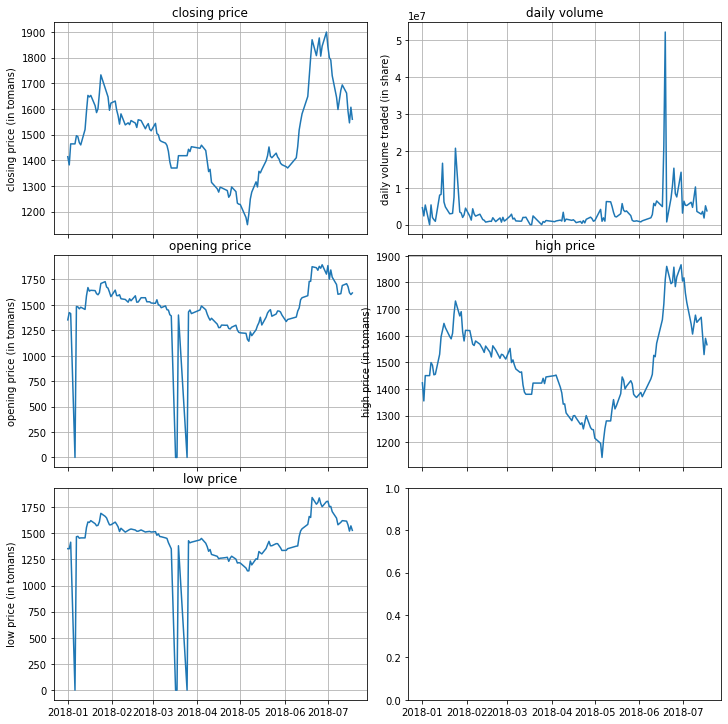

In [13]:
data_related_to_max_stock = data[ data['TICKER'] == stock_with_max_trading_days ]
draw_ochlv(data_related_to_max_stock, testing_start, testing_end)

Now, let's apply alignment and normalization on both sets and see the range of data. The batch size is 32 and window length is 10.

In [14]:
normalizer = MyNormalizer()

training_period, training_labels, testing_period, testing_labels \
    = split_data_to_train_test(data, labels, \
                               stock_with_max_trading_days, training_start, training_end \
                                , testing_start, testing_end, True, False)

training_period, _ = align_data(training_period, \
                                                       training_labels, 10, 32)

testing_period, _ = align_data(testing_period, \
                                                       testing_labels, 10, 32)
training_date = training_period['DATE']
testing_date = testing_period['DATE']

_training_period = training_period.drop('DATE', axis=1)
_testing_period = testing_period.drop('DATE', axis=1)

normalizer.fit(_training_period)
_training_period = normalizer.transform(_training_period)
_testing_period = normalizer.transform(_testing_period)
_training_period['DATE'] = training_date.reset_index(drop=True).replace(0, numpy.nan)
_testing_period['DATE'] = testing_date.reset_index(drop=True).replace(0, numpy.nan)

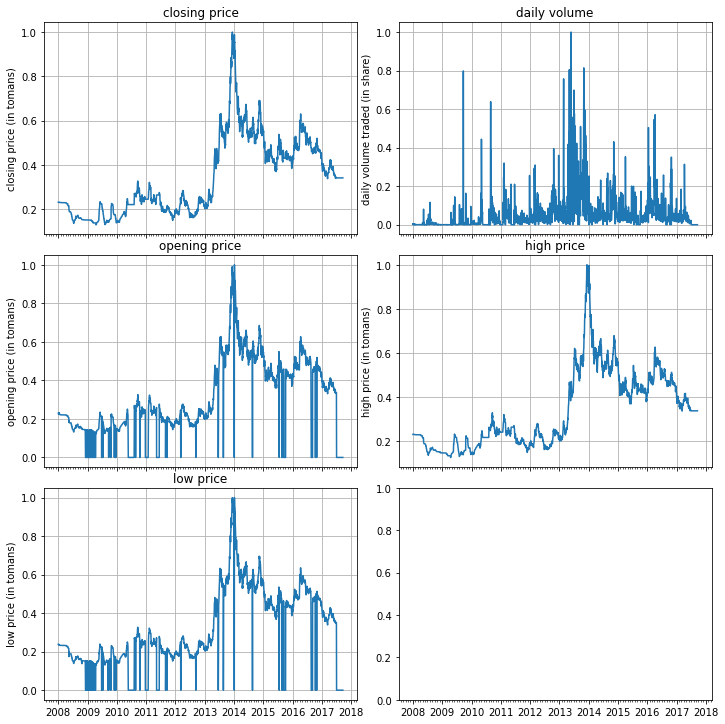

In [15]:
draw_ochlv(_training_period, training_start, training_end)

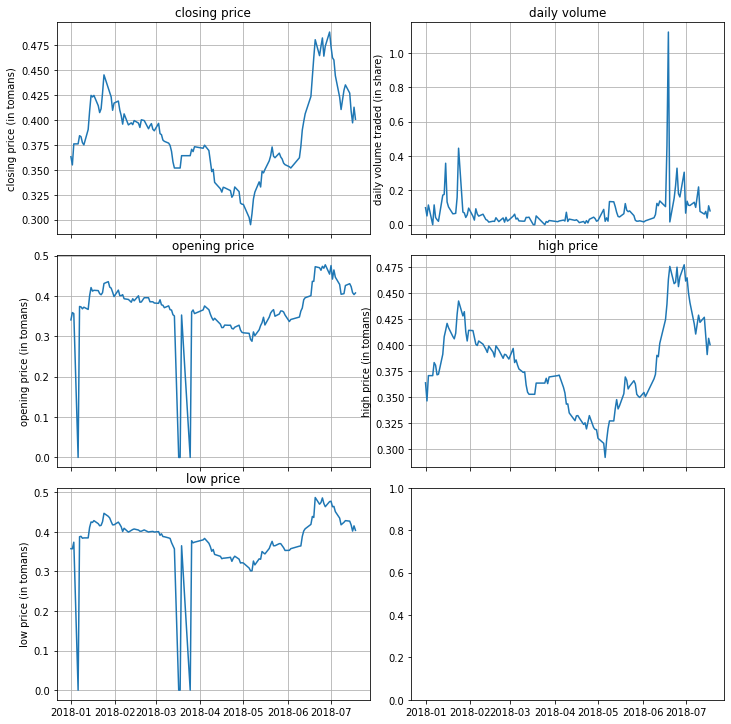

In [16]:
draw_ochlv(_testing_period, testing_start, testing_end)

Next, let's apply alignment and normalization on both sets and see the range of data. The batch size is 32 and window length is 20.

In [17]:
normalizer = MyNormalizer()

training_period, training_labels, testing_period, testing_labels \
    = split_data_to_train_test(data, labels, \
                               stock_with_max_trading_days, training_start, training_end \
                                , testing_start, testing_end, True, False)

training_period, _ = align_data(training_period, \
                                                       training_labels, 20, 32)

testing_period, _ = align_data(testing_period, \
                                                       testing_labels, 20, 32)
training_date = training_period['DATE']
testing_date = testing_period['DATE']

_training_period = training_period.drop('DATE', axis=1)
_testing_period = testing_period.drop('DATE', axis=1)

normalizer.fit(_training_period)
_training_period = normalizer.transform(_training_period)
_testing_period = normalizer.transform(_testing_period)
_training_period['DATE'] = training_date.reset_index(drop=True).replace(0, numpy.nan)
_testing_period['DATE'] = testing_date.reset_index(drop=True).replace(0, numpy.nan)

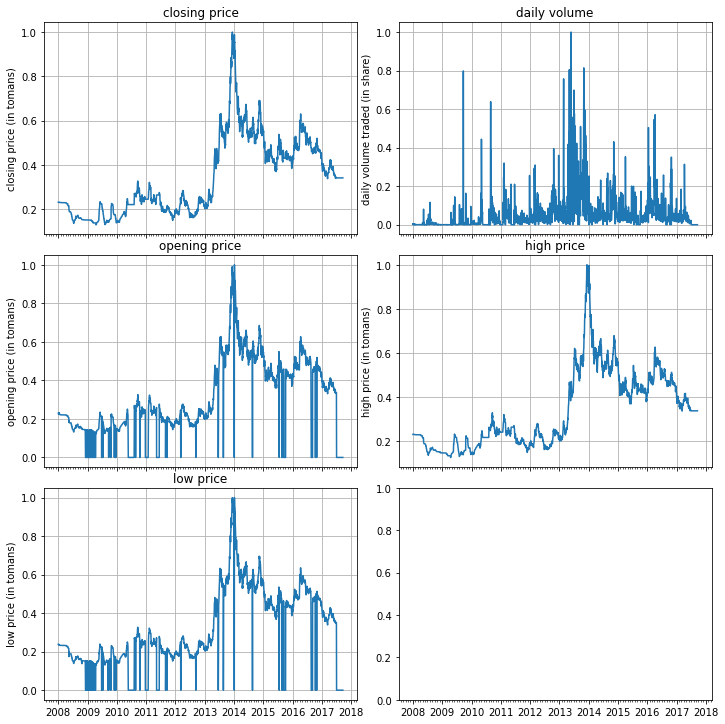

In [18]:
draw_ochlv(_training_period, training_start, training_end)

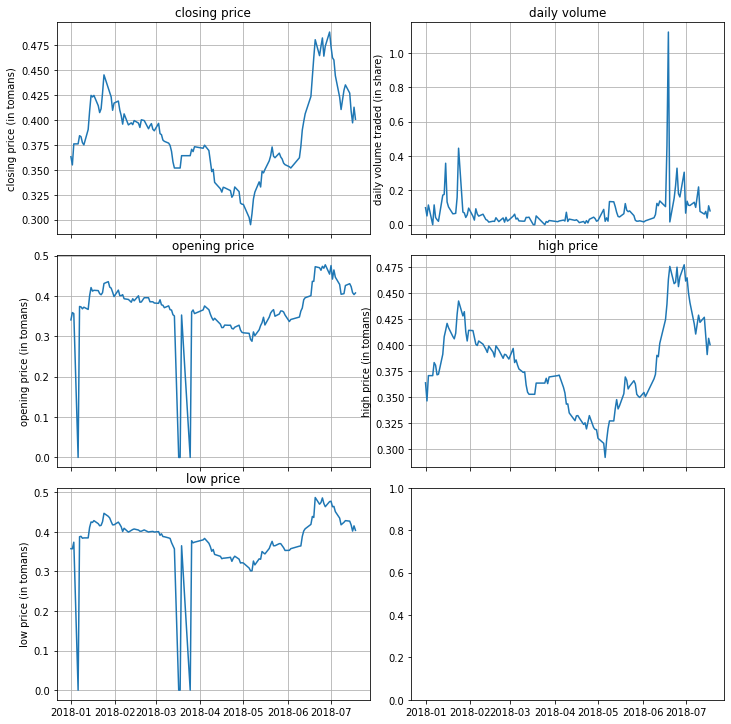

In [19]:
draw_ochlv(_testing_period, testing_start, testing_end)

Next, let's apply alignment and normalization on both sets and see the range of data. The batch size is 32 and window length is 30.

In [20]:
normalizer = MyNormalizer()

training_period, training_labels, testing_period, testing_labels \
    = split_data_to_train_test(data, labels, \
                               stock_with_max_trading_days, training_start, training_end \
                                , testing_start, testing_end, True, False)

training_period, _ = align_data(training_period, \
                                                       training_labels, 30, 32)

testing_period, _ = align_data(testing_period, \
                                                       testing_labels, 30, 32)
training_date = training_period['DATE']
testing_date = testing_period['DATE']

_training_period = training_period.drop('DATE', axis=1)
_testing_period = testing_period.drop('DATE', axis=1)

normalizer.fit(_training_period)
_training_period = normalizer.transform(_training_period)
_testing_period = normalizer.transform(_testing_period)
_training_period['DATE'] = training_date.reset_index(drop=True).replace(0, numpy.nan)
_testing_period['DATE'] = testing_date.reset_index(drop=True).replace(0, numpy.nan)

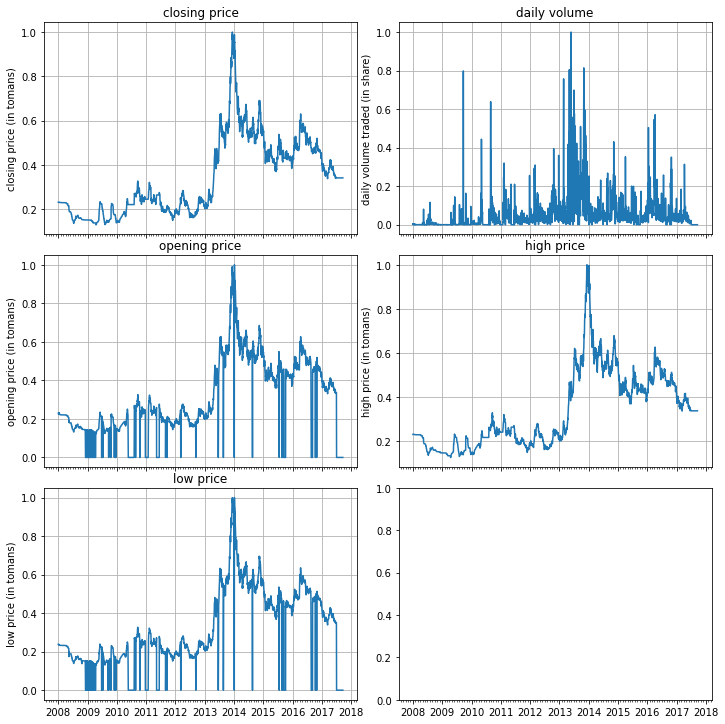

In [21]:
draw_ochlv(_training_period, training_start, training_end)

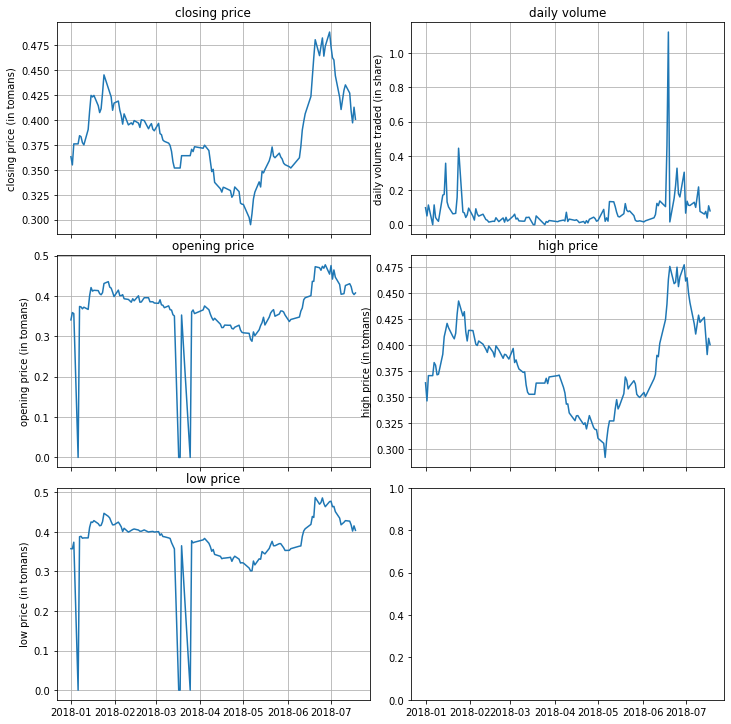

In [22]:
draw_ochlv(_testing_period, testing_start, testing_end)

So, the normalization is really suitable for this dataset.

**Now it is time to start training our model**

We use adam optimizer throughout this experiment and train the models for 5000 epochs.

In [14]:
epochs = 5000

In [13]:
optimizer = optimizers.Adam(learning_rate=0.001)

In [14]:
def generate_datasets_for_model(original_dataset, labels, stock, training_start, training_end, \
                                testing_start, testing_end, window_in_days=10, batch_size=32, test_required=True):
  normalizer = MyNormalizer()
  training_data = []
  training_labels = []
  testing_data = []
  testing_labels = []

  training_period, training_period_labels, testing_period, testing_period_labels \
    = split_data_to_train_test(original_dataset, labels, stock, training_start, training_end \
                                , testing_start, testing_end, test_required, True)


  training_period, training_period_labels = align_data(training_period, \
                                                       training_period_labels, window_in_days, batch_size)

  if test_required:
    testing_period, testing_period_labels = align_data(testing_period, \
                                                       testing_period_labels, window_in_days, batch_size)                                                                                               

  normalizer.fit(training_period)
  training_period = normalizer.transform(training_period)

  for j in range(window_in_days, len(training_period)):
    training_data.append(numpy.array(training_period[ j - window_in_days : j ].copy()))
    training_labels.append(numpy.array(training_period_labels.iloc[j]))

  training_data = numpy.array(training_data)
  training_labels = numpy.array(training_labels)

  if test_required:
    testing_period = normalizer.transform(testing_period)
    for j in range(window_in_days, len(testing_period)):
      testing_data.append(numpy.array(testing_period[ j - window_in_days : j ].copy()))
      testing_labels.append(numpy.array(testing_period_labels.iloc[j]))

  testing_data = numpy.array(testing_data)
  testing_labels = numpy.array(testing_labels)

  train_generator = DataGenerator(training_data, training_labels, batch_size=batch_size)
  test_generator = DataGenerator(testing_data, testing_labels, batch_size=batch_size)

  return train_generator, test_generator



In [15]:
class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, labels, batch_size=32):
        'Initialization'
        self.data = data
        self.dim = data.shape
        self.batch_size = batch_size
        self.labels = labels
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(numpy.floor(self.dim[0] / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        
        x = self.data[index * self.batch_size: (index + 1) * self.batch_size]

        y = self.labels[index * self.batch_size: (index + 1) * self.batch_size]
        
        return x, y

    def on_epoch_end(self):
        pass

In [16]:

def build_model(input_shape, optimizer='adam', layers=None, loss='binary_crossentropy', metrics=[BinaryAccuracy(name='accuracy')]):
  if layers is None:
    model = Sequential()
    model.add(LSTM(64, input_shape=(input_shape[1], input_shape[2])))
    model.add(Dense(32))
    model.add(Dropout(0.1))
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Dense(4))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

  else:
    model = Sequential(layers)
  
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)


  return model


In [17]:
from tensorflow.keras.callbacks import ProgbarLogger
from tensorflow.keras.callbacks import Callback
from datetime import datetime

class MyLogger(Callback):
    def __init__(self, verbose, count_mode='samples'):
        # Ignore the `verbose` argument specified in `fit()` and pass `count_mode` upstream
        self.verbose = verbose
        self.metrics = ['loss', 'accuracy']
        self.epoch_start = 0
        self.epoch_finish = 0

    def on_train_begin(self, logs=None):
        pass

    def on_epoch_begin(self, epoch, logs=None):
        self.params['metrics'] = self.metrics
        self.epochs = self.params['epochs']
        if self.verbose:
            print('----------->> Epoch %d/%d' % (epoch + 1, self.epochs), end='   ')
        self.epoch_start = datetime.now()

    def on_batch_begin(self, batch, logs=None):
        pass

    def on_batch_end(self, batch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_finish = datetime.now()
        duration = (self.epoch_finish - self.epoch_start).total_seconds()
        print('%.3f seconds' % (duration), end=' , ')
        self.log_values = []
        logs = logs or {}
        for k in self.params['metrics']:
            if k in logs:
                self.log_values.append((k, logs[k]))
        if self.verbose:
            for metric, value in self.log_values:
              print('%s : %.3f' % ( metric, value), end='    ')
        print()
    
    def on_train_end(self, logs=None):
        pass


In [18]:
# results is in form of [loss, acc, true positives, false positives, true negatives, false negatives]
def calc_pos_neg_rate(results):
  new_results = {}
  new_results['loss'] = results[0] # loss
  new_results['acc'] = results[1] # accuracy
  new_results['true_positive_rate'] = (results[2]) / (results[2] + results[5]) # true positive rate
  new_results['false_positive_rate'] = (results[3]) / (results[3] + results[4]) # false positive rate
  new_results['positive_precision'] = (results[2]) / (results[2] + results[3]) # positive precision
  new_results['negative_precision'] = (results[4]) / (results[4] + results[5]) # negative precision
  return new_results

In [19]:
def tabular_test_train_results(train_generator, test_generator, train_results, test_results, batch_size=32):
    rows = ['train', 'test']
    columns = [metric for metric in test_results]
    columns.append('set_size')
    table_data = [ [str(train_results[metric]) for metric in train_results],\
            [str(test_results[metric]) for metric in test_results]]
    table_data[0].append(len(train_generator) * batch_size)
    table_data[1].append(len(test_generator) * batch_size)
    table = plt.table(cellText=table_data,
                      rowLabels=rows,
                      colLabels=columns,
                      cellLoc='center',
                      loc='center',
                      rowLoc='center',
                      )
    plt.axis('off')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(2, 8)
    plt.show()

In [20]:
def fit(model, epochs, train_generator):
  train_losses = []

  train_accs = []

  for i in range(epochs):
      print('epoch %d' % (i + 1))
      history = model.fit(x=train_generator,
                        epochs=1,
                        verbose=0,
                        callbacks=[MyLogger(1)]
                        )
      train_accs.append(history.history['accuracy'])
      train_losses.append(history.history['loss'])
      model.reset_states() 
  return train_accs, train_losses

Now, we want to train the model using different window sizes to see the effect on the performance of the model. Throughout the document, we also report true positive rate, false positive rate, positive precision and negative precision.

Let's start with window size of 10.

In [28]:
train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_max_trading_days, \
                                                              training_start, training_end, testing_start, \
                                                              testing_end)

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
first_model = build_model(None, optimizer, layers, metrics=metrics)
first_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (32, 64)                  17920     
_________________________________________________________________
dense_4 (Dense)              (32, 32)                  2080      
_________________________________________________________________
dropout_1 (Dropout)          (32, 32)                  0         
_________________________________________________________________
dense_5 (Dense)              (32, 16)                  528       
_________________________________________________________________
batch_normalization_1 (Batch (32, 16)                  64        
_________________________________________________________________
dense_6 (Dense)              (32, 4)                   68        
_________________________________________________________________
dense_7 (Dense)              (32, 1)                  

First of all, let's compute all the metrics with a non-trained model.

In [29]:
first_model.reset_states()
test_results = calc_pos_neg_rate(first_model.evaluate(x=test_generator, verbose=0))

In [30]:
first_model.reset_states()
train_results = calc_pos_neg_rate(first_model.evaluate(x=train_generator, verbose=0))

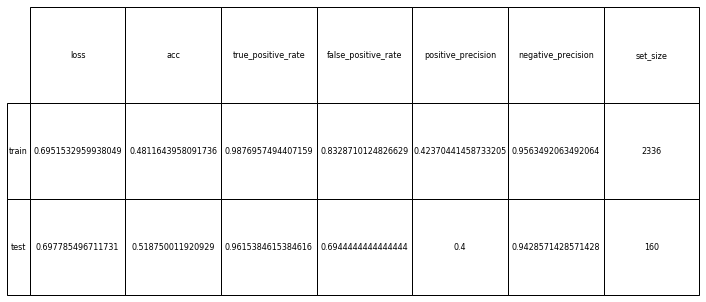

In [31]:
tabular_test_train_results(train_generator, test_generator, train_results, test_results)

Now, let's train this model.

In [100]:
train_accs, train_losses = fit(first_model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   1.738 seconds , loss : 0.705    accuracy : 0.528    
epoch 2
----------->> Epoch 1/1   0.265 seconds , loss : 0.675    accuracy : 0.576    
epoch 3
----------->> Epoch 1/1   0.229 seconds , loss : 0.664    accuracy : 0.604    
epoch 4
----------->> Epoch 1/1   0.234 seconds , loss : 0.659    accuracy : 0.604    
epoch 5
----------->> Epoch 1/1   0.233 seconds , loss : 0.656    accuracy : 0.619    
epoch 6
----------->> Epoch 1/1   0.257 seconds , loss : 0.655    accuracy : 0.618    
epoch 7
----------->> Epoch 1/1   0.239 seconds , loss : 0.649    accuracy : 0.635    
epoch 8
----------->> Epoch 1/1   0.296 seconds , loss : 0.649    accuracy : 0.607    
epoch 9
----------->> Epoch 1/1   0.308 seconds , loss : 0.650    accuracy : 0.619    
epoch 10
----------->> Epoch 1/1   0.244 seconds , loss : 0.647    accuracy : 0.617    
epoch 11
----------->> Epoch 1/1   0.248 seconds , loss : 0.648    accuracy : 0.619    
epoch 12
----------->> Epoch 1/1   0.244 

----------->> Epoch 1/1   0.253 seconds , loss : 0.522    accuracy : 0.761    
epoch 187
----------->> Epoch 1/1   0.360 seconds , loss : 0.519    accuracy : 0.761    
epoch 188
----------->> Epoch 1/1   0.295 seconds , loss : 0.517    accuracy : 0.762    
epoch 189
----------->> Epoch 1/1   0.258 seconds , loss : 0.515    accuracy : 0.751    
epoch 190
----------->> Epoch 1/1   0.268 seconds , loss : 0.524    accuracy : 0.756    
epoch 191
----------->> Epoch 1/1   0.266 seconds , loss : 0.517    accuracy : 0.763    
epoch 192
----------->> Epoch 1/1   0.271 seconds , loss : 0.511    accuracy : 0.763    
epoch 193
----------->> Epoch 1/1   0.273 seconds , loss : 0.518    accuracy : 0.762    
epoch 194
----------->> Epoch 1/1   0.264 seconds , loss : 0.518    accuracy : 0.762    
epoch 195
----------->> Epoch 1/1   0.289 seconds , loss : 0.511    accuracy : 0.762    
epoch 196
----------->> Epoch 1/1   0.255 seconds , loss : 0.515    accuracy : 0.757    
epoch 197
----------->> Epoch 1

----------->> Epoch 1/1   0.241 seconds , loss : 0.460    accuracy : 0.791    
epoch 371
----------->> Epoch 1/1   0.292 seconds , loss : 0.458    accuracy : 0.797    
epoch 372
----------->> Epoch 1/1   0.251 seconds , loss : 0.457    accuracy : 0.796    
epoch 373
----------->> Epoch 1/1   0.300 seconds , loss : 0.458    accuracy : 0.786    
epoch 374
----------->> Epoch 1/1   0.246 seconds , loss : 0.457    accuracy : 0.796    
epoch 375
----------->> Epoch 1/1   0.243 seconds , loss : 0.458    accuracy : 0.785    
epoch 376
----------->> Epoch 1/1   0.240 seconds , loss : 0.463    accuracy : 0.792    
epoch 377
----------->> Epoch 1/1   0.285 seconds , loss : 0.459    accuracy : 0.785    
epoch 378
----------->> Epoch 1/1   0.284 seconds , loss : 0.459    accuracy : 0.797    
epoch 379
----------->> Epoch 1/1   0.270 seconds , loss : 0.466    accuracy : 0.782    
epoch 380
----------->> Epoch 1/1   0.287 seconds , loss : 0.454    accuracy : 0.799    
epoch 381
----------->> Epoch 1

----------->> Epoch 1/1   0.296 seconds , loss : 0.373    accuracy : 0.848    
epoch 555
----------->> Epoch 1/1   0.274 seconds , loss : 0.384    accuracy : 0.842    
epoch 556
----------->> Epoch 1/1   0.270 seconds , loss : 0.386    accuracy : 0.842    
epoch 557
----------->> Epoch 1/1   0.256 seconds , loss : 0.378    accuracy : 0.838    
epoch 558
----------->> Epoch 1/1   0.287 seconds , loss : 0.380    accuracy : 0.841    
epoch 559
----------->> Epoch 1/1   0.292 seconds , loss : 0.373    accuracy : 0.841    
epoch 560
----------->> Epoch 1/1   0.285 seconds , loss : 0.389    accuracy : 0.842    
epoch 561
----------->> Epoch 1/1   0.297 seconds , loss : 0.391    accuracy : 0.836    
epoch 562
----------->> Epoch 1/1   0.307 seconds , loss : 0.384    accuracy : 0.834    
epoch 563
----------->> Epoch 1/1   0.328 seconds , loss : 0.383    accuracy : 0.839    
epoch 564
----------->> Epoch 1/1   0.269 seconds , loss : 0.378    accuracy : 0.842    
epoch 565
----------->> Epoch 1

----------->> Epoch 1/1   0.291 seconds , loss : 0.302    accuracy : 0.872    
epoch 739
----------->> Epoch 1/1   0.249 seconds , loss : 0.312    accuracy : 0.878    
epoch 740
----------->> Epoch 1/1   0.238 seconds , loss : 0.320    accuracy : 0.872    
epoch 741
----------->> Epoch 1/1   0.237 seconds , loss : 0.322    accuracy : 0.881    
epoch 742
----------->> Epoch 1/1   0.239 seconds , loss : 0.309    accuracy : 0.876    
epoch 743
----------->> Epoch 1/1   0.237 seconds , loss : 0.302    accuracy : 0.877    
epoch 744
----------->> Epoch 1/1   0.237 seconds , loss : 0.310    accuracy : 0.874    
epoch 745
----------->> Epoch 1/1   0.236 seconds , loss : 0.295    accuracy : 0.881    
epoch 746
----------->> Epoch 1/1   0.238 seconds , loss : 0.302    accuracy : 0.876    
epoch 747
----------->> Epoch 1/1   0.238 seconds , loss : 0.309    accuracy : 0.873    
epoch 748
----------->> Epoch 1/1   0.235 seconds , loss : 0.303    accuracy : 0.884    
epoch 749
----------->> Epoch 1

----------->> Epoch 1/1   0.309 seconds , loss : 0.258    accuracy : 0.902    
epoch 923
----------->> Epoch 1/1   0.295 seconds , loss : 0.241    accuracy : 0.911    
epoch 924
----------->> Epoch 1/1   0.277 seconds , loss : 0.235    accuracy : 0.908    
epoch 925
----------->> Epoch 1/1   0.251 seconds , loss : 0.240    accuracy : 0.910    
epoch 926
----------->> Epoch 1/1   0.257 seconds , loss : 0.238    accuracy : 0.909    
epoch 927
----------->> Epoch 1/1   0.273 seconds , loss : 0.235    accuracy : 0.909    
epoch 928
----------->> Epoch 1/1   0.275 seconds , loss : 0.244    accuracy : 0.904    
epoch 929
----------->> Epoch 1/1   0.293 seconds , loss : 0.243    accuracy : 0.909    
epoch 930
----------->> Epoch 1/1   0.258 seconds , loss : 0.256    accuracy : 0.904    
epoch 931
----------->> Epoch 1/1   0.280 seconds , loss : 0.236    accuracy : 0.909    
epoch 932
----------->> Epoch 1/1   0.281 seconds , loss : 0.232    accuracy : 0.916    
epoch 933
----------->> Epoch 1

----------->> Epoch 1/1   0.264 seconds , loss : 0.217    accuracy : 0.920    
epoch 1015
----------->> Epoch 1/1   0.262 seconds , loss : 0.230    accuracy : 0.910    
epoch 1016
----------->> Epoch 1/1   0.265 seconds , loss : 0.227    accuracy : 0.913    
epoch 1017
----------->> Epoch 1/1   0.269 seconds , loss : 0.221    accuracy : 0.924    
epoch 1018
----------->> Epoch 1/1   0.258 seconds , loss : 0.205    accuracy : 0.927    
epoch 1019
----------->> Epoch 1/1   0.266 seconds , loss : 0.220    accuracy : 0.920    
epoch 1020
----------->> Epoch 1/1   0.265 seconds , loss : 0.198    accuracy : 0.926    
epoch 1021
----------->> Epoch 1/1   0.272 seconds , loss : 0.222    accuracy : 0.920    
epoch 1022
----------->> Epoch 1/1   0.263 seconds , loss : 0.213    accuracy : 0.925    
epoch 1023
----------->> Epoch 1/1   0.270 seconds , loss : 0.215    accuracy : 0.922    
epoch 1024
----------->> Epoch 1/1   0.264 seconds , loss : 0.208    accuracy : 0.921    
epoch 1025
----------

----------->> Epoch 1/1   0.265 seconds , loss : 0.218    accuracy : 0.922    
epoch 1197
----------->> Epoch 1/1   0.268 seconds , loss : 0.178    accuracy : 0.937    
epoch 1198
----------->> Epoch 1/1   0.265 seconds , loss : 0.176    accuracy : 0.939    
epoch 1199
----------->> Epoch 1/1   0.271 seconds , loss : 0.174    accuracy : 0.938    
epoch 1200
----------->> Epoch 1/1   0.268 seconds , loss : 0.166    accuracy : 0.943    
epoch 1201
----------->> Epoch 1/1   0.264 seconds , loss : 0.166    accuracy : 0.942    
epoch 1202
----------->> Epoch 1/1   0.271 seconds , loss : 0.176    accuracy : 0.941    
epoch 1203
----------->> Epoch 1/1   0.276 seconds , loss : 0.166    accuracy : 0.943    
epoch 1204
----------->> Epoch 1/1   0.280 seconds , loss : 0.176    accuracy : 0.940    
epoch 1205
----------->> Epoch 1/1   0.268 seconds , loss : 0.166    accuracy : 0.941    
epoch 1206
----------->> Epoch 1/1   0.261 seconds , loss : 0.192    accuracy : 0.931    
epoch 1207
----------

----------->> Epoch 1/1   0.243 seconds , loss : 0.150    accuracy : 0.946    
epoch 1379
----------->> Epoch 1/1   0.266 seconds , loss : 0.128    accuracy : 0.961    
epoch 1380
----------->> Epoch 1/1   0.245 seconds , loss : 0.138    accuracy : 0.952    
epoch 1381
----------->> Epoch 1/1   0.293 seconds , loss : 0.145    accuracy : 0.946    
epoch 1382
----------->> Epoch 1/1   0.252 seconds , loss : 0.147    accuracy : 0.954    
epoch 1383
----------->> Epoch 1/1   0.274 seconds , loss : 0.153    accuracy : 0.952    
epoch 1384
----------->> Epoch 1/1   0.282 seconds , loss : 0.143    accuracy : 0.956    
epoch 1385
----------->> Epoch 1/1   0.242 seconds , loss : 0.147    accuracy : 0.951    
epoch 1386
----------->> Epoch 1/1   0.259 seconds , loss : 0.134    accuracy : 0.955    
epoch 1387
----------->> Epoch 1/1   0.247 seconds , loss : 0.136    accuracy : 0.949    
epoch 1388
----------->> Epoch 1/1   0.251 seconds , loss : 0.140    accuracy : 0.952    
epoch 1389
----------

----------->> Epoch 1/1   0.254 seconds , loss : 0.102    accuracy : 0.971    
epoch 1561
----------->> Epoch 1/1   0.268 seconds , loss : 0.113    accuracy : 0.967    
epoch 1562
----------->> Epoch 1/1   0.268 seconds , loss : 0.131    accuracy : 0.955    
epoch 1563
----------->> Epoch 1/1   0.256 seconds , loss : 0.127    accuracy : 0.957    
epoch 1564
----------->> Epoch 1/1   0.276 seconds , loss : 0.128    accuracy : 0.953    
epoch 1565
----------->> Epoch 1/1   0.262 seconds , loss : 0.117    accuracy : 0.961    
epoch 1566
----------->> Epoch 1/1   0.265 seconds , loss : 0.126    accuracy : 0.959    
epoch 1567
----------->> Epoch 1/1   0.264 seconds , loss : 0.131    accuracy : 0.955    
epoch 1568
----------->> Epoch 1/1   0.263 seconds , loss : 0.122    accuracy : 0.960    
epoch 1569
----------->> Epoch 1/1   0.257 seconds , loss : 0.112    accuracy : 0.964    
epoch 1570
----------->> Epoch 1/1   0.266 seconds , loss : 0.109    accuracy : 0.964    
epoch 1571
----------

----------->> Epoch 1/1   0.304 seconds , loss : 0.093    accuracy : 0.970    
epoch 1743
----------->> Epoch 1/1   0.245 seconds , loss : 0.102    accuracy : 0.968    
epoch 1744
----------->> Epoch 1/1   0.239 seconds , loss : 0.104    accuracy : 0.969    
epoch 1745
----------->> Epoch 1/1   0.242 seconds , loss : 0.119    accuracy : 0.958    
epoch 1746
----------->> Epoch 1/1   0.303 seconds , loss : 0.116    accuracy : 0.960    
epoch 1747
----------->> Epoch 1/1   0.286 seconds , loss : 0.095    accuracy : 0.972    
epoch 1748
----------->> Epoch 1/1   0.265 seconds , loss : 0.118    accuracy : 0.967    
epoch 1749
----------->> Epoch 1/1   0.240 seconds , loss : 0.110    accuracy : 0.963    
epoch 1750
----------->> Epoch 1/1   0.250 seconds , loss : 0.088    accuracy : 0.972    
epoch 1751
----------->> Epoch 1/1   0.302 seconds , loss : 0.096    accuracy : 0.970    
epoch 1752
----------->> Epoch 1/1   0.245 seconds , loss : 0.081    accuracy : 0.975    
epoch 1753
----------

----------->> Epoch 1/1   0.263 seconds , loss : 0.072    accuracy : 0.982    
epoch 1925
----------->> Epoch 1/1   0.271 seconds , loss : 0.076    accuracy : 0.976    
epoch 1926
----------->> Epoch 1/1   0.245 seconds , loss : 0.080    accuracy : 0.977    
epoch 1927
----------->> Epoch 1/1   0.248 seconds , loss : 0.084    accuracy : 0.973    
epoch 1928
----------->> Epoch 1/1   0.237 seconds , loss : 0.073    accuracy : 0.975    
epoch 1929
----------->> Epoch 1/1   0.243 seconds , loss : 0.096    accuracy : 0.967    
epoch 1930
----------->> Epoch 1/1   0.242 seconds , loss : 0.113    accuracy : 0.962    
epoch 1931
----------->> Epoch 1/1   0.268 seconds , loss : 0.089    accuracy : 0.976    
epoch 1932
----------->> Epoch 1/1   0.255 seconds , loss : 0.090    accuracy : 0.971    
epoch 1933
----------->> Epoch 1/1   0.252 seconds , loss : 0.102    accuracy : 0.969    
epoch 1934
----------->> Epoch 1/1   0.296 seconds , loss : 0.115    accuracy : 0.963    
epoch 1935
----------

----------->> Epoch 1/1   0.243 seconds , loss : 0.067    accuracy : 0.978    
epoch 2107
----------->> Epoch 1/1   0.256 seconds , loss : 0.096    accuracy : 0.970    
epoch 2108
----------->> Epoch 1/1   0.253 seconds , loss : 0.083    accuracy : 0.972    
epoch 2109
----------->> Epoch 1/1   0.247 seconds , loss : 0.080    accuracy : 0.971    
epoch 2110
----------->> Epoch 1/1   0.266 seconds , loss : 0.083    accuracy : 0.973    
epoch 2111
----------->> Epoch 1/1   0.319 seconds , loss : 0.084    accuracy : 0.972    
epoch 2112
----------->> Epoch 1/1   0.274 seconds , loss : 0.075    accuracy : 0.979    
epoch 2113
----------->> Epoch 1/1   0.301 seconds , loss : 0.085    accuracy : 0.978    
epoch 2114
----------->> Epoch 1/1   0.297 seconds , loss : 0.082    accuracy : 0.974    
epoch 2115
----------->> Epoch 1/1   0.290 seconds , loss : 0.085    accuracy : 0.972    
epoch 2116
----------->> Epoch 1/1   0.251 seconds , loss : 0.102    accuracy : 0.967    
epoch 2117
----------

----------->> Epoch 1/1   0.278 seconds , loss : 0.079    accuracy : 0.975    
epoch 2289
----------->> Epoch 1/1   0.290 seconds , loss : 0.064    accuracy : 0.979    
epoch 2290
----------->> Epoch 1/1   0.308 seconds , loss : 0.061    accuracy : 0.982    
epoch 2291
----------->> Epoch 1/1   0.279 seconds , loss : 0.059    accuracy : 0.983    
epoch 2292
----------->> Epoch 1/1   0.245 seconds , loss : 0.071    accuracy : 0.976    
epoch 2293
----------->> Epoch 1/1   0.238 seconds , loss : 0.073    accuracy : 0.978    
epoch 2294
----------->> Epoch 1/1   0.240 seconds , loss : 0.063    accuracy : 0.980    
epoch 2295
----------->> Epoch 1/1   0.239 seconds , loss : 0.061    accuracy : 0.983    
epoch 2296
----------->> Epoch 1/1   0.235 seconds , loss : 0.077    accuracy : 0.979    
epoch 2297
----------->> Epoch 1/1   0.259 seconds , loss : 0.069    accuracy : 0.980    
epoch 2298
----------->> Epoch 1/1   0.235 seconds , loss : 0.063    accuracy : 0.979    
epoch 2299
----------

----------->> Epoch 1/1   0.273 seconds , loss : 0.064    accuracy : 0.984    
epoch 2471
----------->> Epoch 1/1   0.265 seconds , loss : 0.060    accuracy : 0.982    
epoch 2472
----------->> Epoch 1/1   0.266 seconds , loss : 0.064    accuracy : 0.981    
epoch 2473
----------->> Epoch 1/1   0.258 seconds , loss : 0.055    accuracy : 0.983    
epoch 2474
----------->> Epoch 1/1   0.257 seconds , loss : 0.076    accuracy : 0.981    
epoch 2475
----------->> Epoch 1/1   0.270 seconds , loss : 0.054    accuracy : 0.986    
epoch 2476
----------->> Epoch 1/1   0.280 seconds , loss : 0.055    accuracy : 0.986    
epoch 2477
----------->> Epoch 1/1   0.272 seconds , loss : 0.050    accuracy : 0.983    
epoch 2478
----------->> Epoch 1/1   0.260 seconds , loss : 0.049    accuracy : 0.984    
epoch 2479
----------->> Epoch 1/1   0.286 seconds , loss : 0.050    accuracy : 0.985    
epoch 2480
----------->> Epoch 1/1   0.275 seconds , loss : 0.062    accuracy : 0.979    
epoch 2481
----------

----------->> Epoch 1/1   0.257 seconds , loss : 0.060    accuracy : 0.981    
epoch 2653
----------->> Epoch 1/1   0.277 seconds , loss : 0.075    accuracy : 0.979    
epoch 2654
----------->> Epoch 1/1   0.285 seconds , loss : 0.067    accuracy : 0.976    
epoch 2655
----------->> Epoch 1/1   0.271 seconds , loss : 0.048    accuracy : 0.985    
epoch 2656
----------->> Epoch 1/1   0.273 seconds , loss : 0.048    accuracy : 0.985    
epoch 2657
----------->> Epoch 1/1   0.363 seconds , loss : 0.064    accuracy : 0.984    
epoch 2658
----------->> Epoch 1/1   0.274 seconds , loss : 0.049    accuracy : 0.983    
epoch 2659
----------->> Epoch 1/1   0.353 seconds , loss : 0.063    accuracy : 0.983    
epoch 2660
----------->> Epoch 1/1   0.301 seconds , loss : 0.066    accuracy : 0.979    
epoch 2661
----------->> Epoch 1/1   0.287 seconds , loss : 0.091    accuracy : 0.973    
epoch 2662
----------->> Epoch 1/1   0.282 seconds , loss : 0.057    accuracy : 0.983    
epoch 2663
----------

----------->> Epoch 1/1   0.350 seconds , loss : 0.046    accuracy : 0.985    
epoch 2835
----------->> Epoch 1/1   0.385 seconds , loss : 0.031    accuracy : 0.990    
epoch 2836
----------->> Epoch 1/1   0.338 seconds , loss : 0.032    accuracy : 0.993    
epoch 2837
----------->> Epoch 1/1   0.307 seconds , loss : 0.045    accuracy : 0.987    
epoch 2838
----------->> Epoch 1/1   0.291 seconds , loss : 0.037    accuracy : 0.989    
epoch 2839
----------->> Epoch 1/1   0.297 seconds , loss : 0.067    accuracy : 0.982    
epoch 2840
----------->> Epoch 1/1   0.293 seconds , loss : 0.035    accuracy : 0.991    
epoch 2841
----------->> Epoch 1/1   0.290 seconds , loss : 0.041    accuracy : 0.986    
epoch 2842
----------->> Epoch 1/1   0.289 seconds , loss : 0.047    accuracy : 0.987    
epoch 2843
----------->> Epoch 1/1   0.287 seconds , loss : 0.057    accuracy : 0.979    
epoch 2844
----------->> Epoch 1/1   0.294 seconds , loss : 0.062    accuracy : 0.983    
epoch 2845
----------

----------->> Epoch 1/1   0.268 seconds , loss : 0.058    accuracy : 0.987    
epoch 3017
----------->> Epoch 1/1   0.275 seconds , loss : 0.042    accuracy : 0.988    
epoch 3018
----------->> Epoch 1/1   0.286 seconds , loss : 0.030    accuracy : 0.991    
epoch 3019
----------->> Epoch 1/1   0.283 seconds , loss : 0.039    accuracy : 0.986    
epoch 3020
----------->> Epoch 1/1   0.262 seconds , loss : 0.051    accuracy : 0.987    
epoch 3021
----------->> Epoch 1/1   0.286 seconds , loss : 0.038    accuracy : 0.988    
epoch 3022
----------->> Epoch 1/1   0.268 seconds , loss : 0.030    accuracy : 0.991    
epoch 3023
----------->> Epoch 1/1   0.280 seconds , loss : 0.035    accuracy : 0.986    
epoch 3024
----------->> Epoch 1/1   0.275 seconds , loss : 0.073    accuracy : 0.978    
epoch 3025
----------->> Epoch 1/1   0.279 seconds , loss : 0.092    accuracy : 0.973    
epoch 3026
----------->> Epoch 1/1   0.247 seconds , loss : 0.039    accuracy : 0.988    
epoch 3027
----------

----------->> Epoch 1/1   0.247 seconds , loss : 0.037    accuracy : 0.988    
epoch 3199
----------->> Epoch 1/1   0.284 seconds , loss : 0.056    accuracy : 0.983    
epoch 3200
----------->> Epoch 1/1   0.239 seconds , loss : 0.060    accuracy : 0.984    
epoch 3201
----------->> Epoch 1/1   0.282 seconds , loss : 0.047    accuracy : 0.988    
epoch 3202
----------->> Epoch 1/1   0.273 seconds , loss : 0.038    accuracy : 0.990    
epoch 3203
----------->> Epoch 1/1   0.250 seconds , loss : 0.044    accuracy : 0.985    
epoch 3204
----------->> Epoch 1/1   0.293 seconds , loss : 0.039    accuracy : 0.986    
epoch 3205
----------->> Epoch 1/1   0.280 seconds , loss : 0.036    accuracy : 0.988    
epoch 3206
----------->> Epoch 1/1   0.266 seconds , loss : 0.042    accuracy : 0.987    
epoch 3207
----------->> Epoch 1/1   0.267 seconds , loss : 0.039    accuracy : 0.988    
epoch 3208
----------->> Epoch 1/1   0.265 seconds , loss : 0.030    accuracy : 0.992    
epoch 3209
----------

----------->> Epoch 1/1   0.326 seconds , loss : 0.051    accuracy : 0.987    
epoch 3381
----------->> Epoch 1/1   0.306 seconds , loss : 0.052    accuracy : 0.983    
epoch 3382
----------->> Epoch 1/1   0.270 seconds , loss : 0.042    accuracy : 0.986    
epoch 3383
----------->> Epoch 1/1   0.325 seconds , loss : 0.048    accuracy : 0.986    
epoch 3384
----------->> Epoch 1/1   0.271 seconds , loss : 0.049    accuracy : 0.981    
epoch 3385
----------->> Epoch 1/1   0.348 seconds , loss : 0.038    accuracy : 0.984    
epoch 3386
----------->> Epoch 1/1   0.362 seconds , loss : 0.030    accuracy : 0.990    
epoch 3387
----------->> Epoch 1/1   0.343 seconds , loss : 0.026    accuracy : 0.992    
epoch 3388
----------->> Epoch 1/1   0.303 seconds , loss : 0.027    accuracy : 0.992    
epoch 3389
----------->> Epoch 1/1   0.295 seconds , loss : 0.025    accuracy : 0.991    
epoch 3390
----------->> Epoch 1/1   0.315 seconds , loss : 0.035    accuracy : 0.991    
epoch 3391
----------

----------->> Epoch 1/1   0.267 seconds , loss : 0.029    accuracy : 0.992    
epoch 3563
----------->> Epoch 1/1   0.262 seconds , loss : 0.028    accuracy : 0.991    
epoch 3564
----------->> Epoch 1/1   0.268 seconds , loss : 0.020    accuracy : 0.994    
epoch 3565
----------->> Epoch 1/1   0.265 seconds , loss : 0.019    accuracy : 0.994    
epoch 3566
----------->> Epoch 1/1   0.275 seconds , loss : 0.018    accuracy : 0.996    
epoch 3567
----------->> Epoch 1/1   0.306 seconds , loss : 0.028    accuracy : 0.990    
epoch 3568
----------->> Epoch 1/1   0.272 seconds , loss : 0.027    accuracy : 0.993    
epoch 3569
----------->> Epoch 1/1   0.261 seconds , loss : 0.021    accuracy : 0.994    
epoch 3570
----------->> Epoch 1/1   0.257 seconds , loss : 0.036    accuracy : 0.988    
epoch 3571
----------->> Epoch 1/1   0.284 seconds , loss : 0.060    accuracy : 0.987    
epoch 3572
----------->> Epoch 1/1   0.298 seconds , loss : 0.043    accuracy : 0.985    
epoch 3573
----------

----------->> Epoch 1/1   0.267 seconds , loss : 0.020    accuracy : 0.993    
epoch 3745
----------->> Epoch 1/1   0.269 seconds , loss : 0.021    accuracy : 0.994    
epoch 3746
----------->> Epoch 1/1   0.258 seconds , loss : 0.029    accuracy : 0.989    
epoch 3747
----------->> Epoch 1/1   0.268 seconds , loss : 0.026    accuracy : 0.988    
epoch 3748
----------->> Epoch 1/1   0.270 seconds , loss : 0.031    accuracy : 0.989    
epoch 3749
----------->> Epoch 1/1   0.267 seconds , loss : 0.029    accuracy : 0.991    
epoch 3750
----------->> Epoch 1/1   0.258 seconds , loss : 0.027    accuracy : 0.991    
epoch 3751
----------->> Epoch 1/1   0.266 seconds , loss : 0.019    accuracy : 0.995    
epoch 3752
----------->> Epoch 1/1   0.264 seconds , loss : 0.032    accuracy : 0.990    
epoch 3753
----------->> Epoch 1/1   0.266 seconds , loss : 0.030    accuracy : 0.990    
epoch 3754
----------->> Epoch 1/1   0.264 seconds , loss : 0.031    accuracy : 0.989    
epoch 3755
----------

----------->> Epoch 1/1   0.259 seconds , loss : 0.017    accuracy : 0.993    
epoch 3927
----------->> Epoch 1/1   0.266 seconds , loss : 0.017    accuracy : 0.995    
epoch 3928
----------->> Epoch 1/1   0.268 seconds , loss : 0.035    accuracy : 0.991    
epoch 3929
----------->> Epoch 1/1   0.261 seconds , loss : 0.023    accuracy : 0.994    
epoch 3930
----------->> Epoch 1/1   0.260 seconds , loss : 0.025    accuracy : 0.991    
epoch 3931
----------->> Epoch 1/1   0.272 seconds , loss : 0.045    accuracy : 0.987    
epoch 3932
----------->> Epoch 1/1   0.276 seconds , loss : 0.030    accuracy : 0.993    
epoch 3933
----------->> Epoch 1/1   0.274 seconds , loss : 0.021    accuracy : 0.992    
epoch 3934
----------->> Epoch 1/1   0.266 seconds , loss : 0.020    accuracy : 0.994    
epoch 3935
----------->> Epoch 1/1   0.259 seconds , loss : 0.015    accuracy : 0.994    
epoch 3936
----------->> Epoch 1/1   0.266 seconds , loss : 0.018    accuracy : 0.993    
epoch 3937
----------

----------->> Epoch 1/1   0.265 seconds , loss : 0.031    accuracy : 0.992    
epoch 4109
----------->> Epoch 1/1   0.252 seconds , loss : 0.031    accuracy : 0.993    
epoch 4110
----------->> Epoch 1/1   0.265 seconds , loss : 0.024    accuracy : 0.991    
epoch 4111
----------->> Epoch 1/1   0.265 seconds , loss : 0.039    accuracy : 0.986    
epoch 4112
----------->> Epoch 1/1   0.271 seconds , loss : 0.031    accuracy : 0.992    
epoch 4113
----------->> Epoch 1/1   0.256 seconds , loss : 0.024    accuracy : 0.994    
epoch 4114
----------->> Epoch 1/1   0.267 seconds , loss : 0.027    accuracy : 0.993    
epoch 4115
----------->> Epoch 1/1   0.261 seconds , loss : 0.031    accuracy : 0.990    
epoch 4116
----------->> Epoch 1/1   0.263 seconds , loss : 0.026    accuracy : 0.992    
epoch 4117
----------->> Epoch 1/1   0.257 seconds , loss : 0.019    accuracy : 0.994    
epoch 4118
----------->> Epoch 1/1   0.277 seconds , loss : 0.028    accuracy : 0.991    
epoch 4119
----------

----------->> Epoch 1/1   0.298 seconds , loss : 0.020    accuracy : 0.993    
epoch 4291
----------->> Epoch 1/1   0.270 seconds , loss : 0.027    accuracy : 0.989    
epoch 4292
----------->> Epoch 1/1   0.266 seconds , loss : 0.022    accuracy : 0.993    
epoch 4293
----------->> Epoch 1/1   0.272 seconds , loss : 0.015    accuracy : 0.996    
epoch 4294
----------->> Epoch 1/1   0.272 seconds , loss : 0.017    accuracy : 0.996    
epoch 4295
----------->> Epoch 1/1   0.273 seconds , loss : 0.015    accuracy : 0.996    
epoch 4296
----------->> Epoch 1/1   0.265 seconds , loss : 0.017    accuracy : 0.995    
epoch 4297
----------->> Epoch 1/1   0.267 seconds , loss : 0.033    accuracy : 0.991    
epoch 4298
----------->> Epoch 1/1   0.261 seconds , loss : 0.048    accuracy : 0.983    
epoch 4299
----------->> Epoch 1/1   0.267 seconds , loss : 0.097    accuracy : 0.979    
epoch 4300
----------->> Epoch 1/1   0.264 seconds , loss : 0.022    accuracy : 0.993    
epoch 4301
----------

----------->> Epoch 1/1   0.250 seconds , loss : 0.014    accuracy : 0.995    
epoch 4473
----------->> Epoch 1/1   0.256 seconds , loss : 0.014    accuracy : 0.996    
epoch 4474
----------->> Epoch 1/1   0.244 seconds , loss : 0.017    accuracy : 0.997    
epoch 4475
----------->> Epoch 1/1   0.241 seconds , loss : 0.023    accuracy : 0.993    
epoch 4476
----------->> Epoch 1/1   0.246 seconds , loss : 0.019    accuracy : 0.992    
epoch 4477
----------->> Epoch 1/1   0.263 seconds , loss : 0.036    accuracy : 0.990    
epoch 4478
----------->> Epoch 1/1   0.273 seconds , loss : 0.033    accuracy : 0.990    
epoch 4479
----------->> Epoch 1/1   0.248 seconds , loss : 0.017    accuracy : 0.995    
epoch 4480
----------->> Epoch 1/1   0.240 seconds , loss : 0.022    accuracy : 0.993    
epoch 4481
----------->> Epoch 1/1   0.293 seconds , loss : 0.024    accuracy : 0.992    
epoch 4482
----------->> Epoch 1/1   0.293 seconds , loss : 0.030    accuracy : 0.993    
epoch 4483
----------

----------->> Epoch 1/1   0.260 seconds , loss : 0.012    accuracy : 0.997    
epoch 4655
----------->> Epoch 1/1   0.266 seconds , loss : 0.014    accuracy : 0.997    
epoch 4656
----------->> Epoch 1/1   0.261 seconds , loss : 0.012    accuracy : 0.996    
epoch 4657
----------->> Epoch 1/1   0.265 seconds , loss : 0.013    accuracy : 0.995    
epoch 4658
----------->> Epoch 1/1   0.263 seconds , loss : 0.015    accuracy : 0.996    
epoch 4659
----------->> Epoch 1/1   0.261 seconds , loss : 0.012    accuracy : 0.997    
epoch 4660
----------->> Epoch 1/1   0.264 seconds , loss : 0.028    accuracy : 0.991    
epoch 4661
----------->> Epoch 1/1   0.267 seconds , loss : 0.066    accuracy : 0.985    
epoch 4662
----------->> Epoch 1/1   0.276 seconds , loss : 0.030    accuracy : 0.991    
epoch 4663
----------->> Epoch 1/1   0.282 seconds , loss : 0.014    accuracy : 0.996    
epoch 4664
----------->> Epoch 1/1   0.307 seconds , loss : 0.021    accuracy : 0.994    
epoch 4665
----------

----------->> Epoch 1/1   0.316 seconds , loss : 0.035    accuracy : 0.989    
epoch 4837
----------->> Epoch 1/1   0.268 seconds , loss : 0.027    accuracy : 0.990    
epoch 4838
----------->> Epoch 1/1   0.285 seconds , loss : 0.020    accuracy : 0.993    
epoch 4839
----------->> Epoch 1/1   0.251 seconds , loss : 0.023    accuracy : 0.993    
epoch 4840
----------->> Epoch 1/1   0.274 seconds , loss : 0.014    accuracy : 0.996    
epoch 4841
----------->> Epoch 1/1   0.261 seconds , loss : 0.012    accuracy : 0.996    
epoch 4842
----------->> Epoch 1/1   0.242 seconds , loss : 0.016    accuracy : 0.995    
epoch 4843
----------->> Epoch 1/1   0.242 seconds , loss : 0.031    accuracy : 0.992    
epoch 4844
----------->> Epoch 1/1   0.241 seconds , loss : 0.030    accuracy : 0.991    
epoch 4845
----------->> Epoch 1/1   0.248 seconds , loss : 0.029    accuracy : 0.991    
epoch 4846
----------->> Epoch 1/1   0.274 seconds , loss : 0.019    accuracy : 0.995    
epoch 4847
----------

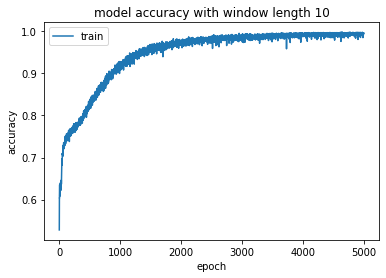

In [101]:
plt.plot(train_accs)
plt.title('model accuracy with window length 10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [102]:
plt.plot(train_losses)
plt.title('model loss with window length 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [119]:
first_model.reset_states()
test_results = calc_pos_neg_rate(first_model.evaluate(x=test_generator, verbose=0))

In [120]:
first_model.reset_states()
train_results = calc_pos_neg_rate(first_model.evaluate(x=train_generator, verbose=0))

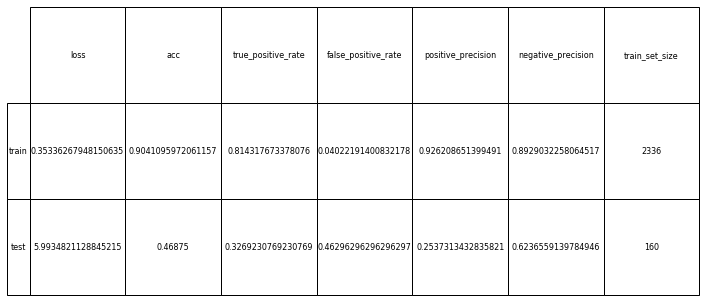

In [110]:
tabular_test_train_results(train_generator, test_generator, train_results, test_results)

Let's save this model for further use.

In [106]:
first_model.save(join(COLAB_DIR,'model_stateful.h5'))

Now, let's try window size of 20

In [125]:
train_generator, test_generator = generate_datasets_for_model(data, labels, \
                                                              stock_with_max_trading_days, \
                                                              training_start, training_end, \
                                                              testing_start, testing_end, window_in_days=20)

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
second_model = build_model(None, optimizer, layers, metrics=metrics)
second_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (32, 64)                  17920     
_________________________________________________________________
dense_52 (Dense)             (32, 32)                  2080      
_________________________________________________________________
dropout_13 (Dropout)         (32, 32)                  0         
_________________________________________________________________
dense_53 (Dense)             (32, 16)                  528       
_________________________________________________________________
batch_normalization_13 (Batc (32, 16)                  64        
_________________________________________________________________
dense_54 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_55 (Dense)             (32, 1)                 

In [126]:
train_accs, train_losses = fit(second_model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   2.048 seconds , loss : 0.697    accuracy : 0.577    
epoch 2
----------->> Epoch 1/1   0.612 seconds , loss : 0.660    accuracy : 0.615    
epoch 3
----------->> Epoch 1/1   0.555 seconds , loss : 0.661    accuracy : 0.602    
epoch 4
----------->> Epoch 1/1   0.446 seconds , loss : 0.655    accuracy : 0.610    
epoch 5
----------->> Epoch 1/1   0.495 seconds , loss : 0.655    accuracy : 0.609    
epoch 6
----------->> Epoch 1/1   0.338 seconds , loss : 0.648    accuracy : 0.616    
epoch 7
----------->> Epoch 1/1   0.340 seconds , loss : 0.646    accuracy : 0.625    
epoch 8
----------->> Epoch 1/1   0.383 seconds , loss : 0.644    accuracy : 0.637    
epoch 9
----------->> Epoch 1/1   0.400 seconds , loss : 0.645    accuracy : 0.627    
epoch 10
----------->> Epoch 1/1   0.552 seconds , loss : 0.645    accuracy : 0.626    
epoch 11
----------->> Epoch 1/1   0.608 seconds , loss : 0.644    accuracy : 0.633    
epoch 12
----------->> Epoch 1/1   0.491 

----------->> Epoch 1/1   0.236 seconds , loss : 0.491    accuracy : 0.773    
epoch 187
----------->> Epoch 1/1   0.277 seconds , loss : 0.490    accuracy : 0.775    
epoch 188
----------->> Epoch 1/1   0.247 seconds , loss : 0.486    accuracy : 0.783    
epoch 189
----------->> Epoch 1/1   0.441 seconds , loss : 0.490    accuracy : 0.777    
epoch 190
----------->> Epoch 1/1   0.268 seconds , loss : 0.494    accuracy : 0.771    
epoch 191
----------->> Epoch 1/1   0.500 seconds , loss : 0.480    accuracy : 0.775    
epoch 192
----------->> Epoch 1/1   0.327 seconds , loss : 0.488    accuracy : 0.774    
epoch 193
----------->> Epoch 1/1   0.376 seconds , loss : 0.486    accuracy : 0.780    
epoch 194
----------->> Epoch 1/1   0.425 seconds , loss : 0.484    accuracy : 0.777    
epoch 195
----------->> Epoch 1/1   0.304 seconds , loss : 0.483    accuracy : 0.781    
epoch 196
----------->> Epoch 1/1   0.287 seconds , loss : 0.495    accuracy : 0.770    
epoch 197
----------->> Epoch 1

----------->> Epoch 1/1   0.324 seconds , loss : 0.385    accuracy : 0.826    
epoch 371
----------->> Epoch 1/1   0.321 seconds , loss : 0.381    accuracy : 0.837    
epoch 372
----------->> Epoch 1/1   0.604 seconds , loss : 0.364    accuracy : 0.848    
epoch 373
----------->> Epoch 1/1   0.533 seconds , loss : 0.377    accuracy : 0.848    
epoch 374
----------->> Epoch 1/1   0.326 seconds , loss : 0.381    accuracy : 0.834    
epoch 375
----------->> Epoch 1/1   0.323 seconds , loss : 0.386    accuracy : 0.838    
epoch 376
----------->> Epoch 1/1   0.224 seconds , loss : 0.371    accuracy : 0.845    
epoch 377
----------->> Epoch 1/1   0.241 seconds , loss : 0.372    accuracy : 0.842    
epoch 378
----------->> Epoch 1/1   0.461 seconds , loss : 0.361    accuracy : 0.850    
epoch 379
----------->> Epoch 1/1   0.269 seconds , loss : 0.376    accuracy : 0.850    
epoch 380
----------->> Epoch 1/1   0.234 seconds , loss : 0.365    accuracy : 0.850    
epoch 381
----------->> Epoch 1

----------->> Epoch 1/1   0.449 seconds , loss : 0.262    accuracy : 0.898    
epoch 555
----------->> Epoch 1/1   0.450 seconds , loss : 0.265    accuracy : 0.896    
epoch 556
----------->> Epoch 1/1   0.339 seconds , loss : 0.267    accuracy : 0.893    
epoch 557
----------->> Epoch 1/1   0.325 seconds , loss : 0.260    accuracy : 0.900    
epoch 558
----------->> Epoch 1/1   0.283 seconds , loss : 0.254    accuracy : 0.897    
epoch 559
----------->> Epoch 1/1   0.388 seconds , loss : 0.257    accuracy : 0.898    
epoch 560
----------->> Epoch 1/1   0.293 seconds , loss : 0.264    accuracy : 0.901    
epoch 561
----------->> Epoch 1/1   0.356 seconds , loss : 0.269    accuracy : 0.896    
epoch 562
----------->> Epoch 1/1   0.523 seconds , loss : 0.257    accuracy : 0.899    
epoch 563
----------->> Epoch 1/1   0.273 seconds , loss : 0.272    accuracy : 0.890    
epoch 564
----------->> Epoch 1/1   0.422 seconds , loss : 0.266    accuracy : 0.898    
epoch 565
----------->> Epoch 1

----------->> Epoch 1/1   0.369 seconds , loss : 0.186    accuracy : 0.932    
epoch 739
----------->> Epoch 1/1   0.367 seconds , loss : 0.186    accuracy : 0.931    
epoch 740
----------->> Epoch 1/1   0.312 seconds , loss : 0.187    accuracy : 0.934    
epoch 741
----------->> Epoch 1/1   0.461 seconds , loss : 0.211    accuracy : 0.920    
epoch 742
----------->> Epoch 1/1   0.454 seconds , loss : 0.200    accuracy : 0.929    
epoch 743
----------->> Epoch 1/1   0.354 seconds , loss : 0.173    accuracy : 0.942    
epoch 744
----------->> Epoch 1/1   0.251 seconds , loss : 0.181    accuracy : 0.939    
epoch 745
----------->> Epoch 1/1   0.365 seconds , loss : 0.176    accuracy : 0.932    
epoch 746
----------->> Epoch 1/1   0.388 seconds , loss : 0.181    accuracy : 0.933    
epoch 747
----------->> Epoch 1/1   0.242 seconds , loss : 0.180    accuracy : 0.937    
epoch 748
----------->> Epoch 1/1   0.239 seconds , loss : 0.180    accuracy : 0.933    
epoch 749
----------->> Epoch 1

----------->> Epoch 1/1   0.693 seconds , loss : 0.137    accuracy : 0.953    
epoch 923
----------->> Epoch 1/1   0.472 seconds , loss : 0.134    accuracy : 0.957    
epoch 924
----------->> Epoch 1/1   0.385 seconds , loss : 0.157    accuracy : 0.949    
epoch 925
----------->> Epoch 1/1   0.341 seconds , loss : 0.147    accuracy : 0.949    
epoch 926
----------->> Epoch 1/1   0.423 seconds , loss : 0.145    accuracy : 0.952    
epoch 927
----------->> Epoch 1/1   0.362 seconds , loss : 0.130    accuracy : 0.958    
epoch 928
----------->> Epoch 1/1   0.403 seconds , loss : 0.127    accuracy : 0.955    
epoch 929
----------->> Epoch 1/1   0.531 seconds , loss : 0.136    accuracy : 0.950    
epoch 930
----------->> Epoch 1/1   0.327 seconds , loss : 0.151    accuracy : 0.952    
epoch 931
----------->> Epoch 1/1   0.409 seconds , loss : 0.123    accuracy : 0.958    
epoch 932
----------->> Epoch 1/1   0.433 seconds , loss : 0.143    accuracy : 0.954    
epoch 933
----------->> Epoch 1

----------->> Epoch 1/1   0.469 seconds , loss : 0.101    accuracy : 0.961    
epoch 1015
----------->> Epoch 1/1   0.485 seconds , loss : 0.121    accuracy : 0.960    
epoch 1016
----------->> Epoch 1/1   0.480 seconds , loss : 0.110    accuracy : 0.964    
epoch 1017
----------->> Epoch 1/1   0.473 seconds , loss : 0.114    accuracy : 0.965    
epoch 1018
----------->> Epoch 1/1   0.471 seconds , loss : 0.129    accuracy : 0.954    
epoch 1019
----------->> Epoch 1/1   0.432 seconds , loss : 0.127    accuracy : 0.956    
epoch 1020
----------->> Epoch 1/1   0.478 seconds , loss : 0.107    accuracy : 0.961    
epoch 1021
----------->> Epoch 1/1   0.623 seconds , loss : 0.182    accuracy : 0.947    
epoch 1022
----------->> Epoch 1/1   0.491 seconds , loss : 0.165    accuracy : 0.947    
epoch 1023
----------->> Epoch 1/1   0.527 seconds , loss : 0.110    accuracy : 0.964    
epoch 1024
----------->> Epoch 1/1   0.498 seconds , loss : 0.105    accuracy : 0.970    
epoch 1025
----------

----------->> Epoch 1/1   0.454 seconds , loss : 0.072    accuracy : 0.982    
epoch 1197
----------->> Epoch 1/1   0.324 seconds , loss : 0.093    accuracy : 0.969    
epoch 1198
----------->> Epoch 1/1   0.467 seconds , loss : 0.133    accuracy : 0.959    
epoch 1199
----------->> Epoch 1/1   0.387 seconds , loss : 0.139    accuracy : 0.960    
epoch 1200
----------->> Epoch 1/1   0.544 seconds , loss : 0.106    accuracy : 0.966    
epoch 1201
----------->> Epoch 1/1   0.369 seconds , loss : 0.066    accuracy : 0.981    
epoch 1202
----------->> Epoch 1/1   0.335 seconds , loss : 0.083    accuracy : 0.970    
epoch 1203
----------->> Epoch 1/1   0.633 seconds , loss : 0.094    accuracy : 0.973    
epoch 1204
----------->> Epoch 1/1   0.603 seconds , loss : 0.107    accuracy : 0.965    
epoch 1205
----------->> Epoch 1/1   0.516 seconds , loss : 0.111    accuracy : 0.961    
epoch 1206
----------->> Epoch 1/1   0.329 seconds , loss : 0.119    accuracy : 0.960    
epoch 1207
----------

----------->> Epoch 1/1   0.684 seconds , loss : 0.096    accuracy : 0.969    
epoch 1379
----------->> Epoch 1/1   0.394 seconds , loss : 0.064    accuracy : 0.979    
epoch 1380
----------->> Epoch 1/1   0.529 seconds , loss : 0.063    accuracy : 0.979    
epoch 1381
----------->> Epoch 1/1   0.551 seconds , loss : 0.081    accuracy : 0.974    
epoch 1382
----------->> Epoch 1/1   0.588 seconds , loss : 0.076    accuracy : 0.976    
epoch 1383
----------->> Epoch 1/1   0.504 seconds , loss : 0.064    accuracy : 0.977    
epoch 1384
----------->> Epoch 1/1   0.567 seconds , loss : 0.057    accuracy : 0.982    
epoch 1385
----------->> Epoch 1/1   0.562 seconds , loss : 0.069    accuracy : 0.979    
epoch 1386
----------->> Epoch 1/1   0.559 seconds , loss : 0.077    accuracy : 0.977    
epoch 1387
----------->> Epoch 1/1   0.408 seconds , loss : 0.089    accuracy : 0.975    
epoch 1388
----------->> Epoch 1/1   0.548 seconds , loss : 0.086    accuracy : 0.974    
epoch 1389
----------

----------->> Epoch 1/1   0.411 seconds , loss : 0.051    accuracy : 0.984    
epoch 1561
----------->> Epoch 1/1   0.359 seconds , loss : 0.046    accuracy : 0.988    
epoch 1562
----------->> Epoch 1/1   0.398 seconds , loss : 0.044    accuracy : 0.987    
epoch 1563
----------->> Epoch 1/1   0.413 seconds , loss : 0.052    accuracy : 0.984    
epoch 1564
----------->> Epoch 1/1   0.607 seconds , loss : 0.036    accuracy : 0.986    
epoch 1565
----------->> Epoch 1/1   0.481 seconds , loss : 0.038    accuracy : 0.989    
epoch 1566
----------->> Epoch 1/1   0.379 seconds , loss : 0.040    accuracy : 0.988    
epoch 1567
----------->> Epoch 1/1   0.390 seconds , loss : 0.037    accuracy : 0.989    
epoch 1568
----------->> Epoch 1/1   0.356 seconds , loss : 0.032    accuracy : 0.988    
epoch 1569
----------->> Epoch 1/1   0.393 seconds , loss : 0.031    accuracy : 0.991    
epoch 1570
----------->> Epoch 1/1   0.395 seconds , loss : 0.048    accuracy : 0.982    
epoch 1571
----------

----------->> Epoch 1/1   0.631 seconds , loss : 0.039    accuracy : 0.989    
epoch 1743
----------->> Epoch 1/1   0.460 seconds , loss : 0.044    accuracy : 0.988    
epoch 1744
----------->> Epoch 1/1   0.562 seconds , loss : 0.036    accuracy : 0.988    
epoch 1745
----------->> Epoch 1/1   0.356 seconds , loss : 0.082    accuracy : 0.979    
epoch 1746
----------->> Epoch 1/1   0.340 seconds , loss : 0.052    accuracy : 0.982    
epoch 1747
----------->> Epoch 1/1   0.516 seconds , loss : 0.034    accuracy : 0.988    
epoch 1748
----------->> Epoch 1/1   0.475 seconds , loss : 0.039    accuracy : 0.985    
epoch 1749
----------->> Epoch 1/1   0.387 seconds , loss : 0.049    accuracy : 0.982    
epoch 1750
----------->> Epoch 1/1   0.675 seconds , loss : 0.047    accuracy : 0.984    
epoch 1751
----------->> Epoch 1/1   0.632 seconds , loss : 0.167    accuracy : 0.964    
epoch 1752
----------->> Epoch 1/1   0.499 seconds , loss : 0.052    accuracy : 0.982    
epoch 1753
----------

----------->> Epoch 1/1   0.313 seconds , loss : 0.012    accuracy : 0.997    
epoch 1925
----------->> Epoch 1/1   0.541 seconds , loss : 0.019    accuracy : 0.995    
epoch 1926
----------->> Epoch 1/1   0.609 seconds , loss : 0.034    accuracy : 0.989    
epoch 1927
----------->> Epoch 1/1   0.507 seconds , loss : 0.084    accuracy : 0.976    
epoch 1928
----------->> Epoch 1/1   0.671 seconds , loss : 0.032    accuracy : 0.988    
epoch 1929
----------->> Epoch 1/1   0.778 seconds , loss : 0.023    accuracy : 0.994    
epoch 1930
----------->> Epoch 1/1   0.573 seconds , loss : 0.020    accuracy : 0.993    
epoch 1931
----------->> Epoch 1/1   0.519 seconds , loss : 0.018    accuracy : 0.993    
epoch 1932
----------->> Epoch 1/1   0.527 seconds , loss : 0.017    accuracy : 0.994    
epoch 1933
----------->> Epoch 1/1   0.581 seconds , loss : 0.042    accuracy : 0.988    
epoch 1934
----------->> Epoch 1/1   0.481 seconds , loss : 0.052    accuracy : 0.982    
epoch 1935
----------

----------->> Epoch 1/1   0.555 seconds , loss : 0.018    accuracy : 0.994    
epoch 2107
----------->> Epoch 1/1   0.302 seconds , loss : 0.020    accuracy : 0.994    
epoch 2108
----------->> Epoch 1/1   0.528 seconds , loss : 0.064    accuracy : 0.981    
epoch 2109
----------->> Epoch 1/1   0.534 seconds , loss : 0.100    accuracy : 0.969    
epoch 2110
----------->> Epoch 1/1   0.355 seconds , loss : 0.113    accuracy : 0.968    
epoch 2111
----------->> Epoch 1/1   0.329 seconds , loss : 0.070    accuracy : 0.975    
epoch 2112
----------->> Epoch 1/1   0.275 seconds , loss : 0.036    accuracy : 0.988    
epoch 2113
----------->> Epoch 1/1   0.446 seconds , loss : 0.033    accuracy : 0.988    
epoch 2114
----------->> Epoch 1/1   0.369 seconds , loss : 0.019    accuracy : 0.994    
epoch 2115
----------->> Epoch 1/1   0.416 seconds , loss : 0.012    accuracy : 0.998    
epoch 2116
----------->> Epoch 1/1   0.346 seconds , loss : 0.014    accuracy : 0.997    
epoch 2117
----------

----------->> Epoch 1/1   0.267 seconds , loss : 0.009    accuracy : 0.999    
epoch 2289
----------->> Epoch 1/1   0.300 seconds , loss : 0.011    accuracy : 0.997    
epoch 2290
----------->> Epoch 1/1   0.306 seconds , loss : 0.012    accuracy : 0.996    
epoch 2291
----------->> Epoch 1/1   0.269 seconds , loss : 0.069    accuracy : 0.985    
epoch 2292
----------->> Epoch 1/1   0.530 seconds , loss : 0.086    accuracy : 0.976    
epoch 2293
----------->> Epoch 1/1   0.594 seconds , loss : 0.044    accuracy : 0.988    
epoch 2294
----------->> Epoch 1/1   0.327 seconds , loss : 0.022    accuracy : 0.993    
epoch 2295
----------->> Epoch 1/1   0.549 seconds , loss : 0.015    accuracy : 0.997    
epoch 2296
----------->> Epoch 1/1   0.586 seconds , loss : 0.012    accuracy : 0.997    
epoch 2297
----------->> Epoch 1/1   0.441 seconds , loss : 0.010    accuracy : 0.997    
epoch 2298
----------->> Epoch 1/1   0.339 seconds , loss : 0.011    accuracy : 0.996    
epoch 2299
----------

----------->> Epoch 1/1   0.356 seconds , loss : 0.008    accuracy : 0.998    
epoch 2471
----------->> Epoch 1/1   0.570 seconds , loss : 0.008    accuracy : 0.997    
epoch 2472
----------->> Epoch 1/1   0.392 seconds , loss : 0.009    accuracy : 0.997    
epoch 2473
----------->> Epoch 1/1   0.718 seconds , loss : 0.011    accuracy : 0.997    
epoch 2474
----------->> Epoch 1/1   1.011 seconds , loss : 0.009    accuracy : 0.998    
epoch 2475
----------->> Epoch 1/1   1.116 seconds , loss : 0.009    accuracy : 0.998    
epoch 2476
----------->> Epoch 1/1   1.030 seconds , loss : 0.009    accuracy : 0.999    
epoch 2477
----------->> Epoch 1/1   0.448 seconds , loss : 0.009    accuracy : 0.998    
epoch 2478
----------->> Epoch 1/1   0.371 seconds , loss : 0.009    accuracy : 0.997    
epoch 2479
----------->> Epoch 1/1   0.298 seconds , loss : 0.010    accuracy : 0.997    
epoch 2480
----------->> Epoch 1/1   0.563 seconds , loss : 0.013    accuracy : 0.996    
epoch 2481
----------

----------->> Epoch 1/1   0.992 seconds , loss : 0.021    accuracy : 0.994    
epoch 2653
----------->> Epoch 1/1   0.767 seconds , loss : 0.016    accuracy : 0.996    
epoch 2654
----------->> Epoch 1/1   0.770 seconds , loss : 0.010    accuracy : 0.997    
epoch 2655
----------->> Epoch 1/1   0.852 seconds , loss : 0.011    accuracy : 0.997    
epoch 2656
----------->> Epoch 1/1   0.843 seconds , loss : 0.009    accuracy : 0.997    
epoch 2657
----------->> Epoch 1/1   0.632 seconds , loss : 0.009    accuracy : 0.997    
epoch 2658
----------->> Epoch 1/1   0.640 seconds , loss : 0.009    accuracy : 0.997    
epoch 2659
----------->> Epoch 1/1   0.540 seconds , loss : 0.008    accuracy : 0.997    
epoch 2660
----------->> Epoch 1/1   0.322 seconds , loss : 0.007    accuracy : 0.998    
epoch 2661
----------->> Epoch 1/1   0.380 seconds , loss : 0.007    accuracy : 0.998    
epoch 2662
----------->> Epoch 1/1   0.596 seconds , loss : 0.007    accuracy : 0.997    
epoch 2663
----------

----------->> Epoch 1/1   0.287 seconds , loss : 0.008    accuracy : 0.998    
epoch 2835
----------->> Epoch 1/1   0.278 seconds , loss : 0.006    accuracy : 0.999    
epoch 2836
----------->> Epoch 1/1   0.245 seconds , loss : 0.007    accuracy : 0.998    
epoch 2837
----------->> Epoch 1/1   0.312 seconds , loss : 0.007    accuracy : 0.999    
epoch 2838
----------->> Epoch 1/1   0.274 seconds , loss : 0.007    accuracy : 0.998    
epoch 2839
----------->> Epoch 1/1   0.278 seconds , loss : 0.010    accuracy : 0.997    
epoch 2840
----------->> Epoch 1/1   0.244 seconds , loss : 0.008    accuracy : 0.998    
epoch 2841
----------->> Epoch 1/1   0.284 seconds , loss : 0.007    accuracy : 0.997    
epoch 2842
----------->> Epoch 1/1   0.239 seconds , loss : 0.009    accuracy : 0.998    
epoch 2843
----------->> Epoch 1/1   0.251 seconds , loss : 0.038    accuracy : 0.991    
epoch 2844
----------->> Epoch 1/1   0.242 seconds , loss : 0.173    accuracy : 0.963    
epoch 2845
----------

----------->> Epoch 1/1   0.289 seconds , loss : 0.008    accuracy : 0.998    
epoch 3017
----------->> Epoch 1/1   0.272 seconds , loss : 0.008    accuracy : 0.997    
epoch 3018
----------->> Epoch 1/1   0.297 seconds , loss : 0.007    accuracy : 0.998    
epoch 3019
----------->> Epoch 1/1   0.281 seconds , loss : 0.009    accuracy : 0.998    
epoch 3020
----------->> Epoch 1/1   0.300 seconds , loss : 0.010    accuracy : 0.996    
epoch 3021
----------->> Epoch 1/1   0.354 seconds , loss : 0.009    accuracy : 0.998    
epoch 3022
----------->> Epoch 1/1   0.333 seconds , loss : 0.007    accuracy : 0.997    
epoch 3023
----------->> Epoch 1/1   0.275 seconds , loss : 0.008    accuracy : 0.998    
epoch 3024
----------->> Epoch 1/1   0.265 seconds , loss : 0.008    accuracy : 0.998    
epoch 3025
----------->> Epoch 1/1   0.253 seconds , loss : 0.008    accuracy : 0.997    
epoch 3026
----------->> Epoch 1/1   0.271 seconds , loss : 0.008    accuracy : 0.997    
epoch 3027
----------

----------->> Epoch 1/1   0.252 seconds , loss : 0.012    accuracy : 0.997    
epoch 3199
----------->> Epoch 1/1   0.250 seconds , loss : 0.009    accuracy : 0.997    
epoch 3200
----------->> Epoch 1/1   0.254 seconds , loss : 0.008    accuracy : 0.998    
epoch 3201
----------->> Epoch 1/1   0.253 seconds , loss : 0.008    accuracy : 0.998    
epoch 3202
----------->> Epoch 1/1   0.256 seconds , loss : 0.007    accuracy : 0.998    
epoch 3203
----------->> Epoch 1/1   0.252 seconds , loss : 0.008    accuracy : 0.998    
epoch 3204
----------->> Epoch 1/1   0.300 seconds , loss : 0.007    accuracy : 0.998    
epoch 3205
----------->> Epoch 1/1   0.308 seconds , loss : 0.009    accuracy : 0.998    
epoch 3206
----------->> Epoch 1/1   0.288 seconds , loss : 0.007    accuracy : 0.998    
epoch 3207
----------->> Epoch 1/1   0.301 seconds , loss : 0.008    accuracy : 0.997    
epoch 3208
----------->> Epoch 1/1   0.296 seconds , loss : 0.007    accuracy : 0.998    
epoch 3209
----------

----------->> Epoch 1/1   0.301 seconds , loss : 0.018    accuracy : 0.995    
epoch 3381
----------->> Epoch 1/1   0.300 seconds , loss : 0.014    accuracy : 0.995    
epoch 3382
----------->> Epoch 1/1   0.309 seconds , loss : 0.023    accuracy : 0.993    
epoch 3383
----------->> Epoch 1/1   0.307 seconds , loss : 0.058    accuracy : 0.988    
epoch 3384
----------->> Epoch 1/1   0.296 seconds , loss : 0.019    accuracy : 0.993    
epoch 3385
----------->> Epoch 1/1   0.304 seconds , loss : 0.032    accuracy : 0.990    
epoch 3386
----------->> Epoch 1/1   0.303 seconds , loss : 0.023    accuracy : 0.992    
epoch 3387
----------->> Epoch 1/1   0.293 seconds , loss : 0.016    accuracy : 0.994    
epoch 3388
----------->> Epoch 1/1   0.293 seconds , loss : 0.009    accuracy : 0.998    
epoch 3389
----------->> Epoch 1/1   0.294 seconds , loss : 0.015    accuracy : 0.995    
epoch 3390
----------->> Epoch 1/1   0.275 seconds , loss : 0.046    accuracy : 0.988    
epoch 3391
----------

----------->> Epoch 1/1   0.324 seconds , loss : 0.008    accuracy : 0.997    
epoch 3563
----------->> Epoch 1/1   0.316 seconds , loss : 0.008    accuracy : 0.998    
epoch 3564
----------->> Epoch 1/1   0.311 seconds , loss : 0.008    accuracy : 0.997    
epoch 3565
----------->> Epoch 1/1   0.317 seconds , loss : 0.008    accuracy : 0.998    
epoch 3566
----------->> Epoch 1/1   0.263 seconds , loss : 0.008    accuracy : 0.997    
epoch 3567
----------->> Epoch 1/1   0.254 seconds , loss : 0.027    accuracy : 0.993    
epoch 3568
----------->> Epoch 1/1   0.252 seconds , loss : 0.017    accuracy : 0.995    
epoch 3569
----------->> Epoch 1/1   0.252 seconds , loss : 0.019    accuracy : 0.994    
epoch 3570
----------->> Epoch 1/1   0.310 seconds , loss : 0.011    accuracy : 0.997    
epoch 3571
----------->> Epoch 1/1   0.255 seconds , loss : 0.012    accuracy : 0.996    
epoch 3572
----------->> Epoch 1/1   0.253 seconds , loss : 0.024    accuracy : 0.994    
epoch 3573
----------

----------->> Epoch 1/1   0.280 seconds , loss : 0.006    accuracy : 0.998    
epoch 3745
----------->> Epoch 1/1   0.285 seconds , loss : 0.006    accuracy : 0.998    
epoch 3746
----------->> Epoch 1/1   0.293 seconds , loss : 0.007    accuracy : 0.998    
epoch 3747
----------->> Epoch 1/1   0.282 seconds , loss : 0.006    accuracy : 0.997    
epoch 3748
----------->> Epoch 1/1   0.300 seconds , loss : 0.007    accuracy : 0.996    
epoch 3749
----------->> Epoch 1/1   0.282 seconds , loss : 0.006    accuracy : 0.998    
epoch 3750
----------->> Epoch 1/1   0.281 seconds , loss : 0.007    accuracy : 0.998    
epoch 3751
----------->> Epoch 1/1   0.288 seconds , loss : 0.007    accuracy : 0.997    
epoch 3752
----------->> Epoch 1/1   0.296 seconds , loss : 0.007    accuracy : 0.998    
epoch 3753
----------->> Epoch 1/1   0.285 seconds , loss : 0.007    accuracy : 0.998    
epoch 3754
----------->> Epoch 1/1   0.279 seconds , loss : 0.006    accuracy : 0.998    
epoch 3755
----------

----------->> Epoch 1/1   0.251 seconds , loss : 0.006    accuracy : 0.999    
epoch 3927
----------->> Epoch 1/1   0.254 seconds , loss : 0.006    accuracy : 0.998    
epoch 3928
----------->> Epoch 1/1   0.241 seconds , loss : 0.007    accuracy : 0.998    
epoch 3929
----------->> Epoch 1/1   0.242 seconds , loss : 0.006    accuracy : 0.998    
epoch 3930
----------->> Epoch 1/1   0.243 seconds , loss : 0.007    accuracy : 0.997    
epoch 3931
----------->> Epoch 1/1   0.241 seconds , loss : 0.006    accuracy : 0.998    
epoch 3932
----------->> Epoch 1/1   0.242 seconds , loss : 0.007    accuracy : 0.997    
epoch 3933
----------->> Epoch 1/1   0.244 seconds , loss : 0.006    accuracy : 0.998    
epoch 3934
----------->> Epoch 1/1   0.242 seconds , loss : 0.006    accuracy : 0.998    
epoch 3935
----------->> Epoch 1/1   0.243 seconds , loss : 0.008    accuracy : 0.998    
epoch 3936
----------->> Epoch 1/1   0.243 seconds , loss : 0.006    accuracy : 0.998    
epoch 3937
----------

----------->> Epoch 1/1   0.308 seconds , loss : 0.009    accuracy : 0.997    
epoch 4109
----------->> Epoch 1/1   0.277 seconds , loss : 0.007    accuracy : 0.998    
epoch 4110
----------->> Epoch 1/1   0.283 seconds , loss : 0.007    accuracy : 0.998    
epoch 4111
----------->> Epoch 1/1   0.259 seconds , loss : 0.006    accuracy : 0.998    
epoch 4112
----------->> Epoch 1/1   0.284 seconds , loss : 0.005    accuracy : 0.999    
epoch 4113
----------->> Epoch 1/1   0.248 seconds , loss : 0.006    accuracy : 0.997    
epoch 4114
----------->> Epoch 1/1   0.260 seconds , loss : 0.005    accuracy : 0.998    
epoch 4115
----------->> Epoch 1/1   0.294 seconds , loss : 0.009    accuracy : 0.998    
epoch 4116
----------->> Epoch 1/1   0.259 seconds , loss : 0.007    accuracy : 0.998    
epoch 4117
----------->> Epoch 1/1   0.308 seconds , loss : 0.004    accuracy : 0.999    
epoch 4118
----------->> Epoch 1/1   0.234 seconds , loss : 0.005    accuracy : 0.998    
epoch 4119
----------

----------->> Epoch 1/1   0.266 seconds , loss : 0.014    accuracy : 0.996    
epoch 4291
----------->> Epoch 1/1   0.249 seconds , loss : 0.015    accuracy : 0.995    
epoch 4292
----------->> Epoch 1/1   0.301 seconds , loss : 0.010    accuracy : 0.998    
epoch 4293
----------->> Epoch 1/1   0.286 seconds , loss : 0.009    accuracy : 0.998    
epoch 4294
----------->> Epoch 1/1   0.295 seconds , loss : 0.008    accuracy : 0.997    
epoch 4295
----------->> Epoch 1/1   0.247 seconds , loss : 0.007    accuracy : 0.998    
epoch 4296
----------->> Epoch 1/1   0.293 seconds , loss : 0.007    accuracy : 0.998    
epoch 4297
----------->> Epoch 1/1   0.288 seconds , loss : 0.007    accuracy : 0.998    
epoch 4298
----------->> Epoch 1/1   0.256 seconds , loss : 0.008    accuracy : 0.998    
epoch 4299
----------->> Epoch 1/1   0.255 seconds , loss : 0.006    accuracy : 0.997    
epoch 4300
----------->> Epoch 1/1   0.297 seconds , loss : 0.007    accuracy : 0.998    
epoch 4301
----------

----------->> Epoch 1/1   0.303 seconds , loss : 0.005    accuracy : 0.998    
epoch 4473
----------->> Epoch 1/1   0.300 seconds , loss : 0.007    accuracy : 0.998    
epoch 4474
----------->> Epoch 1/1   0.289 seconds , loss : 0.007    accuracy : 0.998    
epoch 4475
----------->> Epoch 1/1   0.281 seconds , loss : 0.007    accuracy : 0.998    
epoch 4476
----------->> Epoch 1/1   0.257 seconds , loss : 0.006    accuracy : 0.998    
epoch 4477
----------->> Epoch 1/1   0.256 seconds , loss : 0.006    accuracy : 0.998    
epoch 4478
----------->> Epoch 1/1   0.263 seconds , loss : 0.006    accuracy : 0.997    
epoch 4479
----------->> Epoch 1/1   0.250 seconds , loss : 0.008    accuracy : 0.997    
epoch 4480
----------->> Epoch 1/1   0.251 seconds , loss : 0.040    accuracy : 0.989    
epoch 4481
----------->> Epoch 1/1   0.285 seconds , loss : 0.046    accuracy : 0.987    
epoch 4482
----------->> Epoch 1/1   0.286 seconds , loss : 0.040    accuracy : 0.986    
epoch 4483
----------

----------->> Epoch 1/1   0.243 seconds , loss : 0.007    accuracy : 0.998    
epoch 4655
----------->> Epoch 1/1   0.247 seconds , loss : 0.006    accuracy : 0.997    
epoch 4656
----------->> Epoch 1/1   0.246 seconds , loss : 0.008    accuracy : 0.997    
epoch 4657
----------->> Epoch 1/1   0.246 seconds , loss : 0.007    accuracy : 0.998    
epoch 4658
----------->> Epoch 1/1   0.247 seconds , loss : 0.007    accuracy : 0.997    
epoch 4659
----------->> Epoch 1/1   0.247 seconds , loss : 0.013    accuracy : 0.997    
epoch 4660
----------->> Epoch 1/1   0.241 seconds , loss : 0.152    accuracy : 0.973    
epoch 4661
----------->> Epoch 1/1   0.247 seconds , loss : 0.045    accuracy : 0.986    
epoch 4662
----------->> Epoch 1/1   0.247 seconds , loss : 0.019    accuracy : 0.995    
epoch 4663
----------->> Epoch 1/1   0.242 seconds , loss : 0.015    accuracy : 0.995    
epoch 4664
----------->> Epoch 1/1   0.244 seconds , loss : 0.011    accuracy : 0.997    
epoch 4665
----------

----------->> Epoch 1/1   0.240 seconds , loss : 0.026    accuracy : 0.992    
epoch 4837
----------->> Epoch 1/1   0.243 seconds , loss : 0.035    accuracy : 0.990    
epoch 4838
----------->> Epoch 1/1   0.243 seconds , loss : 0.009    accuracy : 0.998    
epoch 4839
----------->> Epoch 1/1   0.245 seconds , loss : 0.007    accuracy : 0.997    
epoch 4840
----------->> Epoch 1/1   0.240 seconds , loss : 0.009    accuracy : 0.997    
epoch 4841
----------->> Epoch 1/1   0.244 seconds , loss : 0.006    accuracy : 0.998    
epoch 4842
----------->> Epoch 1/1   0.243 seconds , loss : 0.005    accuracy : 0.998    
epoch 4843
----------->> Epoch 1/1   0.244 seconds , loss : 0.007    accuracy : 0.998    
epoch 4844
----------->> Epoch 1/1   0.241 seconds , loss : 0.006    accuracy : 0.998    
epoch 4845
----------->> Epoch 1/1   0.243 seconds , loss : 0.006    accuracy : 0.998    
epoch 4846
----------->> Epoch 1/1   0.246 seconds , loss : 0.005    accuracy : 0.998    
epoch 4847
----------

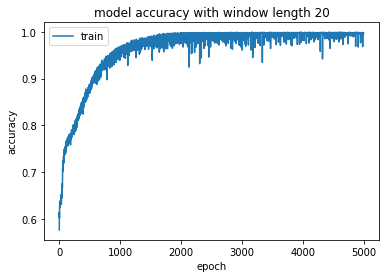

In [127]:
plt.plot(train_accs)
plt.title('model accuracy with window length 20')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [128]:
plt.plot(train_losses)
plt.title('model loss with window length 20')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [129]:
second_model.reset_states()
test_results = calc_pos_neg_rate(second_model.evaluate(x=test_generator, verbose=0))

In [130]:
second_model.reset_states()
train_results = calc_pos_neg_rate(second_model.evaluate(x=train_generator, verbose=0))

In [131]:
tabular_test_train_results(train_generator, test_generator, train_results, test_results)

Let's save this model for further use.

In [144]:
second_model.save(join(COLAB_DIR,'model_stateful_20.h5'))

Now, let's try window size of 30

In [41]:
train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, training_end, testing_start, testing_end, window_in_days=30)

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
third_model = build_model(None, optimizer, layers, metrics=metrics)
third_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (32, 64)                  17920     
_________________________________________________________________
dense_8 (Dense)              (32, 32)                  2080      
_________________________________________________________________
dropout_2 (Dropout)          (32, 32)                  0         
_________________________________________________________________
dense_9 (Dense)              (32, 16)                  528       
_________________________________________________________________
batch_normalization_2 (Batch (32, 16)                  64        
_________________________________________________________________
dense_10 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_11 (Dense)             (32, 1)                  

In [42]:
train_accs, train_losses = fit(third_model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   1.664 seconds , loss : 0.707    accuracy : 0.574    
epoch 2
----------->> Epoch 1/1   0.264 seconds , loss : 0.670    accuracy : 0.610    
epoch 3
----------->> Epoch 1/1   0.254 seconds , loss : 0.662    accuracy : 0.607    
epoch 4
----------->> Epoch 1/1   0.256 seconds , loss : 0.656    accuracy : 0.617    
epoch 5
----------->> Epoch 1/1   0.255 seconds , loss : 0.661    accuracy : 0.617    
epoch 6
----------->> Epoch 1/1   0.268 seconds , loss : 0.654    accuracy : 0.615    
epoch 7
----------->> Epoch 1/1   0.254 seconds , loss : 0.651    accuracy : 0.618    
epoch 8
----------->> Epoch 1/1   0.250 seconds , loss : 0.646    accuracy : 0.616    
epoch 9
----------->> Epoch 1/1   0.251 seconds , loss : 0.650    accuracy : 0.622    
epoch 10
----------->> Epoch 1/1   0.253 seconds , loss : 0.646    accuracy : 0.626    
epoch 11
----------->> Epoch 1/1   0.248 seconds , loss : 0.646    accuracy : 0.632    
epoch 12
----------->> Epoch 1/1   0.257 

----------->> Epoch 1/1   0.260 seconds , loss : 0.474    accuracy : 0.787    
epoch 187
----------->> Epoch 1/1   0.251 seconds , loss : 0.469    accuracy : 0.789    
epoch 188
----------->> Epoch 1/1   0.243 seconds , loss : 0.479    accuracy : 0.782    
epoch 189
----------->> Epoch 1/1   0.251 seconds , loss : 0.472    accuracy : 0.791    
epoch 190
----------->> Epoch 1/1   0.253 seconds , loss : 0.475    accuracy : 0.787    
epoch 191
----------->> Epoch 1/1   0.257 seconds , loss : 0.471    accuracy : 0.788    
epoch 192
----------->> Epoch 1/1   0.251 seconds , loss : 0.469    accuracy : 0.787    
epoch 193
----------->> Epoch 1/1   0.251 seconds , loss : 0.461    accuracy : 0.789    
epoch 194
----------->> Epoch 1/1   0.256 seconds , loss : 0.463    accuracy : 0.792    
epoch 195
----------->> Epoch 1/1   0.251 seconds , loss : 0.455    accuracy : 0.794    
epoch 196
----------->> Epoch 1/1   0.244 seconds , loss : 0.471    accuracy : 0.790    
epoch 197
----------->> Epoch 1

----------->> Epoch 1/1   0.257 seconds , loss : 0.329    accuracy : 0.865    
epoch 371
----------->> Epoch 1/1   0.257 seconds , loss : 0.350    accuracy : 0.858    
epoch 372
----------->> Epoch 1/1   0.263 seconds , loss : 0.341    accuracy : 0.856    
epoch 373
----------->> Epoch 1/1   0.255 seconds , loss : 0.344    accuracy : 0.857    
epoch 374
----------->> Epoch 1/1   0.257 seconds , loss : 0.347    accuracy : 0.857    
epoch 375
----------->> Epoch 1/1   0.261 seconds , loss : 0.338    accuracy : 0.865    
epoch 376
----------->> Epoch 1/1   0.255 seconds , loss : 0.335    accuracy : 0.864    
epoch 377
----------->> Epoch 1/1   0.259 seconds , loss : 0.355    accuracy : 0.853    
epoch 378
----------->> Epoch 1/1   0.261 seconds , loss : 0.343    accuracy : 0.859    
epoch 379
----------->> Epoch 1/1   0.256 seconds , loss : 0.336    accuracy : 0.865    
epoch 380
----------->> Epoch 1/1   0.255 seconds , loss : 0.341    accuracy : 0.858    
epoch 381
----------->> Epoch 1

----------->> Epoch 1/1   0.255 seconds , loss : 0.219    accuracy : 0.920    
epoch 555
----------->> Epoch 1/1   0.258 seconds , loss : 0.215    accuracy : 0.920    
epoch 556
----------->> Epoch 1/1   0.260 seconds , loss : 0.229    accuracy : 0.916    
epoch 557
----------->> Epoch 1/1   0.257 seconds , loss : 0.248    accuracy : 0.899    
epoch 558
----------->> Epoch 1/1   0.259 seconds , loss : 0.231    accuracy : 0.916    
epoch 559
----------->> Epoch 1/1   0.257 seconds , loss : 0.213    accuracy : 0.922    
epoch 560
----------->> Epoch 1/1   0.261 seconds , loss : 0.223    accuracy : 0.916    
epoch 561
----------->> Epoch 1/1   0.256 seconds , loss : 0.243    accuracy : 0.910    
epoch 562
----------->> Epoch 1/1   0.262 seconds , loss : 0.227    accuracy : 0.909    
epoch 563
----------->> Epoch 1/1   0.256 seconds , loss : 0.244    accuracy : 0.912    
epoch 564
----------->> Epoch 1/1   0.257 seconds , loss : 0.254    accuracy : 0.903    
epoch 565
----------->> Epoch 1

----------->> Epoch 1/1   0.259 seconds , loss : 0.148    accuracy : 0.947    
epoch 739
----------->> Epoch 1/1   0.260 seconds , loss : 0.166    accuracy : 0.940    
epoch 740
----------->> Epoch 1/1   0.262 seconds , loss : 0.134    accuracy : 0.952    
epoch 741
----------->> Epoch 1/1   0.261 seconds , loss : 0.142    accuracy : 0.949    
epoch 742
----------->> Epoch 1/1   0.258 seconds , loss : 0.151    accuracy : 0.949    
epoch 743
----------->> Epoch 1/1   0.257 seconds , loss : 0.141    accuracy : 0.954    
epoch 744
----------->> Epoch 1/1   0.257 seconds , loss : 0.145    accuracy : 0.951    
epoch 745
----------->> Epoch 1/1   0.258 seconds , loss : 0.132    accuracy : 0.958    
epoch 746
----------->> Epoch 1/1   0.262 seconds , loss : 0.127    accuracy : 0.958    
epoch 747
----------->> Epoch 1/1   0.256 seconds , loss : 0.162    accuracy : 0.944    
epoch 748
----------->> Epoch 1/1   0.258 seconds , loss : 0.138    accuracy : 0.953    
epoch 749
----------->> Epoch 1

----------->> Epoch 1/1   0.258 seconds , loss : 0.108    accuracy : 0.961    
epoch 923
----------->> Epoch 1/1   0.257 seconds , loss : 0.095    accuracy : 0.970    
epoch 924
----------->> Epoch 1/1   0.257 seconds , loss : 0.113    accuracy : 0.964    
epoch 925
----------->> Epoch 1/1   0.256 seconds , loss : 0.133    accuracy : 0.955    
epoch 926
----------->> Epoch 1/1   0.261 seconds , loss : 0.125    accuracy : 0.956    
epoch 927
----------->> Epoch 1/1   0.257 seconds , loss : 0.244    accuracy : 0.932    
epoch 928
----------->> Epoch 1/1   0.257 seconds , loss : 0.214    accuracy : 0.926    
epoch 929
----------->> Epoch 1/1   0.256 seconds , loss : 0.112    accuracy : 0.963    
epoch 930
----------->> Epoch 1/1   0.257 seconds , loss : 0.087    accuracy : 0.973    
epoch 931
----------->> Epoch 1/1   0.258 seconds , loss : 0.085    accuracy : 0.976    
epoch 932
----------->> Epoch 1/1   0.255 seconds , loss : 0.091    accuracy : 0.972    
epoch 933
----------->> Epoch 1

----------->> Epoch 1/1   0.258 seconds , loss : 0.094    accuracy : 0.970    
epoch 1015
----------->> Epoch 1/1   0.256 seconds , loss : 0.076    accuracy : 0.975    
epoch 1016
----------->> Epoch 1/1   0.260 seconds , loss : 0.074    accuracy : 0.981    
epoch 1017
----------->> Epoch 1/1   0.256 seconds , loss : 0.067    accuracy : 0.981    
epoch 1018
----------->> Epoch 1/1   0.257 seconds , loss : 0.080    accuracy : 0.975    
epoch 1019
----------->> Epoch 1/1   0.256 seconds , loss : 0.062    accuracy : 0.985    
epoch 1020
----------->> Epoch 1/1   0.262 seconds , loss : 0.058    accuracy : 0.982    
epoch 1021
----------->> Epoch 1/1   0.254 seconds , loss : 0.067    accuracy : 0.979    
epoch 1022
----------->> Epoch 1/1   0.258 seconds , loss : 0.109    accuracy : 0.966    
epoch 1023
----------->> Epoch 1/1   0.261 seconds , loss : 0.112    accuracy : 0.964    
epoch 1024
----------->> Epoch 1/1   0.256 seconds , loss : 0.097    accuracy : 0.970    
epoch 1025
----------

----------->> Epoch 1/1   0.260 seconds , loss : 0.063    accuracy : 0.985    
epoch 1197
----------->> Epoch 1/1   0.254 seconds , loss : 0.054    accuracy : 0.981    
epoch 1198
----------->> Epoch 1/1   0.255 seconds , loss : 0.054    accuracy : 0.983    
epoch 1199
----------->> Epoch 1/1   0.257 seconds , loss : 0.077    accuracy : 0.976    
epoch 1200
----------->> Epoch 1/1   0.263 seconds , loss : 0.094    accuracy : 0.973    
epoch 1201
----------->> Epoch 1/1   0.255 seconds , loss : 0.060    accuracy : 0.981    
epoch 1202
----------->> Epoch 1/1   0.257 seconds , loss : 0.054    accuracy : 0.983    
epoch 1203
----------->> Epoch 1/1   0.322 seconds , loss : 0.056    accuracy : 0.981    
epoch 1204
----------->> Epoch 1/1   0.271 seconds , loss : 0.032    accuracy : 0.988    
epoch 1205
----------->> Epoch 1/1   0.262 seconds , loss : 0.053    accuracy : 0.985    
epoch 1206
----------->> Epoch 1/1   0.256 seconds , loss : 0.074    accuracy : 0.977    
epoch 1207
----------

----------->> Epoch 1/1   0.262 seconds , loss : 0.033    accuracy : 0.991    
epoch 1379
----------->> Epoch 1/1   0.258 seconds , loss : 0.053    accuracy : 0.984    
epoch 1380
----------->> Epoch 1/1   0.261 seconds , loss : 0.039    accuracy : 0.988    
epoch 1381
----------->> Epoch 1/1   0.258 seconds , loss : 0.032    accuracy : 0.991    
epoch 1382
----------->> Epoch 1/1   0.258 seconds , loss : 0.030    accuracy : 0.991    
epoch 1383
----------->> Epoch 1/1   0.259 seconds , loss : 0.033    accuracy : 0.991    
epoch 1384
----------->> Epoch 1/1   0.259 seconds , loss : 0.035    accuracy : 0.989    
epoch 1385
----------->> Epoch 1/1   0.258 seconds , loss : 0.038    accuracy : 0.988    
epoch 1386
----------->> Epoch 1/1   0.257 seconds , loss : 0.077    accuracy : 0.976    
epoch 1387
----------->> Epoch 1/1   0.258 seconds , loss : 0.179    accuracy : 0.958    
epoch 1388
----------->> Epoch 1/1   0.260 seconds , loss : 0.092    accuracy : 0.970    
epoch 1389
----------

----------->> Epoch 1/1   0.258 seconds , loss : 0.035    accuracy : 0.989    
epoch 1561
----------->> Epoch 1/1   0.260 seconds , loss : 0.028    accuracy : 0.993    
epoch 1562
----------->> Epoch 1/1   0.258 seconds , loss : 0.015    accuracy : 0.996    
epoch 1563
----------->> Epoch 1/1   0.258 seconds , loss : 0.012    accuracy : 0.997    
epoch 1564
----------->> Epoch 1/1   0.257 seconds , loss : 0.017    accuracy : 0.996    
epoch 1565
----------->> Epoch 1/1   0.261 seconds , loss : 0.018    accuracy : 0.995    
epoch 1566
----------->> Epoch 1/1   0.257 seconds , loss : 0.024    accuracy : 0.993    
epoch 1567
----------->> Epoch 1/1   0.257 seconds , loss : 0.125    accuracy : 0.970    
epoch 1568
----------->> Epoch 1/1   0.258 seconds , loss : 0.105    accuracy : 0.969    
epoch 1569
----------->> Epoch 1/1   0.259 seconds , loss : 0.089    accuracy : 0.974    
epoch 1570
----------->> Epoch 1/1   0.261 seconds , loss : 0.077    accuracy : 0.982    
epoch 1571
----------

----------->> Epoch 1/1   0.260 seconds , loss : 0.030    accuracy : 0.989    
epoch 1743
----------->> Epoch 1/1   0.260 seconds , loss : 0.076    accuracy : 0.981    
epoch 1744
----------->> Epoch 1/1   0.260 seconds , loss : 0.048    accuracy : 0.987    
epoch 1745
----------->> Epoch 1/1   0.258 seconds , loss : 0.023    accuracy : 0.994    
epoch 1746
----------->> Epoch 1/1   0.257 seconds , loss : 0.015    accuracy : 0.996    
epoch 1747
----------->> Epoch 1/1   0.259 seconds , loss : 0.010    accuracy : 0.997    
epoch 1748
----------->> Epoch 1/1   0.258 seconds , loss : 0.009    accuracy : 0.997    
epoch 1749
----------->> Epoch 1/1   0.260 seconds , loss : 0.016    accuracy : 0.995    
epoch 1750
----------->> Epoch 1/1   0.257 seconds , loss : 0.022    accuracy : 0.992    
epoch 1751
----------->> Epoch 1/1   0.258 seconds , loss : 0.042    accuracy : 0.988    
epoch 1752
----------->> Epoch 1/1   0.263 seconds , loss : 0.024    accuracy : 0.990    
epoch 1753
----------

----------->> Epoch 1/1   0.256 seconds , loss : 0.015    accuracy : 0.997    
epoch 1925
----------->> Epoch 1/1   0.255 seconds , loss : 0.009    accuracy : 0.997    
epoch 1926
----------->> Epoch 1/1   0.261 seconds , loss : 0.007    accuracy : 0.999    
epoch 1927
----------->> Epoch 1/1   0.258 seconds , loss : 0.007    accuracy : 0.999    
epoch 1928
----------->> Epoch 1/1   0.260 seconds , loss : 0.008    accuracy : 0.998    
epoch 1929
----------->> Epoch 1/1   0.254 seconds , loss : 0.006    accuracy : 0.999    
epoch 1930
----------->> Epoch 1/1   0.260 seconds , loss : 0.006    accuracy : 0.999    
epoch 1931
----------->> Epoch 1/1   0.258 seconds , loss : 0.010    accuracy : 0.998    
epoch 1932
----------->> Epoch 1/1   0.255 seconds , loss : 0.007    accuracy : 0.999    
epoch 1933
----------->> Epoch 1/1   0.256 seconds , loss : 0.008    accuracy : 0.997    
epoch 1934
----------->> Epoch 1/1   0.258 seconds , loss : 0.005    accuracy : 1.000    
epoch 1935
----------

----------->> Epoch 1/1   0.257 seconds , loss : 0.008    accuracy : 0.998    
epoch 2107
----------->> Epoch 1/1   0.257 seconds , loss : 0.006    accuracy : 0.999    
epoch 2108
----------->> Epoch 1/1   0.263 seconds , loss : 0.006    accuracy : 0.999    
epoch 2109
----------->> Epoch 1/1   0.256 seconds , loss : 0.008    accuracy : 0.998    
epoch 2110
----------->> Epoch 1/1   0.258 seconds , loss : 0.007    accuracy : 0.999    
epoch 2111
----------->> Epoch 1/1   0.261 seconds , loss : 0.005    accuracy : 0.999    
epoch 2112
----------->> Epoch 1/1   0.262 seconds , loss : 0.007    accuracy : 0.998    
epoch 2113
----------->> Epoch 1/1   0.254 seconds , loss : 0.016    accuracy : 0.995    
epoch 2114
----------->> Epoch 1/1   0.257 seconds , loss : 0.054    accuracy : 0.985    
epoch 2115
----------->> Epoch 1/1   0.258 seconds , loss : 0.136    accuracy : 0.969    
epoch 2116
----------->> Epoch 1/1   0.258 seconds , loss : 0.064    accuracy : 0.979    
epoch 2117
----------

----------->> Epoch 1/1   0.243 seconds , loss : 0.026    accuracy : 0.994    
epoch 2289
----------->> Epoch 1/1   0.261 seconds , loss : 0.059    accuracy : 0.985    
epoch 2290
----------->> Epoch 1/1   0.251 seconds , loss : 0.040    accuracy : 0.988    
epoch 2291
----------->> Epoch 1/1   0.259 seconds , loss : 0.019    accuracy : 0.994    
epoch 2292
----------->> Epoch 1/1   0.255 seconds , loss : 0.019    accuracy : 0.997    
epoch 2293
----------->> Epoch 1/1   0.249 seconds , loss : 0.007    accuracy : 0.999    
epoch 2294
----------->> Epoch 1/1   0.244 seconds , loss : 0.009    accuracy : 0.997    
epoch 2295
----------->> Epoch 1/1   0.244 seconds , loss : 0.007    accuracy : 0.998    
epoch 2296
----------->> Epoch 1/1   0.255 seconds , loss : 0.006    accuracy : 0.999    
epoch 2297
----------->> Epoch 1/1   0.248 seconds , loss : 0.006    accuracy : 0.999    
epoch 2298
----------->> Epoch 1/1   0.248 seconds , loss : 0.006    accuracy : 0.998    
epoch 2299
----------

----------->> Epoch 1/1   0.279 seconds , loss : 0.008    accuracy : 0.998    
epoch 2471
----------->> Epoch 1/1   0.262 seconds , loss : 0.009    accuracy : 0.997    
epoch 2472
----------->> Epoch 1/1   0.261 seconds , loss : 0.011    accuracy : 0.997    
epoch 2473
----------->> Epoch 1/1   0.259 seconds , loss : 0.010    accuracy : 0.997    
epoch 2474
----------->> Epoch 1/1   0.262 seconds , loss : 0.007    accuracy : 0.998    
epoch 2475
----------->> Epoch 1/1   0.255 seconds , loss : 0.012    accuracy : 0.997    
epoch 2476
----------->> Epoch 1/1   0.261 seconds , loss : 0.010    accuracy : 0.998    
epoch 2477
----------->> Epoch 1/1   0.255 seconds , loss : 0.005    accuracy : 0.999    
epoch 2478
----------->> Epoch 1/1   0.262 seconds , loss : 0.006    accuracy : 0.998    
epoch 2479
----------->> Epoch 1/1   0.256 seconds , loss : 0.005    accuracy : 0.999    
epoch 2480
----------->> Epoch 1/1   0.255 seconds , loss : 0.010    accuracy : 0.997    
epoch 2481
----------

----------->> Epoch 1/1   0.258 seconds , loss : 0.006    accuracy : 0.999    
epoch 2653
----------->> Epoch 1/1   0.261 seconds , loss : 0.006    accuracy : 0.999    
epoch 2654
----------->> Epoch 1/1   0.257 seconds , loss : 0.006    accuracy : 0.999    
epoch 2655
----------->> Epoch 1/1   0.258 seconds , loss : 0.007    accuracy : 0.998    
epoch 2656
----------->> Epoch 1/1   0.257 seconds , loss : 0.005    accuracy : 0.999    
epoch 2657
----------->> Epoch 1/1   0.258 seconds , loss : 0.006    accuracy : 0.998    
epoch 2658
----------->> Epoch 1/1   0.261 seconds , loss : 0.005    accuracy : 0.999    
epoch 2659
----------->> Epoch 1/1   0.258 seconds , loss : 0.028    accuracy : 0.994    
epoch 2660
----------->> Epoch 1/1   0.259 seconds , loss : 0.025    accuracy : 0.991    
epoch 2661
----------->> Epoch 1/1   0.255 seconds , loss : 0.027    accuracy : 0.991    
epoch 2662
----------->> Epoch 1/1   0.256 seconds , loss : 0.014    accuracy : 0.996    
epoch 2663
----------

----------->> Epoch 1/1   0.256 seconds , loss : 0.005    accuracy : 0.999    
epoch 2835
----------->> Epoch 1/1   0.256 seconds , loss : 0.005    accuracy : 0.999    
epoch 2836
----------->> Epoch 1/1   0.259 seconds , loss : 0.006    accuracy : 0.998    
epoch 2837
----------->> Epoch 1/1   0.257 seconds , loss : 0.041    accuracy : 0.991    
epoch 2838
----------->> Epoch 1/1   0.257 seconds , loss : 0.111    accuracy : 0.972    
epoch 2839
----------->> Epoch 1/1   0.256 seconds , loss : 0.081    accuracy : 0.973    
epoch 2840
----------->> Epoch 1/1   0.261 seconds , loss : 0.026    accuracy : 0.993    
epoch 2841
----------->> Epoch 1/1   0.256 seconds , loss : 0.010    accuracy : 0.998    
epoch 2842
----------->> Epoch 1/1   0.258 seconds , loss : 0.008    accuracy : 0.999    
epoch 2843
----------->> Epoch 1/1   0.258 seconds , loss : 0.006    accuracy : 0.999    
epoch 2844
----------->> Epoch 1/1   0.258 seconds , loss : 0.006    accuracy : 0.999    
epoch 2845
----------

----------->> Epoch 1/1   0.259 seconds , loss : 0.050    accuracy : 0.986    
epoch 3017
----------->> Epoch 1/1   0.260 seconds , loss : 0.082    accuracy : 0.977    
epoch 3018
----------->> Epoch 1/1   0.259 seconds , loss : 0.059    accuracy : 0.984    
epoch 3019
----------->> Epoch 1/1   0.256 seconds , loss : 0.024    accuracy : 0.994    
epoch 3020
----------->> Epoch 1/1   0.259 seconds , loss : 0.018    accuracy : 0.995    
epoch 3021
----------->> Epoch 1/1   0.256 seconds , loss : 0.008    accuracy : 0.998    
epoch 3022
----------->> Epoch 1/1   0.259 seconds , loss : 0.007    accuracy : 0.998    
epoch 3023
----------->> Epoch 1/1   0.255 seconds , loss : 0.006    accuracy : 0.998    
epoch 3024
----------->> Epoch 1/1   0.260 seconds , loss : 0.004    accuracy : 0.999    
epoch 3025
----------->> Epoch 1/1   0.258 seconds , loss : 0.005    accuracy : 0.999    
epoch 3026
----------->> Epoch 1/1   0.259 seconds , loss : 0.006    accuracy : 0.999    
epoch 3027
----------

----------->> Epoch 1/1   0.258 seconds , loss : 0.067    accuracy : 0.984    
epoch 3199
----------->> Epoch 1/1   0.257 seconds , loss : 0.021    accuracy : 0.993    
epoch 3200
----------->> Epoch 1/1   0.259 seconds , loss : 0.009    accuracy : 0.998    
epoch 3201
----------->> Epoch 1/1   0.258 seconds , loss : 0.006    accuracy : 0.999    
epoch 3202
----------->> Epoch 1/1   0.260 seconds , loss : 0.007    accuracy : 0.999    
epoch 3203
----------->> Epoch 1/1   0.259 seconds , loss : 0.005    accuracy : 0.999    
epoch 3204
----------->> Epoch 1/1   0.257 seconds , loss : 0.005    accuracy : 0.999    
epoch 3205
----------->> Epoch 1/1   0.260 seconds , loss : 0.005    accuracy : 0.999    
epoch 3206
----------->> Epoch 1/1   0.259 seconds , loss : 0.004    accuracy : 0.999    
epoch 3207
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.999    
epoch 3208
----------->> Epoch 1/1   0.251 seconds , loss : 0.005    accuracy : 0.999    
epoch 3209
----------

----------->> Epoch 1/1   0.258 seconds , loss : 0.004    accuracy : 0.999    
epoch 3381
----------->> Epoch 1/1   0.258 seconds , loss : 0.005    accuracy : 0.999    
epoch 3382
----------->> Epoch 1/1   0.260 seconds , loss : 0.005    accuracy : 0.998    
epoch 3383
----------->> Epoch 1/1   0.259 seconds , loss : 0.004    accuracy : 0.999    
epoch 3384
----------->> Epoch 1/1   0.254 seconds , loss : 0.004    accuracy : 0.999    
epoch 3385
----------->> Epoch 1/1   0.256 seconds , loss : 0.004    accuracy : 0.999    
epoch 3386
----------->> Epoch 1/1   0.255 seconds , loss : 0.003    accuracy : 0.999    
epoch 3387
----------->> Epoch 1/1   0.258 seconds , loss : 0.004    accuracy : 0.998    
epoch 3388
----------->> Epoch 1/1   0.260 seconds , loss : 0.005    accuracy : 0.999    
epoch 3389
----------->> Epoch 1/1   0.255 seconds , loss : 0.011    accuracy : 0.997    
epoch 3390
----------->> Epoch 1/1   0.261 seconds , loss : 0.017    accuracy : 0.994    
epoch 3391
----------

----------->> Epoch 1/1   0.259 seconds , loss : 0.003    accuracy : 1.000    
epoch 3563
----------->> Epoch 1/1   0.260 seconds , loss : 0.003    accuracy : 0.999    
epoch 3564
----------->> Epoch 1/1   0.258 seconds , loss : 0.003    accuracy : 0.999    
epoch 3565
----------->> Epoch 1/1   0.259 seconds , loss : 0.005    accuracy : 0.999    
epoch 3566
----------->> Epoch 1/1   0.258 seconds , loss : 0.020    accuracy : 0.997    
epoch 3567
----------->> Epoch 1/1   0.258 seconds , loss : 0.022    accuracy : 0.993    
epoch 3568
----------->> Epoch 1/1   0.255 seconds , loss : 0.077    accuracy : 0.981    
epoch 3569
----------->> Epoch 1/1   0.258 seconds , loss : 0.021    accuracy : 0.992    
epoch 3570
----------->> Epoch 1/1   0.264 seconds , loss : 0.012    accuracy : 0.995    
epoch 3571
----------->> Epoch 1/1   0.256 seconds , loss : 0.009    accuracy : 0.999    
epoch 3572
----------->> Epoch 1/1   0.259 seconds , loss : 0.004    accuracy : 0.999    
epoch 3573
----------

----------->> Epoch 1/1   0.257 seconds , loss : 0.004    accuracy : 0.998    
epoch 3745
----------->> Epoch 1/1   0.257 seconds , loss : 0.008    accuracy : 0.997    
epoch 3746
----------->> Epoch 1/1   0.257 seconds , loss : 0.029    accuracy : 0.993    
epoch 3747
----------->> Epoch 1/1   0.256 seconds , loss : 0.028    accuracy : 0.993    
epoch 3748
----------->> Epoch 1/1   0.256 seconds , loss : 0.013    accuracy : 0.997    
epoch 3749
----------->> Epoch 1/1   0.257 seconds , loss : 0.007    accuracy : 0.998    
epoch 3750
----------->> Epoch 1/1   0.258 seconds , loss : 0.004    accuracy : 0.999    
epoch 3751
----------->> Epoch 1/1   0.255 seconds , loss : 0.005    accuracy : 0.998    
epoch 3752
----------->> Epoch 1/1   0.256 seconds , loss : 0.004    accuracy : 0.999    
epoch 3753
----------->> Epoch 1/1   0.256 seconds , loss : 0.003    accuracy : 1.000    
epoch 3754
----------->> Epoch 1/1   0.260 seconds , loss : 0.005    accuracy : 0.999    
epoch 3755
----------

----------->> Epoch 1/1   0.257 seconds , loss : 0.003    accuracy : 0.999    
epoch 3927
----------->> Epoch 1/1   0.260 seconds , loss : 0.004    accuracy : 0.999    
epoch 3928
----------->> Epoch 1/1   0.255 seconds , loss : 0.003    accuracy : 0.999    
epoch 3929
----------->> Epoch 1/1   0.258 seconds , loss : 0.003    accuracy : 0.999    
epoch 3930
----------->> Epoch 1/1   0.262 seconds , loss : 0.005    accuracy : 0.999    
epoch 3931
----------->> Epoch 1/1   0.259 seconds , loss : 0.004    accuracy : 0.999    
epoch 3932
----------->> Epoch 1/1   0.255 seconds , loss : 0.006    accuracy : 0.997    
epoch 3933
----------->> Epoch 1/1   0.258 seconds , loss : 0.007    accuracy : 0.998    
epoch 3934
----------->> Epoch 1/1   0.258 seconds , loss : 0.006    accuracy : 0.999    
epoch 3935
----------->> Epoch 1/1   0.257 seconds , loss : 0.005    accuracy : 0.998    
epoch 3936
----------->> Epoch 1/1   0.258 seconds , loss : 0.013    accuracy : 0.995    
epoch 3937
----------

----------->> Epoch 1/1   0.256 seconds , loss : 0.004    accuracy : 0.999    
epoch 4109
----------->> Epoch 1/1   0.262 seconds , loss : 0.003    accuracy : 0.999    
epoch 4110
----------->> Epoch 1/1   0.255 seconds , loss : 0.004    accuracy : 0.999    
epoch 4111
----------->> Epoch 1/1   0.254 seconds , loss : 0.003    accuracy : 0.999    
epoch 4112
----------->> Epoch 1/1   0.261 seconds , loss : 0.004    accuracy : 0.999    
epoch 4113
----------->> Epoch 1/1   0.253 seconds , loss : 0.004    accuracy : 0.998    
epoch 4114
----------->> Epoch 1/1   0.246 seconds , loss : 0.003    accuracy : 0.999    
epoch 4115
----------->> Epoch 1/1   0.249 seconds , loss : 0.004    accuracy : 0.999    
epoch 4116
----------->> Epoch 1/1   0.246 seconds , loss : 0.004    accuracy : 0.999    
epoch 4117
----------->> Epoch 1/1   0.257 seconds , loss : 0.004    accuracy : 0.999    
epoch 4118
----------->> Epoch 1/1   0.242 seconds , loss : 0.003    accuracy : 0.999    
epoch 4119
----------

----------->> Epoch 1/1   0.260 seconds , loss : 0.005    accuracy : 0.999    
epoch 4291
----------->> Epoch 1/1   0.257 seconds , loss : 0.005    accuracy : 0.999    
epoch 4292
----------->> Epoch 1/1   0.254 seconds , loss : 0.005    accuracy : 0.998    
epoch 4293
----------->> Epoch 1/1   0.255 seconds , loss : 0.005    accuracy : 0.998    
epoch 4294
----------->> Epoch 1/1   0.258 seconds , loss : 0.015    accuracy : 0.994    
epoch 4295
----------->> Epoch 1/1   0.259 seconds , loss : 0.010    accuracy : 0.997    
epoch 4296
----------->> Epoch 1/1   0.259 seconds , loss : 0.005    accuracy : 0.999    
epoch 4297
----------->> Epoch 1/1   0.258 seconds , loss : 0.004    accuracy : 0.999    
epoch 4298
----------->> Epoch 1/1   0.257 seconds , loss : 0.011    accuracy : 0.997    
epoch 4299
----------->> Epoch 1/1   0.260 seconds , loss : 0.011    accuracy : 0.997    
epoch 4300
----------->> Epoch 1/1   0.257 seconds , loss : 0.010    accuracy : 0.996    
epoch 4301
----------

----------->> Epoch 1/1   0.261 seconds , loss : 0.004    accuracy : 0.999    
epoch 4473
----------->> Epoch 1/1   0.256 seconds , loss : 0.005    accuracy : 0.999    
epoch 4474
----------->> Epoch 1/1   0.259 seconds , loss : 0.003    accuracy : 1.000    
epoch 4475
----------->> Epoch 1/1   0.257 seconds , loss : 0.004    accuracy : 0.999    
epoch 4476
----------->> Epoch 1/1   0.257 seconds , loss : 0.005    accuracy : 0.998    
epoch 4477
----------->> Epoch 1/1   0.259 seconds , loss : 0.003    accuracy : 0.999    
epoch 4478
----------->> Epoch 1/1   0.257 seconds , loss : 0.004    accuracy : 0.999    
epoch 4479
----------->> Epoch 1/1   0.256 seconds , loss : 0.004    accuracy : 0.998    
epoch 4480
----------->> Epoch 1/1   0.260 seconds , loss : 0.005    accuracy : 0.999    
epoch 4481
----------->> Epoch 1/1   0.257 seconds , loss : 0.003    accuracy : 0.999    
epoch 4482
----------->> Epoch 1/1   0.259 seconds , loss : 0.005    accuracy : 0.999    
epoch 4483
----------

----------->> Epoch 1/1   0.258 seconds , loss : 0.015    accuracy : 0.997    
epoch 4655
----------->> Epoch 1/1   0.257 seconds , loss : 0.005    accuracy : 1.000    
epoch 4656
----------->> Epoch 1/1   0.257 seconds , loss : 0.006    accuracy : 0.999    
epoch 4657
----------->> Epoch 1/1   0.255 seconds , loss : 0.003    accuracy : 0.999    
epoch 4658
----------->> Epoch 1/1   0.262 seconds , loss : 0.004    accuracy : 0.999    
epoch 4659
----------->> Epoch 1/1   0.254 seconds , loss : 0.004    accuracy : 0.999    
epoch 4660
----------->> Epoch 1/1   0.260 seconds , loss : 0.003    accuracy : 0.999    
epoch 4661
----------->> Epoch 1/1   0.258 seconds , loss : 0.003    accuracy : 0.999    
epoch 4662
----------->> Epoch 1/1   0.255 seconds , loss : 0.003    accuracy : 0.999    
epoch 4663
----------->> Epoch 1/1   0.264 seconds , loss : 0.004    accuracy : 0.999    
epoch 4664
----------->> Epoch 1/1   0.254 seconds , loss : 0.029    accuracy : 0.994    
epoch 4665
----------

----------->> Epoch 1/1   0.264 seconds , loss : 0.006    accuracy : 0.998    
epoch 4837
----------->> Epoch 1/1   0.256 seconds , loss : 0.007    accuracy : 0.999    
epoch 4838
----------->> Epoch 1/1   0.258 seconds , loss : 0.004    accuracy : 0.999    
epoch 4839
----------->> Epoch 1/1   0.260 seconds , loss : 0.004    accuracy : 0.999    
epoch 4840
----------->> Epoch 1/1   0.257 seconds , loss : 0.004    accuracy : 0.999    
epoch 4841
----------->> Epoch 1/1   0.261 seconds , loss : 0.005    accuracy : 0.999    
epoch 4842
----------->> Epoch 1/1   0.257 seconds , loss : 0.003    accuracy : 0.999    
epoch 4843
----------->> Epoch 1/1   0.258 seconds , loss : 0.003    accuracy : 0.999    
epoch 4844
----------->> Epoch 1/1   0.258 seconds , loss : 0.003    accuracy : 0.999    
epoch 4845
----------->> Epoch 1/1   0.259 seconds , loss : 0.004    accuracy : 0.999    
epoch 4846
----------->> Epoch 1/1   0.259 seconds , loss : 0.003    accuracy : 0.999    
epoch 4847
----------

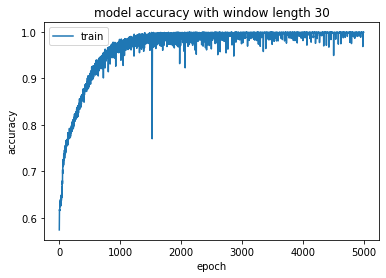

In [43]:
plt.plot(train_accs)
plt.title('model accuracy with window length 30')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [44]:
plt.plot(train_losses)
plt.title('model loss with window length 30')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [45]:
third_model.reset_states()
test_results = calc_pos_neg_rate(third_model.evaluate(x=test_generator, verbose=0))

In [46]:
third_model.reset_states()
train_results = calc_pos_neg_rate(third_model.evaluate(x=train_generator, verbose=0))

In [47]:
tabular_test_train_results(train_generator, test_generator, train_results, test_results)

Let's save this model for further use.

In [48]:
third_model.save(join(COLAB_DIR,'model_stateful_30.h5'))

**Sounds like model is still instable due to variable metric values. Therefore, let's increase the number of epochs to 10000.**

Let's train the model again for 10000 epochs with window length of 10.

In [21]:
epochs = 10000

In [29]:
train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_max_trading_days, \
                                                              training_start, training_end, testing_start, \
                                                              testing_end)

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
super_expert_model = build_model(None, optimizer, layers, metrics=metrics)
super_expert_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (32, 64)                  17920     
_________________________________________________________________
dense_4 (Dense)              (32, 32)                  2080      
_________________________________________________________________
dropout_1 (Dropout)          (32, 32)                  0         
_________________________________________________________________
dense_5 (Dense)              (32, 16)                  528       
_________________________________________________________________
batch_normalization_1 (Batch (32, 16)                  64        
_________________________________________________________________
dense_6 (Dense)              (32, 4)                   68        
_________________________________________________________________
dense_7 (Dense)              (32, 1)                  

In [30]:
train_accs, train_losses = fit(super_expert_model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   1.694 seconds , loss : 0.701    accuracy : 0.576    
epoch 2
----------->> Epoch 1/1   0.228 seconds , loss : 0.674    accuracy : 0.609    
epoch 3
----------->> Epoch 1/1   0.277 seconds , loss : 0.670    accuracy : 0.615    
epoch 4
----------->> Epoch 1/1   0.230 seconds , loss : 0.668    accuracy : 0.615    
epoch 5
----------->> Epoch 1/1   0.219 seconds , loss : 0.668    accuracy : 0.616    
epoch 6
----------->> Epoch 1/1   0.224 seconds , loss : 0.668    accuracy : 0.619    
epoch 7
----------->> Epoch 1/1   0.260 seconds , loss : 0.669    accuracy : 0.616    
epoch 8
----------->> Epoch 1/1   0.368 seconds , loss : 0.663    accuracy : 0.617    
epoch 9
----------->> Epoch 1/1   0.330 seconds , loss : 0.662    accuracy : 0.612    
epoch 10
----------->> Epoch 1/1   0.307 seconds , loss : 0.655    accuracy : 0.617    
epoch 11
----------->> Epoch 1/1   0.312 seconds , loss : 0.659    accuracy : 0.617    
epoch 12
----------->> Epoch 1/1   0.316 

----------->> Epoch 1/1   0.224 seconds , loss : 0.511    accuracy : 0.763    
epoch 187
----------->> Epoch 1/1   0.232 seconds , loss : 0.509    accuracy : 0.768    
epoch 188
----------->> Epoch 1/1   0.233 seconds , loss : 0.507    accuracy : 0.763    
epoch 189
----------->> Epoch 1/1   0.227 seconds , loss : 0.506    accuracy : 0.764    
epoch 190
----------->> Epoch 1/1   0.227 seconds , loss : 0.512    accuracy : 0.765    
epoch 191
----------->> Epoch 1/1   0.225 seconds , loss : 0.509    accuracy : 0.759    
epoch 192
----------->> Epoch 1/1   0.268 seconds , loss : 0.510    accuracy : 0.768    
epoch 193
----------->> Epoch 1/1   0.229 seconds , loss : 0.512    accuracy : 0.757    
epoch 194
----------->> Epoch 1/1   0.226 seconds , loss : 0.506    accuracy : 0.769    
epoch 195
----------->> Epoch 1/1   0.240 seconds , loss : 0.510    accuracy : 0.770    
epoch 196
----------->> Epoch 1/1   0.238 seconds , loss : 0.503    accuracy : 0.771    
epoch 197
----------->> Epoch 1

----------->> Epoch 1/1   0.272 seconds , loss : 0.445    accuracy : 0.810    
epoch 371
----------->> Epoch 1/1   0.269 seconds , loss : 0.452    accuracy : 0.791    
epoch 372
----------->> Epoch 1/1   0.280 seconds , loss : 0.446    accuracy : 0.806    
epoch 373
----------->> Epoch 1/1   0.273 seconds , loss : 0.440    accuracy : 0.801    
epoch 374
----------->> Epoch 1/1   0.265 seconds , loss : 0.438    accuracy : 0.808    
epoch 375
----------->> Epoch 1/1   0.266 seconds , loss : 0.452    accuracy : 0.797    
epoch 376
----------->> Epoch 1/1   0.265 seconds , loss : 0.438    accuracy : 0.800    
epoch 377
----------->> Epoch 1/1   0.269 seconds , loss : 0.453    accuracy : 0.804    
epoch 378
----------->> Epoch 1/1   0.275 seconds , loss : 0.461    accuracy : 0.799    
epoch 379
----------->> Epoch 1/1   0.270 seconds , loss : 0.436    accuracy : 0.812    
epoch 380
----------->> Epoch 1/1   0.271 seconds , loss : 0.442    accuracy : 0.804    
epoch 381
----------->> Epoch 1

----------->> Epoch 1/1   0.269 seconds , loss : 0.380    accuracy : 0.845    
epoch 555
----------->> Epoch 1/1   0.272 seconds , loss : 0.373    accuracy : 0.845    
epoch 556
----------->> Epoch 1/1   0.260 seconds , loss : 0.368    accuracy : 0.844    
epoch 557
----------->> Epoch 1/1   0.271 seconds , loss : 0.376    accuracy : 0.842    
epoch 558
----------->> Epoch 1/1   0.261 seconds , loss : 0.380    accuracy : 0.845    
epoch 559
----------->> Epoch 1/1   0.267 seconds , loss : 0.373    accuracy : 0.842    
epoch 560
----------->> Epoch 1/1   0.267 seconds , loss : 0.367    accuracy : 0.842    
epoch 561
----------->> Epoch 1/1   0.270 seconds , loss : 0.383    accuracy : 0.832    
epoch 562
----------->> Epoch 1/1   0.267 seconds , loss : 0.379    accuracy : 0.836    
epoch 563
----------->> Epoch 1/1   0.262 seconds , loss : 0.366    accuracy : 0.849    
epoch 564
----------->> Epoch 1/1   0.268 seconds , loss : 0.359    accuracy : 0.853    
epoch 565
----------->> Epoch 1

----------->> Epoch 1/1   0.247 seconds , loss : 0.279    accuracy : 0.893    
epoch 739
----------->> Epoch 1/1   0.236 seconds , loss : 0.291    accuracy : 0.894    
epoch 740
----------->> Epoch 1/1   0.293 seconds , loss : 0.302    accuracy : 0.885    
epoch 741
----------->> Epoch 1/1   0.249 seconds , loss : 0.295    accuracy : 0.879    
epoch 742
----------->> Epoch 1/1   0.291 seconds , loss : 0.291    accuracy : 0.884    
epoch 743
----------->> Epoch 1/1   0.305 seconds , loss : 0.291    accuracy : 0.891    
epoch 744
----------->> Epoch 1/1   0.258 seconds , loss : 0.285    accuracy : 0.888    
epoch 745
----------->> Epoch 1/1   0.237 seconds , loss : 0.293    accuracy : 0.882    
epoch 746
----------->> Epoch 1/1   0.296 seconds , loss : 0.285    accuracy : 0.886    
epoch 747
----------->> Epoch 1/1   0.239 seconds , loss : 0.277    accuracy : 0.891    
epoch 748
----------->> Epoch 1/1   0.235 seconds , loss : 0.279    accuracy : 0.892    
epoch 749
----------->> Epoch 1

----------->> Epoch 1/1   0.284 seconds , loss : 0.223    accuracy : 0.920    
epoch 923
----------->> Epoch 1/1   0.272 seconds , loss : 0.223    accuracy : 0.920    
epoch 924
----------->> Epoch 1/1   0.297 seconds , loss : 0.232    accuracy : 0.914    
epoch 925
----------->> Epoch 1/1   0.290 seconds , loss : 0.230    accuracy : 0.919    
epoch 926
----------->> Epoch 1/1   0.298 seconds , loss : 0.220    accuracy : 0.919    
epoch 927
----------->> Epoch 1/1   0.302 seconds , loss : 0.233    accuracy : 0.912    
epoch 928
----------->> Epoch 1/1   0.290 seconds , loss : 0.229    accuracy : 0.915    
epoch 929
----------->> Epoch 1/1   0.341 seconds , loss : 0.220    accuracy : 0.916    
epoch 930
----------->> Epoch 1/1   0.308 seconds , loss : 0.218    accuracy : 0.926    
epoch 931
----------->> Epoch 1/1   0.298 seconds , loss : 0.226    accuracy : 0.923    
epoch 932
----------->> Epoch 1/1   0.300 seconds , loss : 0.235    accuracy : 0.917    
epoch 933
----------->> Epoch 1

----------->> Epoch 1/1   0.317 seconds , loss : 0.201    accuracy : 0.928    
epoch 1015
----------->> Epoch 1/1   0.302 seconds , loss : 0.188    accuracy : 0.930    
epoch 1016
----------->> Epoch 1/1   0.303 seconds , loss : 0.199    accuracy : 0.929    
epoch 1017
----------->> Epoch 1/1   0.346 seconds , loss : 0.182    accuracy : 0.939    
epoch 1018
----------->> Epoch 1/1   0.310 seconds , loss : 0.203    accuracy : 0.926    
epoch 1019
----------->> Epoch 1/1   0.304 seconds , loss : 0.199    accuracy : 0.926    
epoch 1020
----------->> Epoch 1/1   0.281 seconds , loss : 0.189    accuracy : 0.940    
epoch 1021
----------->> Epoch 1/1   0.298 seconds , loss : 0.199    accuracy : 0.926    
epoch 1022
----------->> Epoch 1/1   0.262 seconds , loss : 0.209    accuracy : 0.932    
epoch 1023
----------->> Epoch 1/1   0.259 seconds , loss : 0.199    accuracy : 0.931    
epoch 1024
----------->> Epoch 1/1   0.258 seconds , loss : 0.206    accuracy : 0.923    
epoch 1025
----------

----------->> Epoch 1/1   0.308 seconds , loss : 0.184    accuracy : 0.932    
epoch 1197
----------->> Epoch 1/1   0.357 seconds , loss : 0.183    accuracy : 0.941    
epoch 1198
----------->> Epoch 1/1   0.289 seconds , loss : 0.160    accuracy : 0.945    
epoch 1199
----------->> Epoch 1/1   0.261 seconds , loss : 0.165    accuracy : 0.940    
epoch 1200
----------->> Epoch 1/1   0.258 seconds , loss : 0.172    accuracy : 0.946    
epoch 1201
----------->> Epoch 1/1   0.256 seconds , loss : 0.169    accuracy : 0.938    
epoch 1202
----------->> Epoch 1/1   0.304 seconds , loss : 0.167    accuracy : 0.944    
epoch 1203
----------->> Epoch 1/1   0.330 seconds , loss : 0.151    accuracy : 0.951    
epoch 1204
----------->> Epoch 1/1   0.296 seconds , loss : 0.155    accuracy : 0.947    
epoch 1205
----------->> Epoch 1/1   0.274 seconds , loss : 0.161    accuracy : 0.947    
epoch 1206
----------->> Epoch 1/1   0.262 seconds , loss : 0.165    accuracy : 0.945    
epoch 1207
----------

----------->> Epoch 1/1   0.232 seconds , loss : 0.128    accuracy : 0.955    
epoch 1379
----------->> Epoch 1/1   0.259 seconds , loss : 0.159    accuracy : 0.945    
epoch 1380
----------->> Epoch 1/1   0.250 seconds , loss : 0.197    accuracy : 0.935    
epoch 1381
----------->> Epoch 1/1   0.238 seconds , loss : 0.120    accuracy : 0.963    
epoch 1382
----------->> Epoch 1/1   0.239 seconds , loss : 0.122    accuracy : 0.956    
epoch 1383
----------->> Epoch 1/1   0.238 seconds , loss : 0.130    accuracy : 0.955    
epoch 1384
----------->> Epoch 1/1   0.246 seconds , loss : 0.122    accuracy : 0.959    
epoch 1385
----------->> Epoch 1/1   0.266 seconds , loss : 0.139    accuracy : 0.949    
epoch 1386
----------->> Epoch 1/1   0.245 seconds , loss : 0.120    accuracy : 0.957    
epoch 1387
----------->> Epoch 1/1   0.256 seconds , loss : 0.120    accuracy : 0.961    
epoch 1388
----------->> Epoch 1/1   0.237 seconds , loss : 0.118    accuracy : 0.963    
epoch 1389
----------

----------->> Epoch 1/1   0.236 seconds , loss : 0.108    accuracy : 0.965    
epoch 1561
----------->> Epoch 1/1   0.234 seconds , loss : 0.110    accuracy : 0.962    
epoch 1562
----------->> Epoch 1/1   0.231 seconds , loss : 0.118    accuracy : 0.963    
epoch 1563
----------->> Epoch 1/1   0.265 seconds , loss : 0.123    accuracy : 0.960    
epoch 1564
----------->> Epoch 1/1   0.317 seconds , loss : 0.104    accuracy : 0.970    
epoch 1565
----------->> Epoch 1/1   0.236 seconds , loss : 0.102    accuracy : 0.967    
epoch 1566
----------->> Epoch 1/1   0.226 seconds , loss : 0.092    accuracy : 0.972    
epoch 1567
----------->> Epoch 1/1   0.233 seconds , loss : 0.097    accuracy : 0.971    
epoch 1568
----------->> Epoch 1/1   0.217 seconds , loss : 0.093    accuracy : 0.971    
epoch 1569
----------->> Epoch 1/1   0.228 seconds , loss : 0.102    accuracy : 0.966    
epoch 1570
----------->> Epoch 1/1   0.230 seconds , loss : 0.119    accuracy : 0.966    
epoch 1571
----------

----------->> Epoch 1/1   0.233 seconds , loss : 0.095    accuracy : 0.967    
epoch 1743
----------->> Epoch 1/1   0.235 seconds , loss : 0.128    accuracy : 0.955    
epoch 1744
----------->> Epoch 1/1   0.232 seconds , loss : 0.121    accuracy : 0.958    
epoch 1745
----------->> Epoch 1/1   0.236 seconds , loss : 0.103    accuracy : 0.966    
epoch 1746
----------->> Epoch 1/1   0.234 seconds , loss : 0.110    accuracy : 0.964    
epoch 1747
----------->> Epoch 1/1   0.228 seconds , loss : 0.096    accuracy : 0.973    
epoch 1748
----------->> Epoch 1/1   0.236 seconds , loss : 0.095    accuracy : 0.969    
epoch 1749
----------->> Epoch 1/1   0.233 seconds , loss : 0.098    accuracy : 0.971    
epoch 1750
----------->> Epoch 1/1   0.237 seconds , loss : 0.093    accuracy : 0.973    
epoch 1751
----------->> Epoch 1/1   0.233 seconds , loss : 0.091    accuracy : 0.970    
epoch 1752
----------->> Epoch 1/1   0.232 seconds , loss : 0.127    accuracy : 0.960    
epoch 1753
----------

----------->> Epoch 1/1   0.236 seconds , loss : 0.094    accuracy : 0.971    
epoch 1925
----------->> Epoch 1/1   0.235 seconds , loss : 0.087    accuracy : 0.978    
epoch 1926
----------->> Epoch 1/1   0.237 seconds , loss : 0.085    accuracy : 0.976    
epoch 1927
----------->> Epoch 1/1   0.233 seconds , loss : 0.081    accuracy : 0.978    
epoch 1928
----------->> Epoch 1/1   0.236 seconds , loss : 0.088    accuracy : 0.975    
epoch 1929
----------->> Epoch 1/1   0.232 seconds , loss : 0.103    accuracy : 0.967    
epoch 1930
----------->> Epoch 1/1   0.236 seconds , loss : 0.086    accuracy : 0.973    
epoch 1931
----------->> Epoch 1/1   0.231 seconds , loss : 0.077    accuracy : 0.978    
epoch 1932
----------->> Epoch 1/1   0.237 seconds , loss : 0.092    accuracy : 0.969    
epoch 1933
----------->> Epoch 1/1   0.231 seconds , loss : 0.087    accuracy : 0.970    
epoch 1934
----------->> Epoch 1/1   0.237 seconds , loss : 0.081    accuracy : 0.976    
epoch 1935
----------

----------->> Epoch 1/1   0.235 seconds , loss : 0.070    accuracy : 0.979    
epoch 2107
----------->> Epoch 1/1   0.235 seconds , loss : 0.085    accuracy : 0.974    
epoch 2108
----------->> Epoch 1/1   0.279 seconds , loss : 0.113    accuracy : 0.959    
epoch 2109
----------->> Epoch 1/1   0.251 seconds , loss : 0.118    accuracy : 0.962    
epoch 2110
----------->> Epoch 1/1   0.236 seconds , loss : 0.078    accuracy : 0.979    
epoch 2111
----------->> Epoch 1/1   0.230 seconds , loss : 0.074    accuracy : 0.977    
epoch 2112
----------->> Epoch 1/1   0.235 seconds , loss : 0.079    accuracy : 0.975    
epoch 2113
----------->> Epoch 1/1   0.232 seconds , loss : 0.074    accuracy : 0.976    
epoch 2114
----------->> Epoch 1/1   0.249 seconds , loss : 0.077    accuracy : 0.977    
epoch 2115
----------->> Epoch 1/1   0.248 seconds , loss : 0.084    accuracy : 0.975    
epoch 2116
----------->> Epoch 1/1   0.232 seconds , loss : 0.094    accuracy : 0.967    
epoch 2117
----------

----------->> Epoch 1/1   0.254 seconds , loss : 0.095    accuracy : 0.972    
epoch 2289
----------->> Epoch 1/1   0.260 seconds , loss : 0.096    accuracy : 0.970    
epoch 2290
----------->> Epoch 1/1   0.278 seconds , loss : 0.069    accuracy : 0.979    
epoch 2291
----------->> Epoch 1/1   0.282 seconds , loss : 0.064    accuracy : 0.981    
epoch 2292
----------->> Epoch 1/1   0.278 seconds , loss : 0.067    accuracy : 0.982    
epoch 2293
----------->> Epoch 1/1   0.289 seconds , loss : 0.062    accuracy : 0.980    
epoch 2294
----------->> Epoch 1/1   0.280 seconds , loss : 0.066    accuracy : 0.980    
epoch 2295
----------->> Epoch 1/1   0.276 seconds , loss : 0.069    accuracy : 0.983    
epoch 2296
----------->> Epoch 1/1   0.274 seconds , loss : 0.085    accuracy : 0.972    
epoch 2297
----------->> Epoch 1/1   0.352 seconds , loss : 0.066    accuracy : 0.980    
epoch 2298
----------->> Epoch 1/1   0.345 seconds , loss : 0.055    accuracy : 0.983    
epoch 2299
----------

----------->> Epoch 1/1   0.262 seconds , loss : 0.054    accuracy : 0.984    
epoch 2471
----------->> Epoch 1/1   0.261 seconds , loss : 0.049    accuracy : 0.986    
epoch 2472
----------->> Epoch 1/1   0.268 seconds , loss : 0.054    accuracy : 0.983    
epoch 2473
----------->> Epoch 1/1   0.264 seconds , loss : 0.084    accuracy : 0.977    
epoch 2474
----------->> Epoch 1/1   0.266 seconds , loss : 0.058    accuracy : 0.981    
epoch 2475
----------->> Epoch 1/1   0.264 seconds , loss : 0.071    accuracy : 0.979    
epoch 2476
----------->> Epoch 1/1   0.275 seconds , loss : 0.057    accuracy : 0.983    
epoch 2477
----------->> Epoch 1/1   0.273 seconds , loss : 0.058    accuracy : 0.981    
epoch 2478
----------->> Epoch 1/1   0.257 seconds , loss : 0.063    accuracy : 0.982    
epoch 2479
----------->> Epoch 1/1   0.257 seconds , loss : 0.054    accuracy : 0.984    
epoch 2480
----------->> Epoch 1/1   0.279 seconds , loss : 0.058    accuracy : 0.985    
epoch 2481
----------

----------->> Epoch 1/1   0.264 seconds , loss : 0.059    accuracy : 0.979    
epoch 2653
----------->> Epoch 1/1   0.263 seconds , loss : 0.051    accuracy : 0.985    
epoch 2654
----------->> Epoch 1/1   0.260 seconds , loss : 0.059    accuracy : 0.982    
epoch 2655
----------->> Epoch 1/1   0.262 seconds , loss : 0.059    accuracy : 0.982    
epoch 2656
----------->> Epoch 1/1   0.270 seconds , loss : 0.057    accuracy : 0.982    
epoch 2657
----------->> Epoch 1/1   0.262 seconds , loss : 0.066    accuracy : 0.987    
epoch 2658
----------->> Epoch 1/1   0.267 seconds , loss : 0.077    accuracy : 0.979    
epoch 2659
----------->> Epoch 1/1   0.261 seconds , loss : 0.056    accuracy : 0.981    
epoch 2660
----------->> Epoch 1/1   0.257 seconds , loss : 0.043    accuracy : 0.988    
epoch 2661
----------->> Epoch 1/1   0.256 seconds , loss : 0.051    accuracy : 0.984    
epoch 2662
----------->> Epoch 1/1   0.260 seconds , loss : 0.042    accuracy : 0.990    
epoch 2663
----------

----------->> Epoch 1/1   0.277 seconds , loss : 0.064    accuracy : 0.980    
epoch 2835
----------->> Epoch 1/1   0.278 seconds , loss : 0.046    accuracy : 0.989    
epoch 2836
----------->> Epoch 1/1   0.270 seconds , loss : 0.035    accuracy : 0.992    
epoch 2837
----------->> Epoch 1/1   0.270 seconds , loss : 0.059    accuracy : 0.982    
epoch 2838
----------->> Epoch 1/1   0.277 seconds , loss : 0.053    accuracy : 0.988    
epoch 2839
----------->> Epoch 1/1   0.316 seconds , loss : 0.044    accuracy : 0.987    
epoch 2840
----------->> Epoch 1/1   0.267 seconds , loss : 0.054    accuracy : 0.985    
epoch 2841
----------->> Epoch 1/1   0.258 seconds , loss : 0.084    accuracy : 0.969    
epoch 2842
----------->> Epoch 1/1   0.255 seconds , loss : 0.052    accuracy : 0.986    
epoch 2843
----------->> Epoch 1/1   0.283 seconds , loss : 0.057    accuracy : 0.981    
epoch 2844
----------->> Epoch 1/1   0.291 seconds , loss : 0.040    accuracy : 0.988    
epoch 2845
----------

----------->> Epoch 1/1   0.241 seconds , loss : 0.052    accuracy : 0.986    
epoch 3017
----------->> Epoch 1/1   0.247 seconds , loss : 0.072    accuracy : 0.981    
epoch 3018
----------->> Epoch 1/1   0.231 seconds , loss : 0.040    accuracy : 0.987    
epoch 3019
----------->> Epoch 1/1   0.238 seconds , loss : 0.055    accuracy : 0.980    
epoch 3020
----------->> Epoch 1/1   0.239 seconds , loss : 0.054    accuracy : 0.987    
epoch 3021
----------->> Epoch 1/1   0.258 seconds , loss : 0.051    accuracy : 0.989    
epoch 3022
----------->> Epoch 1/1   0.235 seconds , loss : 0.069    accuracy : 0.980    
epoch 3023
----------->> Epoch 1/1   0.239 seconds , loss : 0.039    accuracy : 0.988    
epoch 3024
----------->> Epoch 1/1   0.235 seconds , loss : 0.042    accuracy : 0.987    
epoch 3025
----------->> Epoch 1/1   0.234 seconds , loss : 0.055    accuracy : 0.983    
epoch 3026
----------->> Epoch 1/1   0.239 seconds , loss : 0.046    accuracy : 0.987    
epoch 3027
----------

----------->> Epoch 1/1   0.233 seconds , loss : 0.043    accuracy : 0.985    
epoch 3199
----------->> Epoch 1/1   0.235 seconds , loss : 0.047    accuracy : 0.984    
epoch 3200
----------->> Epoch 1/1   0.232 seconds , loss : 0.036    accuracy : 0.989    
epoch 3201
----------->> Epoch 1/1   0.236 seconds , loss : 0.032    accuracy : 0.988    
epoch 3202
----------->> Epoch 1/1   0.231 seconds , loss : 0.047    accuracy : 0.984    
epoch 3203
----------->> Epoch 1/1   0.233 seconds , loss : 0.042    accuracy : 0.988    
epoch 3204
----------->> Epoch 1/1   0.235 seconds , loss : 0.038    accuracy : 0.988    
epoch 3205
----------->> Epoch 1/1   0.236 seconds , loss : 0.038    accuracy : 0.987    
epoch 3206
----------->> Epoch 1/1   0.230 seconds , loss : 0.032    accuracy : 0.990    
epoch 3207
----------->> Epoch 1/1   0.236 seconds , loss : 0.042    accuracy : 0.988    
epoch 3208
----------->> Epoch 1/1   0.236 seconds , loss : 0.026    accuracy : 0.994    
epoch 3209
----------

----------->> Epoch 1/1   0.237 seconds , loss : 0.038    accuracy : 0.988    
epoch 3381
----------->> Epoch 1/1   0.233 seconds , loss : 0.029    accuracy : 0.992    
epoch 3382
----------->> Epoch 1/1   0.234 seconds , loss : 0.035    accuracy : 0.989    
epoch 3383
----------->> Epoch 1/1   0.236 seconds , loss : 0.033    accuracy : 0.991    
epoch 3384
----------->> Epoch 1/1   0.231 seconds , loss : 0.038    accuracy : 0.988    
epoch 3385
----------->> Epoch 1/1   0.238 seconds , loss : 0.041    accuracy : 0.986    
epoch 3386
----------->> Epoch 1/1   0.231 seconds , loss : 0.065    accuracy : 0.984    
epoch 3387
----------->> Epoch 1/1   0.236 seconds , loss : 0.042    accuracy : 0.990    
epoch 3388
----------->> Epoch 1/1   0.231 seconds , loss : 0.038    accuracy : 0.989    
epoch 3389
----------->> Epoch 1/1   0.236 seconds , loss : 0.032    accuracy : 0.990    
epoch 3390
----------->> Epoch 1/1   0.233 seconds , loss : 0.029    accuracy : 0.992    
epoch 3391
----------

----------->> Epoch 1/1   0.231 seconds , loss : 0.023    accuracy : 0.992    
epoch 3563
----------->> Epoch 1/1   0.239 seconds , loss : 0.020    accuracy : 0.994    
epoch 3564
----------->> Epoch 1/1   0.230 seconds , loss : 0.032    accuracy : 0.990    
epoch 3565
----------->> Epoch 1/1   0.236 seconds , loss : 0.038    accuracy : 0.987    
epoch 3566
----------->> Epoch 1/1   0.232 seconds , loss : 0.052    accuracy : 0.985    
epoch 3567
----------->> Epoch 1/1   0.236 seconds , loss : 0.041    accuracy : 0.984    
epoch 3568
----------->> Epoch 1/1   0.230 seconds , loss : 0.037    accuracy : 0.988    
epoch 3569
----------->> Epoch 1/1   0.241 seconds , loss : 0.031    accuracy : 0.990    
epoch 3570
----------->> Epoch 1/1   0.229 seconds , loss : 0.035    accuracy : 0.988    
epoch 3571
----------->> Epoch 1/1   0.232 seconds , loss : 0.032    accuracy : 0.991    
epoch 3572
----------->> Epoch 1/1   0.235 seconds , loss : 0.026    accuracy : 0.991    
epoch 3573
----------

----------->> Epoch 1/1   0.232 seconds , loss : 0.044    accuracy : 0.988    
epoch 3745
----------->> Epoch 1/1   0.238 seconds , loss : 0.029    accuracy : 0.991    
epoch 3746
----------->> Epoch 1/1   0.234 seconds , loss : 0.023    accuracy : 0.993    
epoch 3747
----------->> Epoch 1/1   0.239 seconds , loss : 0.029    accuracy : 0.992    
epoch 3748
----------->> Epoch 1/1   0.232 seconds , loss : 0.017    accuracy : 0.994    
epoch 3749
----------->> Epoch 1/1   0.236 seconds , loss : 0.026    accuracy : 0.993    
epoch 3750
----------->> Epoch 1/1   0.234 seconds , loss : 0.037    accuracy : 0.989    
epoch 3751
----------->> Epoch 1/1   0.236 seconds , loss : 0.034    accuracy : 0.988    
epoch 3752
----------->> Epoch 1/1   0.233 seconds , loss : 0.077    accuracy : 0.978    
epoch 3753
----------->> Epoch 1/1   0.232 seconds , loss : 0.038    accuracy : 0.988    
epoch 3754
----------->> Epoch 1/1   0.234 seconds , loss : 0.024    accuracy : 0.993    
epoch 3755
----------

----------->> Epoch 1/1   0.236 seconds , loss : 0.021    accuracy : 0.994    
epoch 3927
----------->> Epoch 1/1   0.232 seconds , loss : 0.046    accuracy : 0.987    
epoch 3928
----------->> Epoch 1/1   0.235 seconds , loss : 0.024    accuracy : 0.992    
epoch 3929
----------->> Epoch 1/1   0.234 seconds , loss : 0.020    accuracy : 0.994    
epoch 3930
----------->> Epoch 1/1   0.236 seconds , loss : 0.070    accuracy : 0.979    
epoch 3931
----------->> Epoch 1/1   0.229 seconds , loss : 0.029    accuracy : 0.992    
epoch 3932
----------->> Epoch 1/1   0.236 seconds , loss : 0.034    accuracy : 0.990    
epoch 3933
----------->> Epoch 1/1   0.232 seconds , loss : 0.025    accuracy : 0.992    
epoch 3934
----------->> Epoch 1/1   0.235 seconds , loss : 0.023    accuracy : 0.993    
epoch 3935
----------->> Epoch 1/1   0.231 seconds , loss : 0.022    accuracy : 0.993    
epoch 3936
----------->> Epoch 1/1   0.237 seconds , loss : 0.019    accuracy : 0.995    
epoch 3937
----------

----------->> Epoch 1/1   0.229 seconds , loss : 0.022    accuracy : 0.993    
epoch 4109
----------->> Epoch 1/1   0.236 seconds , loss : 0.034    accuracy : 0.989    
epoch 4110
----------->> Epoch 1/1   0.228 seconds , loss : 0.044    accuracy : 0.988    
epoch 4111
----------->> Epoch 1/1   0.237 seconds , loss : 0.027    accuracy : 0.990    
epoch 4112
----------->> Epoch 1/1   0.235 seconds , loss : 0.029    accuracy : 0.991    
epoch 4113
----------->> Epoch 1/1   0.238 seconds , loss : 0.049    accuracy : 0.987    
epoch 4114
----------->> Epoch 1/1   0.231 seconds , loss : 0.084    accuracy : 0.980    
epoch 4115
----------->> Epoch 1/1   0.238 seconds , loss : 0.033    accuracy : 0.988    
epoch 4116
----------->> Epoch 1/1   0.230 seconds , loss : 0.035    accuracy : 0.989    
epoch 4117
----------->> Epoch 1/1   0.235 seconds , loss : 0.024    accuracy : 0.993    
epoch 4118
----------->> Epoch 1/1   0.231 seconds , loss : 0.020    accuracy : 0.995    
epoch 4119
----------

----------->> Epoch 1/1   0.238 seconds , loss : 0.014    accuracy : 0.996    
epoch 4291
----------->> Epoch 1/1   0.229 seconds , loss : 0.033    accuracy : 0.992    
epoch 4292
----------->> Epoch 1/1   0.236 seconds , loss : 0.024    accuracy : 0.994    
epoch 4293
----------->> Epoch 1/1   0.231 seconds , loss : 0.017    accuracy : 0.996    
epoch 4294
----------->> Epoch 1/1   0.236 seconds , loss : 0.022    accuracy : 0.993    
epoch 4295
----------->> Epoch 1/1   0.231 seconds , loss : 0.022    accuracy : 0.991    
epoch 4296
----------->> Epoch 1/1   0.237 seconds , loss : 0.021    accuracy : 0.994    
epoch 4297
----------->> Epoch 1/1   0.232 seconds , loss : 0.024    accuracy : 0.993    
epoch 4298
----------->> Epoch 1/1   0.234 seconds , loss : 0.025    accuracy : 0.993    
epoch 4299
----------->> Epoch 1/1   0.235 seconds , loss : 0.028    accuracy : 0.988    
epoch 4300
----------->> Epoch 1/1   0.235 seconds , loss : 0.041    accuracy : 0.987    
epoch 4301
----------

----------->> Epoch 1/1   0.240 seconds , loss : 0.016    accuracy : 0.995    
epoch 4473
----------->> Epoch 1/1   0.231 seconds , loss : 0.018    accuracy : 0.994    
epoch 4474
----------->> Epoch 1/1   0.238 seconds , loss : 0.015    accuracy : 0.996    
epoch 4475
----------->> Epoch 1/1   0.231 seconds , loss : 0.019    accuracy : 0.996    
epoch 4476
----------->> Epoch 1/1   0.234 seconds , loss : 0.051    accuracy : 0.987    
epoch 4477
----------->> Epoch 1/1   0.229 seconds , loss : 0.046    accuracy : 0.988    
epoch 4478
----------->> Epoch 1/1   0.238 seconds , loss : 0.022    accuracy : 0.993    
epoch 4479
----------->> Epoch 1/1   0.233 seconds , loss : 0.021    accuracy : 0.994    
epoch 4480
----------->> Epoch 1/1   0.236 seconds , loss : 0.024    accuracy : 0.994    
epoch 4481
----------->> Epoch 1/1   0.232 seconds , loss : 0.017    accuracy : 0.993    
epoch 4482
----------->> Epoch 1/1   0.239 seconds , loss : 0.018    accuracy : 0.995    
epoch 4483
----------

----------->> Epoch 1/1   0.236 seconds , loss : 0.011    accuracy : 0.997    
epoch 4655
----------->> Epoch 1/1   0.233 seconds , loss : 0.011    accuracy : 0.997    
epoch 4656
----------->> Epoch 1/1   0.233 seconds , loss : 0.014    accuracy : 0.996    
epoch 4657
----------->> Epoch 1/1   0.234 seconds , loss : 0.014    accuracy : 0.997    
epoch 4658
----------->> Epoch 1/1   0.235 seconds , loss : 0.015    accuracy : 0.996    
epoch 4659
----------->> Epoch 1/1   0.232 seconds , loss : 0.013    accuracy : 0.997    
epoch 4660
----------->> Epoch 1/1   0.236 seconds , loss : 0.013    accuracy : 0.997    
epoch 4661
----------->> Epoch 1/1   0.229 seconds , loss : 0.015    accuracy : 0.997    
epoch 4662
----------->> Epoch 1/1   0.238 seconds , loss : 0.017    accuracy : 0.994    
epoch 4663
----------->> Epoch 1/1   0.231 seconds , loss : 0.011    accuracy : 0.997    
epoch 4664
----------->> Epoch 1/1   0.236 seconds , loss : 0.013    accuracy : 0.997    
epoch 4665
----------

----------->> Epoch 1/1   0.232 seconds , loss : 0.016    accuracy : 0.994    
epoch 4837
----------->> Epoch 1/1   0.235 seconds , loss : 0.017    accuracy : 0.994    
epoch 4838
----------->> Epoch 1/1   0.232 seconds , loss : 0.016    accuracy : 0.995    
epoch 4839
----------->> Epoch 1/1   0.238 seconds , loss : 0.053    accuracy : 0.987    
epoch 4840
----------->> Epoch 1/1   0.232 seconds , loss : 0.033    accuracy : 0.992    
epoch 4841
----------->> Epoch 1/1   0.238 seconds , loss : 0.033    accuracy : 0.990    
epoch 4842
----------->> Epoch 1/1   0.235 seconds , loss : 0.032    accuracy : 0.988    
epoch 4843
----------->> Epoch 1/1   0.236 seconds , loss : 0.025    accuracy : 0.993    
epoch 4844
----------->> Epoch 1/1   0.233 seconds , loss : 0.032    accuracy : 0.992    
epoch 4845
----------->> Epoch 1/1   0.235 seconds , loss : 0.030    accuracy : 0.992    
epoch 4846
----------->> Epoch 1/1   0.232 seconds , loss : 0.035    accuracy : 0.992    
epoch 4847
----------

----------->> Epoch 1/1   0.241 seconds , loss : 0.014    accuracy : 0.997    
epoch 5019
----------->> Epoch 1/1   0.240 seconds , loss : 0.018    accuracy : 0.993    
epoch 5020
----------->> Epoch 1/1   0.247 seconds , loss : 0.085    accuracy : 0.981    
epoch 5021
----------->> Epoch 1/1   0.239 seconds , loss : 0.041    accuracy : 0.983    
epoch 5022
----------->> Epoch 1/1   0.255 seconds , loss : 0.041    accuracy : 0.987    
epoch 5023
----------->> Epoch 1/1   0.255 seconds , loss : 0.029    accuracy : 0.991    
epoch 5024
----------->> Epoch 1/1   0.258 seconds , loss : 0.021    accuracy : 0.993    
epoch 5025
----------->> Epoch 1/1   0.267 seconds , loss : 0.020    accuracy : 0.994    
epoch 5026
----------->> Epoch 1/1   0.261 seconds , loss : 0.015    accuracy : 0.996    
epoch 5027
----------->> Epoch 1/1   0.245 seconds , loss : 0.018    accuracy : 0.994    
epoch 5028
----------->> Epoch 1/1   0.235 seconds , loss : 0.029    accuracy : 0.990    
epoch 5029
----------

----------->> Epoch 1/1   0.293 seconds , loss : 0.047    accuracy : 0.988    
epoch 5201
----------->> Epoch 1/1   0.275 seconds , loss : 0.112    accuracy : 0.972    
epoch 5202
----------->> Epoch 1/1   0.328 seconds , loss : 0.041    accuracy : 0.988    
epoch 5203
----------->> Epoch 1/1   0.338 seconds , loss : 0.022    accuracy : 0.994    
epoch 5204
----------->> Epoch 1/1   0.256 seconds , loss : 0.020    accuracy : 0.995    
epoch 5205
----------->> Epoch 1/1   0.317 seconds , loss : 0.019    accuracy : 0.994    
epoch 5206
----------->> Epoch 1/1   0.316 seconds , loss : 0.017    accuracy : 0.996    
epoch 5207
----------->> Epoch 1/1   0.273 seconds , loss : 0.014    accuracy : 0.996    
epoch 5208
----------->> Epoch 1/1   0.269 seconds , loss : 0.013    accuracy : 0.996    
epoch 5209
----------->> Epoch 1/1   0.238 seconds , loss : 0.012    accuracy : 0.997    
epoch 5210
----------->> Epoch 1/1   0.240 seconds , loss : 0.011    accuracy : 0.997    
epoch 5211
----------

----------->> Epoch 1/1   0.259 seconds , loss : 0.087    accuracy : 0.978    
epoch 5383
----------->> Epoch 1/1   0.266 seconds , loss : 0.033    accuracy : 0.990    
epoch 5384
----------->> Epoch 1/1   0.268 seconds , loss : 0.026    accuracy : 0.991    
epoch 5385
----------->> Epoch 1/1   0.297 seconds , loss : 0.016    accuracy : 0.995    
epoch 5386
----------->> Epoch 1/1   0.270 seconds , loss : 0.011    accuracy : 0.996    
epoch 5387
----------->> Epoch 1/1   0.263 seconds , loss : 0.012    accuracy : 0.996    
epoch 5388
----------->> Epoch 1/1   0.269 seconds , loss : 0.010    accuracy : 0.997    
epoch 5389
----------->> Epoch 1/1   0.319 seconds , loss : 0.010    accuracy : 0.998    
epoch 5390
----------->> Epoch 1/1   0.264 seconds , loss : 0.011    accuracy : 0.997    
epoch 5391
----------->> Epoch 1/1   0.258 seconds , loss : 0.012    accuracy : 0.996    
epoch 5392
----------->> Epoch 1/1   0.262 seconds , loss : 0.010    accuracy : 0.996    
epoch 5393
----------

----------->> Epoch 1/1   0.240 seconds , loss : 0.012    accuracy : 0.996    
epoch 5565
----------->> Epoch 1/1   0.239 seconds , loss : 0.013    accuracy : 0.995    
epoch 5566
----------->> Epoch 1/1   0.240 seconds , loss : 0.011    accuracy : 0.996    
epoch 5567
----------->> Epoch 1/1   0.242 seconds , loss : 0.010    accuracy : 0.998    
epoch 5568
----------->> Epoch 1/1   0.243 seconds , loss : 0.012    accuracy : 0.996    
epoch 5569
----------->> Epoch 1/1   0.239 seconds , loss : 0.012    accuracy : 0.997    
epoch 5570
----------->> Epoch 1/1   0.269 seconds , loss : 0.008    accuracy : 0.998    
epoch 5571
----------->> Epoch 1/1   0.264 seconds , loss : 0.009    accuracy : 0.998    
epoch 5572
----------->> Epoch 1/1   0.241 seconds , loss : 0.008    accuracy : 0.998    
epoch 5573
----------->> Epoch 1/1   0.239 seconds , loss : 0.010    accuracy : 0.998    
epoch 5574
----------->> Epoch 1/1   0.238 seconds , loss : 0.007    accuracy : 0.998    
epoch 5575
----------

----------->> Epoch 1/1   0.224 seconds , loss : 0.013    accuracy : 0.997    
epoch 5747
----------->> Epoch 1/1   0.226 seconds , loss : 0.009    accuracy : 0.997    
epoch 5748
----------->> Epoch 1/1   0.228 seconds , loss : 0.009    accuracy : 0.998    
epoch 5749
----------->> Epoch 1/1   0.257 seconds , loss : 0.012    accuracy : 0.996    
epoch 5750
----------->> Epoch 1/1   0.256 seconds , loss : 0.021    accuracy : 0.994    
epoch 5751
----------->> Epoch 1/1   0.265 seconds , loss : 0.012    accuracy : 0.996    
epoch 5752
----------->> Epoch 1/1   0.252 seconds , loss : 0.009    accuracy : 0.997    
epoch 5753
----------->> Epoch 1/1   0.233 seconds , loss : 0.011    accuracy : 0.997    
epoch 5754
----------->> Epoch 1/1   0.238 seconds , loss : 0.012    accuracy : 0.997    
epoch 5755
----------->> Epoch 1/1   0.233 seconds , loss : 0.014    accuracy : 0.997    
epoch 5756
----------->> Epoch 1/1   0.229 seconds , loss : 0.011    accuracy : 0.997    
epoch 5757
----------

----------->> Epoch 1/1   0.358 seconds , loss : 0.020    accuracy : 0.995    
epoch 5929
----------->> Epoch 1/1   0.315 seconds , loss : 0.011    accuracy : 0.998    
epoch 5930
----------->> Epoch 1/1   0.247 seconds , loss : 0.053    accuracy : 0.986    
epoch 5931
----------->> Epoch 1/1   0.240 seconds , loss : 0.014    accuracy : 0.994    
epoch 5932
----------->> Epoch 1/1   0.236 seconds , loss : 0.014    accuracy : 0.996    
epoch 5933
----------->> Epoch 1/1   0.233 seconds , loss : 0.025    accuracy : 0.993    
epoch 5934
----------->> Epoch 1/1   0.227 seconds , loss : 0.025    accuracy : 0.993    
epoch 5935
----------->> Epoch 1/1   0.233 seconds , loss : 0.015    accuracy : 0.994    
epoch 5936
----------->> Epoch 1/1   0.228 seconds , loss : 0.014    accuracy : 0.995    
epoch 5937
----------->> Epoch 1/1   0.232 seconds , loss : 0.012    accuracy : 0.995    
epoch 5938
----------->> Epoch 1/1   0.228 seconds , loss : 0.009    accuracy : 0.998    
epoch 5939
----------

----------->> Epoch 1/1   0.249 seconds , loss : 0.015    accuracy : 0.996    
epoch 6111
----------->> Epoch 1/1   0.232 seconds , loss : 0.040    accuracy : 0.990    
epoch 6112
----------->> Epoch 1/1   0.262 seconds , loss : 0.030    accuracy : 0.991    
epoch 6113
----------->> Epoch 1/1   0.280 seconds , loss : 0.020    accuracy : 0.994    
epoch 6114
----------->> Epoch 1/1   0.309 seconds , loss : 0.014    accuracy : 0.995    
epoch 6115
----------->> Epoch 1/1   0.282 seconds , loss : 0.022    accuracy : 0.994    
epoch 6116
----------->> Epoch 1/1   0.286 seconds , loss : 0.043    accuracy : 0.987    
epoch 6117
----------->> Epoch 1/1   0.262 seconds , loss : 0.053    accuracy : 0.988    
epoch 6118
----------->> Epoch 1/1   0.238 seconds , loss : 0.030    accuracy : 0.995    
epoch 6119
----------->> Epoch 1/1   0.269 seconds , loss : 0.017    accuracy : 0.994    
epoch 6120
----------->> Epoch 1/1   0.233 seconds , loss : 0.013    accuracy : 0.997    
epoch 6121
----------

----------->> Epoch 1/1   0.274 seconds , loss : 0.011    accuracy : 0.997    
epoch 6293
----------->> Epoch 1/1   0.239 seconds , loss : 0.016    accuracy : 0.995    
epoch 6294
----------->> Epoch 1/1   0.312 seconds , loss : 0.029    accuracy : 0.992    
epoch 6295
----------->> Epoch 1/1   0.308 seconds , loss : 0.142    accuracy : 0.971    
epoch 6296
----------->> Epoch 1/1   0.246 seconds , loss : 0.038    accuracy : 0.986    
epoch 6297
----------->> Epoch 1/1   0.281 seconds , loss : 0.019    accuracy : 0.994    
epoch 6298
----------->> Epoch 1/1   0.228 seconds , loss : 0.018    accuracy : 0.996    
epoch 6299
----------->> Epoch 1/1   0.243 seconds , loss : 0.011    accuracy : 0.997    
epoch 6300
----------->> Epoch 1/1   0.264 seconds , loss : 0.014    accuracy : 0.995    
epoch 6301
----------->> Epoch 1/1   0.270 seconds , loss : 0.009    accuracy : 0.997    
epoch 6302
----------->> Epoch 1/1   0.231 seconds , loss : 0.011    accuracy : 0.997    
epoch 6303
----------

----------->> Epoch 1/1   0.249 seconds , loss : 0.016    accuracy : 0.995    
epoch 6475
----------->> Epoch 1/1   0.236 seconds , loss : 0.013    accuracy : 0.996    
epoch 6476
----------->> Epoch 1/1   0.233 seconds , loss : 0.009    accuracy : 0.998    
epoch 6477
----------->> Epoch 1/1   0.235 seconds , loss : 0.010    accuracy : 0.997    
epoch 6478
----------->> Epoch 1/1   0.230 seconds , loss : 0.010    accuracy : 0.998    
epoch 6479
----------->> Epoch 1/1   0.230 seconds , loss : 0.009    accuracy : 0.997    
epoch 6480
----------->> Epoch 1/1   0.228 seconds , loss : 0.010    accuracy : 0.997    
epoch 6481
----------->> Epoch 1/1   0.273 seconds , loss : 0.008    accuracy : 0.997    
epoch 6482
----------->> Epoch 1/1   0.263 seconds , loss : 0.008    accuracy : 0.998    
epoch 6483
----------->> Epoch 1/1   0.233 seconds , loss : 0.020    accuracy : 0.996    
epoch 6484
----------->> Epoch 1/1   0.282 seconds , loss : 0.038    accuracy : 0.990    
epoch 6485
----------

----------->> Epoch 1/1   0.232 seconds , loss : 0.025    accuracy : 0.992    
epoch 6657
----------->> Epoch 1/1   0.257 seconds , loss : 0.017    accuracy : 0.996    
epoch 6658
----------->> Epoch 1/1   0.232 seconds , loss : 0.023    accuracy : 0.994    
epoch 6659
----------->> Epoch 1/1   0.233 seconds , loss : 0.012    accuracy : 0.997    
epoch 6660
----------->> Epoch 1/1   0.230 seconds , loss : 0.015    accuracy : 0.995    
epoch 6661
----------->> Epoch 1/1   0.232 seconds , loss : 0.009    accuracy : 0.998    
epoch 6662
----------->> Epoch 1/1   0.228 seconds , loss : 0.007    accuracy : 0.998    
epoch 6663
----------->> Epoch 1/1   0.231 seconds , loss : 0.010    accuracy : 0.997    
epoch 6664
----------->> Epoch 1/1   0.245 seconds , loss : 0.007    accuracy : 0.998    
epoch 6665
----------->> Epoch 1/1   0.278 seconds , loss : 0.007    accuracy : 0.998    
epoch 6666
----------->> Epoch 1/1   0.229 seconds , loss : 0.008    accuracy : 0.999    
epoch 6667
----------

----------->> Epoch 1/1   0.245 seconds , loss : 0.006    accuracy : 0.998    
epoch 6839
----------->> Epoch 1/1   0.244 seconds , loss : 0.009    accuracy : 0.997    
epoch 6840
----------->> Epoch 1/1   0.258 seconds , loss : 0.007    accuracy : 0.998    
epoch 6841
----------->> Epoch 1/1   0.245 seconds , loss : 0.008    accuracy : 0.997    
epoch 6842
----------->> Epoch 1/1   0.233 seconds , loss : 0.009    accuracy : 0.997    
epoch 6843
----------->> Epoch 1/1   0.234 seconds , loss : 0.010    accuracy : 0.997    
epoch 6844
----------->> Epoch 1/1   0.235 seconds , loss : 0.009    accuracy : 0.997    
epoch 6845
----------->> Epoch 1/1   0.234 seconds , loss : 0.012    accuracy : 0.997    
epoch 6846
----------->> Epoch 1/1   0.231 seconds , loss : 0.008    accuracy : 0.997    
epoch 6847
----------->> Epoch 1/1   0.235 seconds , loss : 0.009    accuracy : 0.997    
epoch 6848
----------->> Epoch 1/1   0.229 seconds , loss : 0.009    accuracy : 0.997    
epoch 6849
----------

----------->> Epoch 1/1   0.229 seconds , loss : 0.008    accuracy : 0.997    
epoch 7021
----------->> Epoch 1/1   0.232 seconds , loss : 0.006    accuracy : 0.998    
epoch 7022
----------->> Epoch 1/1   0.248 seconds , loss : 0.013    accuracy : 0.997    
epoch 7023
----------->> Epoch 1/1   0.280 seconds , loss : 0.005    accuracy : 0.999    
epoch 7024
----------->> Epoch 1/1   0.233 seconds , loss : 0.008    accuracy : 0.998    
epoch 7025
----------->> Epoch 1/1   0.230 seconds , loss : 0.012    accuracy : 0.997    
epoch 7026
----------->> Epoch 1/1   0.232 seconds , loss : 0.011    accuracy : 0.997    
epoch 7027
----------->> Epoch 1/1   0.234 seconds , loss : 0.008    accuracy : 0.997    
epoch 7028
----------->> Epoch 1/1   0.234 seconds , loss : 0.015    accuracy : 0.995    
epoch 7029
----------->> Epoch 1/1   0.231 seconds , loss : 0.010    accuracy : 0.997    
epoch 7030
----------->> Epoch 1/1   0.229 seconds , loss : 0.011    accuracy : 0.997    
epoch 7031
----------

----------->> Epoch 1/1   0.227 seconds , loss : 0.008    accuracy : 0.998    
epoch 7203
----------->> Epoch 1/1   0.232 seconds , loss : 0.009    accuracy : 0.997    
epoch 7204
----------->> Epoch 1/1   0.225 seconds , loss : 0.007    accuracy : 0.998    
epoch 7205
----------->> Epoch 1/1   0.233 seconds , loss : 0.009    accuracy : 0.998    
epoch 7206
----------->> Epoch 1/1   0.227 seconds , loss : 0.008    accuracy : 0.997    
epoch 7207
----------->> Epoch 1/1   0.233 seconds , loss : 0.009    accuracy : 0.998    
epoch 7208
----------->> Epoch 1/1   0.230 seconds , loss : 0.019    accuracy : 0.996    
epoch 7209
----------->> Epoch 1/1   0.318 seconds , loss : 0.028    accuracy : 0.991    
epoch 7210
----------->> Epoch 1/1   0.235 seconds , loss : 0.028    accuracy : 0.990    
epoch 7211
----------->> Epoch 1/1   0.233 seconds , loss : 0.025    accuracy : 0.991    
epoch 7212
----------->> Epoch 1/1   0.233 seconds , loss : 0.012    accuracy : 0.997    
epoch 7213
----------

----------->> Epoch 1/1   0.226 seconds , loss : 0.010    accuracy : 0.997    
epoch 7385
----------->> Epoch 1/1   0.233 seconds , loss : 0.011    accuracy : 0.997    
epoch 7386
----------->> Epoch 1/1   0.254 seconds , loss : 0.009    accuracy : 0.997    
epoch 7387
----------->> Epoch 1/1   0.230 seconds , loss : 0.010    accuracy : 0.996    
epoch 7388
----------->> Epoch 1/1   0.228 seconds , loss : 0.006    accuracy : 0.999    
epoch 7389
----------->> Epoch 1/1   0.232 seconds , loss : 0.008    accuracy : 0.998    
epoch 7390
----------->> Epoch 1/1   0.239 seconds , loss : 0.008    accuracy : 0.997    
epoch 7391
----------->> Epoch 1/1   0.231 seconds , loss : 0.008    accuracy : 0.998    
epoch 7392
----------->> Epoch 1/1   0.228 seconds , loss : 0.007    accuracy : 0.998    
epoch 7393
----------->> Epoch 1/1   0.231 seconds , loss : 0.007    accuracy : 0.998    
epoch 7394
----------->> Epoch 1/1   0.232 seconds , loss : 0.009    accuracy : 0.997    
epoch 7395
----------

----------->> Epoch 1/1   0.229 seconds , loss : 0.006    accuracy : 0.998    
epoch 7567
----------->> Epoch 1/1   0.221 seconds , loss : 0.007    accuracy : 0.997    
epoch 7568
----------->> Epoch 1/1   0.215 seconds , loss : 0.010    accuracy : 0.997    
epoch 7569
----------->> Epoch 1/1   0.227 seconds , loss : 0.005    accuracy : 0.998    
epoch 7570
----------->> Epoch 1/1   0.217 seconds , loss : 0.010    accuracy : 0.997    
epoch 7571
----------->> Epoch 1/1   0.216 seconds , loss : 0.013    accuracy : 0.997    
epoch 7572
----------->> Epoch 1/1   0.215 seconds , loss : 0.012    accuracy : 0.996    
epoch 7573
----------->> Epoch 1/1   0.221 seconds , loss : 0.010    accuracy : 0.997    
epoch 7574
----------->> Epoch 1/1   0.237 seconds , loss : 0.020    accuracy : 0.994    
epoch 7575
----------->> Epoch 1/1   0.219 seconds , loss : 0.028    accuracy : 0.991    
epoch 7576
----------->> Epoch 1/1   0.224 seconds , loss : 0.040    accuracy : 0.988    
epoch 7577
----------

----------->> Epoch 1/1   0.233 seconds , loss : 0.010    accuracy : 0.997    
epoch 7749
----------->> Epoch 1/1   0.241 seconds , loss : 0.010    accuracy : 0.996    
epoch 7750
----------->> Epoch 1/1   0.283 seconds , loss : 0.015    accuracy : 0.996    
epoch 7751
----------->> Epoch 1/1   0.306 seconds , loss : 0.033    accuracy : 0.993    
epoch 7752
----------->> Epoch 1/1   0.297 seconds , loss : 0.016    accuracy : 0.994    
epoch 7753
----------->> Epoch 1/1   0.238 seconds , loss : 0.008    accuracy : 0.997    
epoch 7754
----------->> Epoch 1/1   0.228 seconds , loss : 0.012    accuracy : 0.997    
epoch 7755
----------->> Epoch 1/1   0.232 seconds , loss : 0.007    accuracy : 0.998    
epoch 7756
----------->> Epoch 1/1   0.226 seconds , loss : 0.010    accuracy : 0.997    
epoch 7757
----------->> Epoch 1/1   0.228 seconds , loss : 0.008    accuracy : 0.998    
epoch 7758
----------->> Epoch 1/1   0.234 seconds , loss : 0.006    accuracy : 0.998    
epoch 7759
----------

----------->> Epoch 1/1   0.232 seconds , loss : 0.016    accuracy : 0.996    
epoch 7931
----------->> Epoch 1/1   0.234 seconds , loss : 0.016    accuracy : 0.997    
epoch 7932
----------->> Epoch 1/1   0.267 seconds , loss : 0.012    accuracy : 0.997    
epoch 7933
----------->> Epoch 1/1   0.230 seconds , loss : 0.008    accuracy : 0.998    
epoch 7934
----------->> Epoch 1/1   0.256 seconds , loss : 0.004    accuracy : 0.999    
epoch 7935
----------->> Epoch 1/1   0.253 seconds , loss : 0.008    accuracy : 0.997    
epoch 7936
----------->> Epoch 1/1   0.239 seconds , loss : 0.010    accuracy : 0.997    
epoch 7937
----------->> Epoch 1/1   0.241 seconds , loss : 0.015    accuracy : 0.994    
epoch 7938
----------->> Epoch 1/1   0.231 seconds , loss : 0.016    accuracy : 0.994    
epoch 7939
----------->> Epoch 1/1   0.234 seconds , loss : 0.013    accuracy : 0.996    
epoch 7940
----------->> Epoch 1/1   0.229 seconds , loss : 0.010    accuracy : 0.996    
epoch 7941
----------

----------->> Epoch 1/1   0.226 seconds , loss : 0.011    accuracy : 0.997    
epoch 8113
----------->> Epoch 1/1   0.231 seconds , loss : 0.013    accuracy : 0.995    
epoch 8114
----------->> Epoch 1/1   0.225 seconds , loss : 0.010    accuracy : 0.997    
epoch 8115
----------->> Epoch 1/1   0.230 seconds , loss : 0.012    accuracy : 0.996    
epoch 8116
----------->> Epoch 1/1   0.230 seconds , loss : 0.007    accuracy : 0.998    
epoch 8117
----------->> Epoch 1/1   0.230 seconds , loss : 0.008    accuracy : 0.998    
epoch 8118
----------->> Epoch 1/1   0.228 seconds , loss : 0.012    accuracy : 0.996    
epoch 8119
----------->> Epoch 1/1   0.231 seconds , loss : 0.010    accuracy : 0.997    
epoch 8120
----------->> Epoch 1/1   0.267 seconds , loss : 0.010    accuracy : 0.997    
epoch 8121
----------->> Epoch 1/1   0.291 seconds , loss : 0.009    accuracy : 0.997    
epoch 8122
----------->> Epoch 1/1   0.254 seconds , loss : 0.005    accuracy : 0.999    
epoch 8123
----------

----------->> Epoch 1/1   0.266 seconds , loss : 0.023    accuracy : 0.994    
epoch 8295
----------->> Epoch 1/1   0.266 seconds , loss : 0.019    accuracy : 0.994    
epoch 8296
----------->> Epoch 1/1   0.235 seconds , loss : 0.011    accuracy : 0.996    
epoch 8297
----------->> Epoch 1/1   0.264 seconds , loss : 0.010    accuracy : 0.997    
epoch 8298
----------->> Epoch 1/1   0.229 seconds , loss : 0.010    accuracy : 0.997    
epoch 8299
----------->> Epoch 1/1   0.233 seconds , loss : 0.012    accuracy : 0.997    
epoch 8300
----------->> Epoch 1/1   0.241 seconds , loss : 0.010    accuracy : 0.997    
epoch 8301
----------->> Epoch 1/1   0.243 seconds , loss : 0.008    accuracy : 0.997    
epoch 8302
----------->> Epoch 1/1   0.237 seconds , loss : 0.012    accuracy : 0.997    
epoch 8303
----------->> Epoch 1/1   0.279 seconds , loss : 0.016    accuracy : 0.993    
epoch 8304
----------->> Epoch 1/1   0.272 seconds , loss : 0.019    accuracy : 0.994    
epoch 8305
----------

----------->> Epoch 1/1   0.233 seconds , loss : 0.008    accuracy : 0.998    
epoch 8477
----------->> Epoch 1/1   0.257 seconds , loss : 0.008    accuracy : 0.998    
epoch 8478
----------->> Epoch 1/1   0.238 seconds , loss : 0.005    accuracy : 0.998    
epoch 8479
----------->> Epoch 1/1   0.235 seconds , loss : 0.007    accuracy : 0.998    
epoch 8480
----------->> Epoch 1/1   0.236 seconds , loss : 0.005    accuracy : 0.998    
epoch 8481
----------->> Epoch 1/1   0.234 seconds , loss : 0.007    accuracy : 0.998    
epoch 8482
----------->> Epoch 1/1   0.232 seconds , loss : 0.006    accuracy : 0.998    
epoch 8483
----------->> Epoch 1/1   0.245 seconds , loss : 0.005    accuracy : 0.998    
epoch 8484
----------->> Epoch 1/1   0.231 seconds , loss : 0.012    accuracy : 0.997    
epoch 8485
----------->> Epoch 1/1   0.256 seconds , loss : 0.008    accuracy : 0.996    
epoch 8486
----------->> Epoch 1/1   0.234 seconds , loss : 0.015    accuracy : 0.997    
epoch 8487
----------

----------->> Epoch 1/1   0.307 seconds , loss : 0.006    accuracy : 0.998    
epoch 8659
----------->> Epoch 1/1   0.303 seconds , loss : 0.012    accuracy : 0.997    
epoch 8660
----------->> Epoch 1/1   0.290 seconds , loss : 0.006    accuracy : 0.998    
epoch 8661
----------->> Epoch 1/1   0.288 seconds , loss : 0.007    accuracy : 0.998    
epoch 8662
----------->> Epoch 1/1   0.260 seconds , loss : 0.014    accuracy : 0.996    
epoch 8663
----------->> Epoch 1/1   0.286 seconds , loss : 0.013    accuracy : 0.995    
epoch 8664
----------->> Epoch 1/1   0.269 seconds , loss : 0.014    accuracy : 0.996    
epoch 8665
----------->> Epoch 1/1   0.247 seconds , loss : 0.011    accuracy : 0.996    
epoch 8666
----------->> Epoch 1/1   0.243 seconds , loss : 0.007    accuracy : 0.997    
epoch 8667
----------->> Epoch 1/1   0.314 seconds , loss : 0.010    accuracy : 0.998    
epoch 8668
----------->> Epoch 1/1   0.262 seconds , loss : 0.007    accuracy : 0.997    
epoch 8669
----------

----------->> Epoch 1/1   0.239 seconds , loss : 0.005    accuracy : 0.998    
epoch 8841
----------->> Epoch 1/1   0.237 seconds , loss : 0.006    accuracy : 0.998    
epoch 8842
----------->> Epoch 1/1   0.260 seconds , loss : 0.005    accuracy : 0.998    
epoch 8843
----------->> Epoch 1/1   0.322 seconds , loss : 0.005    accuracy : 0.998    
epoch 8844
----------->> Epoch 1/1   0.234 seconds , loss : 0.006    accuracy : 0.998    
epoch 8845
----------->> Epoch 1/1   0.297 seconds , loss : 0.005    accuracy : 0.998    
epoch 8846
----------->> Epoch 1/1   0.238 seconds , loss : 0.007    accuracy : 0.998    
epoch 8847
----------->> Epoch 1/1   0.239 seconds , loss : 0.007    accuracy : 0.997    
epoch 8848
----------->> Epoch 1/1   0.252 seconds , loss : 0.004    accuracy : 0.998    
epoch 8849
----------->> Epoch 1/1   0.237 seconds , loss : 0.010    accuracy : 0.996    
epoch 8850
----------->> Epoch 1/1   0.239 seconds , loss : 0.021    accuracy : 0.993    
epoch 8851
----------

----------->> Epoch 1/1   0.354 seconds , loss : 0.005    accuracy : 0.998    
epoch 9023
----------->> Epoch 1/1   0.369 seconds , loss : 0.006    accuracy : 0.998    
epoch 9024
----------->> Epoch 1/1   0.356 seconds , loss : 0.004    accuracy : 0.998    
epoch 9025
----------->> Epoch 1/1   0.372 seconds , loss : 0.005    accuracy : 0.998    
epoch 9026
----------->> Epoch 1/1   0.341 seconds , loss : 0.006    accuracy : 0.998    
epoch 9027
----------->> Epoch 1/1   0.372 seconds , loss : 0.005    accuracy : 0.998    
epoch 9028
----------->> Epoch 1/1   0.365 seconds , loss : 0.008    accuracy : 0.997    
epoch 9029
----------->> Epoch 1/1   0.285 seconds , loss : 0.004    accuracy : 0.998    
epoch 9030
----------->> Epoch 1/1   0.361 seconds , loss : 0.006    accuracy : 0.997    
epoch 9031
----------->> Epoch 1/1   0.325 seconds , loss : 0.006    accuracy : 0.998    
epoch 9032
----------->> Epoch 1/1   0.356 seconds , loss : 0.006    accuracy : 0.997    
epoch 9033
----------

----------->> Epoch 1/1   0.364 seconds , loss : 0.007    accuracy : 0.998    
epoch 9205
----------->> Epoch 1/1   0.369 seconds , loss : 0.006    accuracy : 0.999    
epoch 9206
----------->> Epoch 1/1   0.300 seconds , loss : 0.005    accuracy : 0.998    
epoch 9207
----------->> Epoch 1/1   0.327 seconds , loss : 0.008    accuracy : 0.997    
epoch 9208
----------->> Epoch 1/1   0.326 seconds , loss : 0.006    accuracy : 0.998    
epoch 9209
----------->> Epoch 1/1   0.346 seconds , loss : 0.004    accuracy : 0.999    
epoch 9210
----------->> Epoch 1/1   0.362 seconds , loss : 0.008    accuracy : 0.997    
epoch 9211
----------->> Epoch 1/1   0.373 seconds , loss : 0.007    accuracy : 0.998    
epoch 9212
----------->> Epoch 1/1   0.305 seconds , loss : 0.006    accuracy : 0.998    
epoch 9213
----------->> Epoch 1/1   0.296 seconds , loss : 0.004    accuracy : 0.999    
epoch 9214
----------->> Epoch 1/1   0.313 seconds , loss : 0.005    accuracy : 0.998    
epoch 9215
----------

----------->> Epoch 1/1   0.268 seconds , loss : 0.028    accuracy : 0.993    
epoch 9387
----------->> Epoch 1/1   0.299 seconds , loss : 0.011    accuracy : 0.998    
epoch 9388
----------->> Epoch 1/1   0.310 seconds , loss : 0.009    accuracy : 0.997    
epoch 9389
----------->> Epoch 1/1   0.296 seconds , loss : 0.007    accuracy : 0.998    
epoch 9390
----------->> Epoch 1/1   0.315 seconds , loss : 0.010    accuracy : 0.997    
epoch 9391
----------->> Epoch 1/1   0.288 seconds , loss : 0.012    accuracy : 0.995    
epoch 9392
----------->> Epoch 1/1   0.291 seconds , loss : 0.009    accuracy : 0.997    
epoch 9393
----------->> Epoch 1/1   0.299 seconds , loss : 0.008    accuracy : 0.997    
epoch 9394
----------->> Epoch 1/1   0.281 seconds , loss : 0.010    accuracy : 0.996    
epoch 9395
----------->> Epoch 1/1   0.279 seconds , loss : 0.008    accuracy : 0.997    
epoch 9396
----------->> Epoch 1/1   0.275 seconds , loss : 0.008    accuracy : 0.997    
epoch 9397
----------

----------->> Epoch 1/1   0.349 seconds , loss : 0.005    accuracy : 0.999    
epoch 9569
----------->> Epoch 1/1   0.369 seconds , loss : 0.007    accuracy : 0.999    
epoch 9570
----------->> Epoch 1/1   0.319 seconds , loss : 0.006    accuracy : 0.998    
epoch 9571
----------->> Epoch 1/1   0.292 seconds , loss : 0.004    accuracy : 0.998    
epoch 9572
----------->> Epoch 1/1   0.256 seconds , loss : 0.009    accuracy : 0.997    
epoch 9573
----------->> Epoch 1/1   0.317 seconds , loss : 0.007    accuracy : 0.998    
epoch 9574
----------->> Epoch 1/1   0.241 seconds , loss : 0.004    accuracy : 0.998    
epoch 9575
----------->> Epoch 1/1   0.232 seconds , loss : 0.011    accuracy : 0.998    
epoch 9576
----------->> Epoch 1/1   0.243 seconds , loss : 0.004    accuracy : 0.998    
epoch 9577
----------->> Epoch 1/1   0.240 seconds , loss : 0.008    accuracy : 0.997    
epoch 9578
----------->> Epoch 1/1   0.241 seconds , loss : 0.007    accuracy : 0.997    
epoch 9579
----------

----------->> Epoch 1/1   0.338 seconds , loss : 0.006    accuracy : 0.997    
epoch 9751
----------->> Epoch 1/1   0.284 seconds , loss : 0.005    accuracy : 0.999    
epoch 9752
----------->> Epoch 1/1   0.295 seconds , loss : 0.004    accuracy : 0.999    
epoch 9753
----------->> Epoch 1/1   0.248 seconds , loss : 0.007    accuracy : 0.998    
epoch 9754
----------->> Epoch 1/1   0.255 seconds , loss : 0.007    accuracy : 0.997    
epoch 9755
----------->> Epoch 1/1   0.239 seconds , loss : 0.004    accuracy : 0.999    
epoch 9756
----------->> Epoch 1/1   0.251 seconds , loss : 0.007    accuracy : 0.998    
epoch 9757
----------->> Epoch 1/1   0.261 seconds , loss : 0.004    accuracy : 0.998    
epoch 9758
----------->> Epoch 1/1   0.245 seconds , loss : 0.008    accuracy : 0.999    
epoch 9759
----------->> Epoch 1/1   0.256 seconds , loss : 0.007    accuracy : 0.997    
epoch 9760
----------->> Epoch 1/1   0.258 seconds , loss : 0.004    accuracy : 0.999    
epoch 9761
----------

----------->> Epoch 1/1   0.242 seconds , loss : 0.006    accuracy : 0.997    
epoch 9933
----------->> Epoch 1/1   0.275 seconds , loss : 0.008    accuracy : 0.998    
epoch 9934
----------->> Epoch 1/1   0.235 seconds , loss : 0.006    accuracy : 0.998    
epoch 9935
----------->> Epoch 1/1   0.236 seconds , loss : 0.004    accuracy : 0.999    
epoch 9936
----------->> Epoch 1/1   0.235 seconds , loss : 0.003    accuracy : 0.999    
epoch 9937
----------->> Epoch 1/1   0.274 seconds , loss : 0.006    accuracy : 0.998    
epoch 9938
----------->> Epoch 1/1   0.240 seconds , loss : 0.005    accuracy : 0.998    
epoch 9939
----------->> Epoch 1/1   0.277 seconds , loss : 0.004    accuracy : 0.999    
epoch 9940
----------->> Epoch 1/1   0.245 seconds , loss : 0.006    accuracy : 0.999    
epoch 9941
----------->> Epoch 1/1   0.269 seconds , loss : 0.004    accuracy : 0.998    
epoch 9942
----------->> Epoch 1/1   0.237 seconds , loss : 0.005    accuracy : 0.998    
epoch 9943
----------

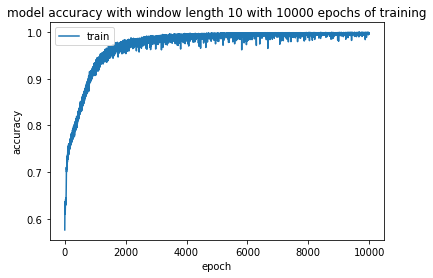

In [31]:
plt.plot(train_accs)
plt.title('model accuracy with window length 10 with 10000 epochs of training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

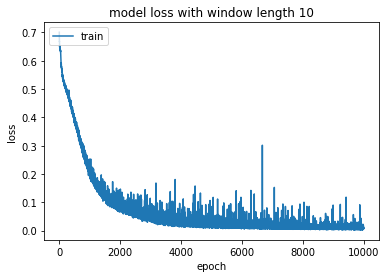

In [32]:
plt.plot(train_losses)
plt.title('model loss with window length 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [33]:
super_expert_model.reset_states()
test_results = calc_pos_neg_rate(super_expert_model.evaluate(x=test_generator, verbose=0))

In [34]:
super_expert_model.reset_states()
train_results = calc_pos_neg_rate(super_expert_model.evaluate(x=train_generator, verbose=0))

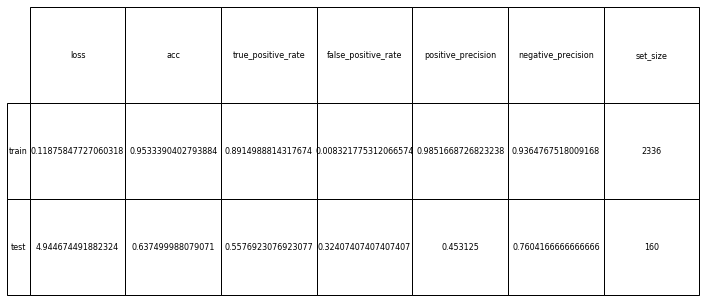

In [35]:
tabular_test_train_results(train_generator, test_generator, train_results, test_results)

Sounds like the metrics are still variable and are not stable, let's make the network bigger to see the network's performance. Therefore, we make network deeper by adding more lstm layers.

In [21]:
epochs = 5000

In [58]:
train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_max_trading_days, \
                                                              training_start, training_end, testing_start, \
                                                              testing_end)

# layers = [
#           # input_shape : batch_size, time_step, #features
#           LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]),
#                return_sequences=True, stateful=True),
#           LSTM(300,
#                return_sequences=True, stateful=True),
#           LSTM(1200, stateful=True),
#           Dense(250, activation='relu'),
#           Dense(80, activation='relu'),
#           Dense(1),
#           Activation('sigmoid')
#          ]

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(300, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(84, activation='relu'),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
big_model = build_model(None, optimizer, layers, metrics=metrics)
big_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (32, 300)                 367200    
_________________________________________________________________
dense_10 (Dense)             (32, 84)                  25284     
_________________________________________________________________
dense_11 (Dense)             (32, 1)                   85        
_________________________________________________________________
activation_5 (Activation)    (32, 1)                   0         
Total params: 392,569
Trainable params: 392,569
Non-trainable params: 0
_________________________________________________________________


In [59]:
train_accs, train_losses = fit(big_model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   2.564 seconds , loss : 0.679    accuracy : 0.609    
epoch 2
----------->> Epoch 1/1   0.263 seconds , loss : 0.666    accuracy : 0.617    
epoch 3
----------->> Epoch 1/1   0.261 seconds , loss : 0.666    accuracy : 0.620    
epoch 4
----------->> Epoch 1/1   0.261 seconds , loss : 0.644    accuracy : 0.617    
epoch 5
----------->> Epoch 1/1   0.263 seconds , loss : 0.646    accuracy : 0.618    
epoch 6
----------->> Epoch 1/1   0.266 seconds , loss : 0.638    accuracy : 0.618    
epoch 7
----------->> Epoch 1/1   0.278 seconds , loss : 0.637    accuracy : 0.617    
epoch 8
----------->> Epoch 1/1   0.262 seconds , loss : 0.634    accuracy : 0.618    
epoch 9
----------->> Epoch 1/1   0.259 seconds , loss : 0.630    accuracy : 0.619    
epoch 10
----------->> Epoch 1/1   0.261 seconds , loss : 0.620    accuracy : 0.621    
epoch 11
----------->> Epoch 1/1   0.263 seconds , loss : 0.621    accuracy : 0.623    
epoch 12
----------->> Epoch 1/1   0.268 

----------->> Epoch 1/1   0.274 seconds , loss : 0.509    accuracy : 0.715    
epoch 95
----------->> Epoch 1/1   0.256 seconds , loss : 0.512    accuracy : 0.703    
epoch 96
----------->> Epoch 1/1   0.280 seconds , loss : 0.531    accuracy : 0.690    
epoch 97
----------->> Epoch 1/1   0.269 seconds , loss : 0.518    accuracy : 0.704    
epoch 98
----------->> Epoch 1/1   0.327 seconds , loss : 0.505    accuracy : 0.715    
epoch 99
----------->> Epoch 1/1   0.297 seconds , loss : 0.498    accuracy : 0.722    
epoch 100
----------->> Epoch 1/1   0.295 seconds , loss : 0.487    accuracy : 0.733    
epoch 101
----------->> Epoch 1/1   0.273 seconds , loss : 0.498    accuracy : 0.715    
epoch 102
----------->> Epoch 1/1   0.284 seconds , loss : 0.498    accuracy : 0.720    
epoch 103
----------->> Epoch 1/1   0.258 seconds , loss : 0.493    accuracy : 0.720    
epoch 104
----------->> Epoch 1/1   0.306 seconds , loss : 0.489    accuracy : 0.716    
epoch 105
----------->> Epoch 1/1   

----------->> Epoch 1/1   0.296 seconds , loss : 0.297    accuracy : 0.848    
epoch 187
----------->> Epoch 1/1   0.274 seconds , loss : 0.314    accuracy : 0.844    
epoch 188
----------->> Epoch 1/1   0.260 seconds , loss : 0.313    accuracy : 0.840    
epoch 189
----------->> Epoch 1/1   0.264 seconds , loss : 0.291    accuracy : 0.854    
epoch 190
----------->> Epoch 1/1   0.259 seconds , loss : 0.302    accuracy : 0.851    
epoch 191
----------->> Epoch 1/1   0.263 seconds , loss : 0.281    accuracy : 0.865    
epoch 192
----------->> Epoch 1/1   0.263 seconds , loss : 0.292    accuracy : 0.855    
epoch 193
----------->> Epoch 1/1   0.261 seconds , loss : 0.298    accuracy : 0.848    
epoch 194
----------->> Epoch 1/1   0.263 seconds , loss : 0.299    accuracy : 0.845    
epoch 195
----------->> Epoch 1/1   0.260 seconds , loss : 0.296    accuracy : 0.846    
epoch 196
----------->> Epoch 1/1   0.263 seconds , loss : 0.281    accuracy : 0.858    
epoch 197
----------->> Epoch 1

----------->> Epoch 1/1   0.264 seconds , loss : 0.151    accuracy : 0.932    
epoch 279
----------->> Epoch 1/1   0.270 seconds , loss : 0.170    accuracy : 0.927    
epoch 280
----------->> Epoch 1/1   0.262 seconds , loss : 0.170    accuracy : 0.925    
epoch 281
----------->> Epoch 1/1   0.267 seconds , loss : 0.157    accuracy : 0.935    
epoch 282
----------->> Epoch 1/1   0.264 seconds , loss : 0.149    accuracy : 0.937    
epoch 283
----------->> Epoch 1/1   0.267 seconds , loss : 0.148    accuracy : 0.943    
epoch 284
----------->> Epoch 1/1   0.264 seconds , loss : 0.155    accuracy : 0.932    
epoch 285
----------->> Epoch 1/1   0.266 seconds , loss : 0.171    accuracy : 0.929    
epoch 286
----------->> Epoch 1/1   0.263 seconds , loss : 0.150    accuracy : 0.933    
epoch 287
----------->> Epoch 1/1   0.265 seconds , loss : 0.140    accuracy : 0.946    
epoch 288
----------->> Epoch 1/1   0.265 seconds , loss : 0.136    accuracy : 0.943    
epoch 289
----------->> Epoch 1

----------->> Epoch 1/1   0.263 seconds , loss : 0.082    accuracy : 0.970    
epoch 371
----------->> Epoch 1/1   0.265 seconds , loss : 0.071    accuracy : 0.974    
epoch 372
----------->> Epoch 1/1   0.264 seconds , loss : 0.073    accuracy : 0.973    
epoch 373
----------->> Epoch 1/1   0.264 seconds , loss : 0.100    accuracy : 0.961    
epoch 374
----------->> Epoch 1/1   0.263 seconds , loss : 0.101    accuracy : 0.963    
epoch 375
----------->> Epoch 1/1   0.261 seconds , loss : 0.091    accuracy : 0.967    
epoch 376
----------->> Epoch 1/1   0.264 seconds , loss : 0.085    accuracy : 0.967    
epoch 377
----------->> Epoch 1/1   0.265 seconds , loss : 0.069    accuracy : 0.976    
epoch 378
----------->> Epoch 1/1   0.264 seconds , loss : 0.091    accuracy : 0.967    
epoch 379
----------->> Epoch 1/1   0.267 seconds , loss : 0.078    accuracy : 0.973    
epoch 380
----------->> Epoch 1/1   0.266 seconds , loss : 0.073    accuracy : 0.974    
epoch 381
----------->> Epoch 1

----------->> Epoch 1/1   0.310 seconds , loss : 0.054    accuracy : 0.982    
epoch 463
----------->> Epoch 1/1   0.313 seconds , loss : 0.052    accuracy : 0.980    
epoch 464
----------->> Epoch 1/1   0.301 seconds , loss : 0.050    accuracy : 0.982    
epoch 465
----------->> Epoch 1/1   0.294 seconds , loss : 0.061    accuracy : 0.975    
epoch 466
----------->> Epoch 1/1   0.270 seconds , loss : 0.047    accuracy : 0.982    
epoch 467
----------->> Epoch 1/1   0.268 seconds , loss : 0.057    accuracy : 0.980    
epoch 468
----------->> Epoch 1/1   0.267 seconds , loss : 0.048    accuracy : 0.983    
epoch 469
----------->> Epoch 1/1   0.264 seconds , loss : 0.056    accuracy : 0.976    
epoch 470
----------->> Epoch 1/1   0.268 seconds , loss : 0.068    accuracy : 0.978    
epoch 471
----------->> Epoch 1/1   0.259 seconds , loss : 0.062    accuracy : 0.978    
epoch 472
----------->> Epoch 1/1   0.267 seconds , loss : 0.068    accuracy : 0.972    
epoch 473
----------->> Epoch 1

----------->> Epoch 1/1   0.262 seconds , loss : 0.071    accuracy : 0.976    
epoch 555
----------->> Epoch 1/1   0.263 seconds , loss : 0.081    accuracy : 0.970    
epoch 556
----------->> Epoch 1/1   0.266 seconds , loss : 0.058    accuracy : 0.982    
epoch 557
----------->> Epoch 1/1   0.264 seconds , loss : 0.048    accuracy : 0.982    
epoch 558
----------->> Epoch 1/1   0.262 seconds , loss : 0.044    accuracy : 0.984    
epoch 559
----------->> Epoch 1/1   0.266 seconds , loss : 0.043    accuracy : 0.986    
epoch 560
----------->> Epoch 1/1   0.266 seconds , loss : 0.039    accuracy : 0.987    
epoch 561
----------->> Epoch 1/1   0.260 seconds , loss : 0.040    accuracy : 0.985    
epoch 562
----------->> Epoch 1/1   0.269 seconds , loss : 0.033    accuracy : 0.988    
epoch 563
----------->> Epoch 1/1   0.269 seconds , loss : 0.049    accuracy : 0.985    
epoch 564
----------->> Epoch 1/1   0.263 seconds , loss : 0.060    accuracy : 0.974    
epoch 565
----------->> Epoch 1

----------->> Epoch 1/1   0.264 seconds , loss : 0.051    accuracy : 0.979    
epoch 647
----------->> Epoch 1/1   0.260 seconds , loss : 0.041    accuracy : 0.985    
epoch 648
----------->> Epoch 1/1   0.262 seconds , loss : 0.041    accuracy : 0.987    
epoch 649
----------->> Epoch 1/1   0.267 seconds , loss : 0.038    accuracy : 0.985    
epoch 650
----------->> Epoch 1/1   0.263 seconds , loss : 0.045    accuracy : 0.987    
epoch 651
----------->> Epoch 1/1   0.267 seconds , loss : 0.061    accuracy : 0.977    
epoch 652
----------->> Epoch 1/1   0.260 seconds , loss : 0.081    accuracy : 0.976    
epoch 653
----------->> Epoch 1/1   0.264 seconds , loss : 0.064    accuracy : 0.976    
epoch 654
----------->> Epoch 1/1   0.256 seconds , loss : 0.053    accuracy : 0.983    
epoch 655
----------->> Epoch 1/1   0.261 seconds , loss : 0.062    accuracy : 0.982    
epoch 656
----------->> Epoch 1/1   0.257 seconds , loss : 0.039    accuracy : 0.988    
epoch 657
----------->> Epoch 1

----------->> Epoch 1/1   0.265 seconds , loss : 0.038    accuracy : 0.987    
epoch 739
----------->> Epoch 1/1   0.268 seconds , loss : 0.037    accuracy : 0.988    
epoch 740
----------->> Epoch 1/1   0.264 seconds , loss : 0.027    accuracy : 0.991    
epoch 741
----------->> Epoch 1/1   0.268 seconds , loss : 0.027    accuracy : 0.991    
epoch 742
----------->> Epoch 1/1   0.264 seconds , loss : 0.029    accuracy : 0.991    
epoch 743
----------->> Epoch 1/1   0.264 seconds , loss : 0.029    accuracy : 0.991    
epoch 744
----------->> Epoch 1/1   0.267 seconds , loss : 0.034    accuracy : 0.989    
epoch 745
----------->> Epoch 1/1   0.266 seconds , loss : 0.029    accuracy : 0.992    
epoch 746
----------->> Epoch 1/1   0.265 seconds , loss : 0.043    accuracy : 0.986    
epoch 747
----------->> Epoch 1/1   0.269 seconds , loss : 0.051    accuracy : 0.984    
epoch 748
----------->> Epoch 1/1   0.265 seconds , loss : 0.046    accuracy : 0.985    
epoch 749
----------->> Epoch 1

----------->> Epoch 1/1   0.261 seconds , loss : 0.029    accuracy : 0.990    
epoch 831
----------->> Epoch 1/1   0.271 seconds , loss : 0.024    accuracy : 0.993    
epoch 832
----------->> Epoch 1/1   0.262 seconds , loss : 0.018    accuracy : 0.996    
epoch 833
----------->> Epoch 1/1   0.263 seconds , loss : 0.021    accuracy : 0.994    
epoch 834
----------->> Epoch 1/1   0.266 seconds , loss : 0.026    accuracy : 0.991    
epoch 835
----------->> Epoch 1/1   0.265 seconds , loss : 0.047    accuracy : 0.982    
epoch 836
----------->> Epoch 1/1   0.265 seconds , loss : 0.029    accuracy : 0.992    
epoch 837
----------->> Epoch 1/1   0.271 seconds , loss : 0.023    accuracy : 0.991    
epoch 838
----------->> Epoch 1/1   0.262 seconds , loss : 0.023    accuracy : 0.993    
epoch 839
----------->> Epoch 1/1   0.264 seconds , loss : 0.019    accuracy : 0.995    
epoch 840
----------->> Epoch 1/1   0.262 seconds , loss : 0.022    accuracy : 0.992    
epoch 841
----------->> Epoch 1

----------->> Epoch 1/1   0.263 seconds , loss : 0.022    accuracy : 0.995    
epoch 923
----------->> Epoch 1/1   0.270 seconds , loss : 0.032    accuracy : 0.990    
epoch 924
----------->> Epoch 1/1   0.268 seconds , loss : 0.028    accuracy : 0.991    
epoch 925
----------->> Epoch 1/1   0.265 seconds , loss : 0.022    accuracy : 0.994    
epoch 926
----------->> Epoch 1/1   0.260 seconds , loss : 0.020    accuracy : 0.995    
epoch 927
----------->> Epoch 1/1   0.266 seconds , loss : 0.015    accuracy : 0.997    
epoch 928
----------->> Epoch 1/1   0.264 seconds , loss : 0.018    accuracy : 0.994    
epoch 929
----------->> Epoch 1/1   0.263 seconds , loss : 0.030    accuracy : 0.991    
epoch 930
----------->> Epoch 1/1   0.264 seconds , loss : 0.039    accuracy : 0.989    
epoch 931
----------->> Epoch 1/1   0.265 seconds , loss : 0.053    accuracy : 0.985    
epoch 932
----------->> Epoch 1/1   0.263 seconds , loss : 0.075    accuracy : 0.973    
epoch 933
----------->> Epoch 1

----------->> Epoch 1/1   0.267 seconds , loss : 0.020    accuracy : 0.993    
epoch 1015
----------->> Epoch 1/1   0.271 seconds , loss : 0.021    accuracy : 0.992    
epoch 1016
----------->> Epoch 1/1   0.265 seconds , loss : 0.022    accuracy : 0.991    
epoch 1017
----------->> Epoch 1/1   0.265 seconds , loss : 0.028    accuracy : 0.991    
epoch 1018
----------->> Epoch 1/1   0.265 seconds , loss : 0.024    accuracy : 0.994    
epoch 1019
----------->> Epoch 1/1   0.262 seconds , loss : 0.020    accuracy : 0.994    
epoch 1020
----------->> Epoch 1/1   0.262 seconds , loss : 0.022    accuracy : 0.992    
epoch 1021
----------->> Epoch 1/1   0.269 seconds , loss : 0.022    accuracy : 0.992    
epoch 1022
----------->> Epoch 1/1   0.267 seconds , loss : 0.022    accuracy : 0.993    
epoch 1023
----------->> Epoch 1/1   0.263 seconds , loss : 0.023    accuracy : 0.993    
epoch 1024
----------->> Epoch 1/1   0.264 seconds , loss : 0.021    accuracy : 0.994    
epoch 1025
----------

----------->> Epoch 1/1   0.286 seconds , loss : 0.033    accuracy : 0.988    
epoch 1106
----------->> Epoch 1/1   0.272 seconds , loss : 0.041    accuracy : 0.984    
epoch 1107
----------->> Epoch 1/1   0.265 seconds , loss : 0.028    accuracy : 0.990    
epoch 1108
----------->> Epoch 1/1   0.266 seconds , loss : 0.017    accuracy : 0.996    
epoch 1109
----------->> Epoch 1/1   0.265 seconds , loss : 0.016    accuracy : 0.997    
epoch 1110
----------->> Epoch 1/1   0.267 seconds , loss : 0.015    accuracy : 0.997    
epoch 1111
----------->> Epoch 1/1   0.264 seconds , loss : 0.018    accuracy : 0.997    
epoch 1112
----------->> Epoch 1/1   0.274 seconds , loss : 0.014    accuracy : 0.996    
epoch 1113
----------->> Epoch 1/1   0.270 seconds , loss : 0.012    accuracy : 0.997    
epoch 1114
----------->> Epoch 1/1   0.270 seconds , loss : 0.011    accuracy : 0.997    
epoch 1115
----------->> Epoch 1/1   0.261 seconds , loss : 0.011    accuracy : 0.998    
epoch 1116
----------

----------->> Epoch 1/1   0.264 seconds , loss : 0.014    accuracy : 0.995    
epoch 1197
----------->> Epoch 1/1   0.270 seconds , loss : 0.018    accuracy : 0.994    
epoch 1198
----------->> Epoch 1/1   0.264 seconds , loss : 0.013    accuracy : 0.997    
epoch 1199
----------->> Epoch 1/1   0.266 seconds , loss : 0.014    accuracy : 0.996    
epoch 1200
----------->> Epoch 1/1   0.264 seconds , loss : 0.011    accuracy : 0.998    
epoch 1201
----------->> Epoch 1/1   0.267 seconds , loss : 0.009    accuracy : 0.998    
epoch 1202
----------->> Epoch 1/1   0.266 seconds , loss : 0.014    accuracy : 0.996    
epoch 1203
----------->> Epoch 1/1   0.275 seconds , loss : 0.011    accuracy : 0.997    
epoch 1204
----------->> Epoch 1/1   0.267 seconds , loss : 0.018    accuracy : 0.996    
epoch 1205
----------->> Epoch 1/1   0.264 seconds , loss : 0.017    accuracy : 0.995    
epoch 1206
----------->> Epoch 1/1   0.263 seconds , loss : 0.013    accuracy : 0.997    
epoch 1207
----------

----------->> Epoch 1/1   0.266 seconds , loss : 0.012    accuracy : 0.997    
epoch 1288
----------->> Epoch 1/1   0.270 seconds , loss : 0.012    accuracy : 0.997    
epoch 1289
----------->> Epoch 1/1   0.266 seconds , loss : 0.011    accuracy : 0.997    
epoch 1290
----------->> Epoch 1/1   0.259 seconds , loss : 0.011    accuracy : 0.998    
epoch 1291
----------->> Epoch 1/1   0.265 seconds , loss : 0.015    accuracy : 0.997    
epoch 1292
----------->> Epoch 1/1   0.266 seconds , loss : 0.014    accuracy : 0.997    
epoch 1293
----------->> Epoch 1/1   0.265 seconds , loss : 0.012    accuracy : 0.997    
epoch 1294
----------->> Epoch 1/1   0.264 seconds , loss : 0.011    accuracy : 0.997    
epoch 1295
----------->> Epoch 1/1   0.311 seconds , loss : 0.017    accuracy : 0.995    
epoch 1296
----------->> Epoch 1/1   0.297 seconds , loss : 0.021    accuracy : 0.993    
epoch 1297
----------->> Epoch 1/1   0.313 seconds , loss : 0.013    accuracy : 0.996    
epoch 1298
----------

----------->> Epoch 1/1   0.265 seconds , loss : 0.028    accuracy : 0.990    
epoch 1379
----------->> Epoch 1/1   0.268 seconds , loss : 0.021    accuracy : 0.994    
epoch 1380
----------->> Epoch 1/1   0.267 seconds , loss : 0.017    accuracy : 0.994    
epoch 1381
----------->> Epoch 1/1   0.268 seconds , loss : 0.014    accuracy : 0.997    
epoch 1382
----------->> Epoch 1/1   0.266 seconds , loss : 0.011    accuracy : 0.997    
epoch 1383
----------->> Epoch 1/1   0.264 seconds , loss : 0.015    accuracy : 0.996    
epoch 1384
----------->> Epoch 1/1   0.265 seconds , loss : 0.012    accuracy : 0.997    
epoch 1385
----------->> Epoch 1/1   0.268 seconds , loss : 0.011    accuracy : 0.997    
epoch 1386
----------->> Epoch 1/1   0.264 seconds , loss : 0.010    accuracy : 0.997    
epoch 1387
----------->> Epoch 1/1   0.265 seconds , loss : 0.009    accuracy : 0.998    
epoch 1388
----------->> Epoch 1/1   0.275 seconds , loss : 0.006    accuracy : 0.998    
epoch 1389
----------

----------->> Epoch 1/1   0.263 seconds , loss : 0.014    accuracy : 0.996    
epoch 1470
----------->> Epoch 1/1   0.269 seconds , loss : 0.012    accuracy : 0.997    
epoch 1471
----------->> Epoch 1/1   0.261 seconds , loss : 0.014    accuracy : 0.996    
epoch 1472
----------->> Epoch 1/1   0.264 seconds , loss : 0.011    accuracy : 0.998    
epoch 1473
----------->> Epoch 1/1   0.266 seconds , loss : 0.008    accuracy : 0.998    
epoch 1474
----------->> Epoch 1/1   0.266 seconds , loss : 0.010    accuracy : 0.997    
epoch 1475
----------->> Epoch 1/1   0.263 seconds , loss : 0.009    accuracy : 0.998    
epoch 1476
----------->> Epoch 1/1   0.270 seconds , loss : 0.008    accuracy : 0.998    
epoch 1477
----------->> Epoch 1/1   0.266 seconds , loss : 0.010    accuracy : 0.998    
epoch 1478
----------->> Epoch 1/1   0.263 seconds , loss : 0.008    accuracy : 0.998    
epoch 1479
----------->> Epoch 1/1   0.273 seconds , loss : 0.008    accuracy : 0.998    
epoch 1480
----------

----------->> Epoch 1/1   0.273 seconds , loss : 0.012    accuracy : 0.997    
epoch 1561
----------->> Epoch 1/1   0.262 seconds , loss : 0.009    accuracy : 0.998    
epoch 1562
----------->> Epoch 1/1   0.265 seconds , loss : 0.009    accuracy : 0.998    
epoch 1563
----------->> Epoch 1/1   0.266 seconds , loss : 0.016    accuracy : 0.995    
epoch 1564
----------->> Epoch 1/1   0.266 seconds , loss : 0.010    accuracy : 0.998    
epoch 1565
----------->> Epoch 1/1   0.267 seconds , loss : 0.009    accuracy : 0.998    
epoch 1566
----------->> Epoch 1/1   0.265 seconds , loss : 0.013    accuracy : 0.997    
epoch 1567
----------->> Epoch 1/1   0.263 seconds , loss : 0.014    accuracy : 0.996    
epoch 1568
----------->> Epoch 1/1   0.265 seconds , loss : 0.009    accuracy : 0.997    
epoch 1569
----------->> Epoch 1/1   0.265 seconds , loss : 0.015    accuracy : 0.995    
epoch 1570
----------->> Epoch 1/1   0.264 seconds , loss : 0.015    accuracy : 0.996    
epoch 1571
----------

----------->> Epoch 1/1   0.265 seconds , loss : 0.022    accuracy : 0.995    
epoch 1652
----------->> Epoch 1/1   0.267 seconds , loss : 0.011    accuracy : 0.997    
epoch 1653
----------->> Epoch 1/1   0.264 seconds , loss : 0.017    accuracy : 0.995    
epoch 1654
----------->> Epoch 1/1   0.270 seconds , loss : 0.011    accuracy : 0.997    
epoch 1655
----------->> Epoch 1/1   0.269 seconds , loss : 0.011    accuracy : 0.997    
epoch 1656
----------->> Epoch 1/1   0.265 seconds , loss : 0.011    accuracy : 0.997    
epoch 1657
----------->> Epoch 1/1   0.266 seconds , loss : 0.009    accuracy : 0.998    
epoch 1658
----------->> Epoch 1/1   0.267 seconds , loss : 0.008    accuracy : 0.998    
epoch 1659
----------->> Epoch 1/1   0.261 seconds , loss : 0.012    accuracy : 0.997    
epoch 1660
----------->> Epoch 1/1   0.265 seconds , loss : 0.010    accuracy : 0.998    
epoch 1661
----------->> Epoch 1/1   0.266 seconds , loss : 0.008    accuracy : 0.998    
epoch 1662
----------

----------->> Epoch 1/1   0.270 seconds , loss : 0.036    accuracy : 0.994    
epoch 1743
----------->> Epoch 1/1   0.263 seconds , loss : 0.026    accuracy : 0.993    
epoch 1744
----------->> Epoch 1/1   0.264 seconds , loss : 0.036    accuracy : 0.990    
epoch 1745
----------->> Epoch 1/1   0.268 seconds , loss : 0.020    accuracy : 0.994    
epoch 1746
----------->> Epoch 1/1   0.267 seconds , loss : 0.012    accuracy : 0.997    
epoch 1747
----------->> Epoch 1/1   0.266 seconds , loss : 0.010    accuracy : 0.997    
epoch 1748
----------->> Epoch 1/1   0.265 seconds , loss : 0.010    accuracy : 0.997    
epoch 1749
----------->> Epoch 1/1   0.270 seconds , loss : 0.011    accuracy : 0.997    
epoch 1750
----------->> Epoch 1/1   0.263 seconds , loss : 0.007    accuracy : 0.999    
epoch 1751
----------->> Epoch 1/1   0.265 seconds , loss : 0.010    accuracy : 0.997    
epoch 1752
----------->> Epoch 1/1   0.269 seconds , loss : 0.008    accuracy : 0.997    
epoch 1753
----------

----------->> Epoch 1/1   0.264 seconds , loss : 0.010    accuracy : 0.997    
epoch 1834
----------->> Epoch 1/1   0.265 seconds , loss : 0.011    accuracy : 0.996    
epoch 1835
----------->> Epoch 1/1   0.265 seconds , loss : 0.009    accuracy : 0.997    
epoch 1836
----------->> Epoch 1/1   0.265 seconds , loss : 0.008    accuracy : 0.998    
epoch 1837
----------->> Epoch 1/1   0.266 seconds , loss : 0.008    accuracy : 0.998    
epoch 1838
----------->> Epoch 1/1   0.265 seconds , loss : 0.008    accuracy : 0.997    
epoch 1839
----------->> Epoch 1/1   0.263 seconds , loss : 0.007    accuracy : 0.998    
epoch 1840
----------->> Epoch 1/1   0.265 seconds , loss : 0.008    accuracy : 0.997    
epoch 1841
----------->> Epoch 1/1   0.266 seconds , loss : 0.009    accuracy : 0.997    
epoch 1842
----------->> Epoch 1/1   0.267 seconds , loss : 0.011    accuracy : 0.996    
epoch 1843
----------->> Epoch 1/1   0.265 seconds , loss : 0.018    accuracy : 0.996    
epoch 1844
----------

----------->> Epoch 1/1   0.265 seconds , loss : 0.017    accuracy : 0.995    
epoch 1925
----------->> Epoch 1/1   0.269 seconds , loss : 0.027    accuracy : 0.994    
epoch 1926
----------->> Epoch 1/1   0.265 seconds , loss : 0.012    accuracy : 0.997    
epoch 1927
----------->> Epoch 1/1   0.262 seconds , loss : 0.009    accuracy : 0.998    
epoch 1928
----------->> Epoch 1/1   0.270 seconds , loss : 0.010    accuracy : 0.997    
epoch 1929
----------->> Epoch 1/1   0.263 seconds , loss : 0.006    accuracy : 0.998    
epoch 1930
----------->> Epoch 1/1   0.266 seconds , loss : 0.010    accuracy : 0.997    
epoch 1931
----------->> Epoch 1/1   0.268 seconds , loss : 0.007    accuracy : 0.998    
epoch 1932
----------->> Epoch 1/1   0.317 seconds , loss : 0.014    accuracy : 0.997    
epoch 1933
----------->> Epoch 1/1   0.345 seconds , loss : 0.056    accuracy : 0.986    
epoch 1934
----------->> Epoch 1/1   0.322 seconds , loss : 0.029    accuracy : 0.991    
epoch 1935
----------

----------->> Epoch 1/1   0.264 seconds , loss : 0.011    accuracy : 0.997    
epoch 2016
----------->> Epoch 1/1   0.268 seconds , loss : 0.006    accuracy : 0.999    
epoch 2017
----------->> Epoch 1/1   0.266 seconds , loss : 0.006    accuracy : 0.998    
epoch 2018
----------->> Epoch 1/1   0.266 seconds , loss : 0.010    accuracy : 0.997    
epoch 2019
----------->> Epoch 1/1   0.261 seconds , loss : 0.016    accuracy : 0.995    
epoch 2020
----------->> Epoch 1/1   0.263 seconds , loss : 0.017    accuracy : 0.995    
epoch 2021
----------->> Epoch 1/1   0.266 seconds , loss : 0.015    accuracy : 0.997    
epoch 2022
----------->> Epoch 1/1   0.263 seconds , loss : 0.008    accuracy : 0.998    
epoch 2023
----------->> Epoch 1/1   0.263 seconds , loss : 0.013    accuracy : 0.996    
epoch 2024
----------->> Epoch 1/1   0.262 seconds , loss : 0.008    accuracy : 0.997    
epoch 2025
----------->> Epoch 1/1   0.266 seconds , loss : 0.005    accuracy : 0.999    
epoch 2026
----------

----------->> Epoch 1/1   0.262 seconds , loss : 0.013    accuracy : 0.997    
epoch 2107
----------->> Epoch 1/1   0.269 seconds , loss : 0.014    accuracy : 0.997    
epoch 2108
----------->> Epoch 1/1   0.266 seconds , loss : 0.008    accuracy : 0.997    
epoch 2109
----------->> Epoch 1/1   0.263 seconds , loss : 0.008    accuracy : 0.998    
epoch 2110
----------->> Epoch 1/1   0.260 seconds , loss : 0.009    accuracy : 0.997    
epoch 2111
----------->> Epoch 1/1   0.263 seconds , loss : 0.006    accuracy : 0.998    
epoch 2112
----------->> Epoch 1/1   0.265 seconds , loss : 0.008    accuracy : 0.998    
epoch 2113
----------->> Epoch 1/1   0.265 seconds , loss : 0.009    accuracy : 0.997    
epoch 2114
----------->> Epoch 1/1   0.264 seconds , loss : 0.007    accuracy : 0.998    
epoch 2115
----------->> Epoch 1/1   0.261 seconds , loss : 0.007    accuracy : 0.998    
epoch 2116
----------->> Epoch 1/1   0.263 seconds , loss : 0.008    accuracy : 0.997    
epoch 2117
----------

----------->> Epoch 1/1   0.265 seconds , loss : 0.005    accuracy : 0.999    
epoch 2198
----------->> Epoch 1/1   0.273 seconds , loss : 0.006    accuracy : 0.998    
epoch 2199
----------->> Epoch 1/1   0.262 seconds , loss : 0.009    accuracy : 0.998    
epoch 2200
----------->> Epoch 1/1   0.267 seconds , loss : 0.007    accuracy : 0.998    
epoch 2201
----------->> Epoch 1/1   0.269 seconds , loss : 0.006    accuracy : 0.998    
epoch 2202
----------->> Epoch 1/1   0.268 seconds , loss : 0.003    accuracy : 1.000    
epoch 2203
----------->> Epoch 1/1   0.258 seconds , loss : 0.007    accuracy : 0.998    
epoch 2204
----------->> Epoch 1/1   0.261 seconds , loss : 0.007    accuracy : 0.998    
epoch 2205
----------->> Epoch 1/1   0.264 seconds , loss : 0.008    accuracy : 0.998    
epoch 2206
----------->> Epoch 1/1   0.270 seconds , loss : 0.013    accuracy : 0.996    
epoch 2207
----------->> Epoch 1/1   0.270 seconds , loss : 0.009    accuracy : 0.997    
epoch 2208
----------

----------->> Epoch 1/1   0.263 seconds , loss : 0.007    accuracy : 0.997    
epoch 2289
----------->> Epoch 1/1   0.272 seconds , loss : 0.007    accuracy : 0.998    
epoch 2290
----------->> Epoch 1/1   0.264 seconds , loss : 0.004    accuracy : 0.999    
epoch 2291
----------->> Epoch 1/1   0.266 seconds , loss : 0.007    accuracy : 0.998    
epoch 2292
----------->> Epoch 1/1   0.263 seconds , loss : 0.004    accuracy : 0.999    
epoch 2293
----------->> Epoch 1/1   0.263 seconds , loss : 0.010    accuracy : 0.998    
epoch 2294
----------->> Epoch 1/1   0.266 seconds , loss : 0.007    accuracy : 0.998    
epoch 2295
----------->> Epoch 1/1   0.266 seconds , loss : 0.011    accuracy : 0.997    
epoch 2296
----------->> Epoch 1/1   0.264 seconds , loss : 0.039    accuracy : 0.985    
epoch 2297
----------->> Epoch 1/1   0.265 seconds , loss : 0.027    accuracy : 0.988    
epoch 2298
----------->> Epoch 1/1   0.265 seconds , loss : 0.011    accuracy : 0.997    
epoch 2299
----------

----------->> Epoch 1/1   0.262 seconds , loss : 0.004    accuracy : 0.998    
epoch 2380
----------->> Epoch 1/1   0.265 seconds , loss : 0.003    accuracy : 0.999    
epoch 2381
----------->> Epoch 1/1   0.264 seconds , loss : 0.008    accuracy : 0.998    
epoch 2382
----------->> Epoch 1/1   0.266 seconds , loss : 0.009    accuracy : 0.996    
epoch 2383
----------->> Epoch 1/1   0.277 seconds , loss : 0.010    accuracy : 0.998    
epoch 2384
----------->> Epoch 1/1   0.259 seconds , loss : 0.006    accuracy : 0.999    
epoch 2385
----------->> Epoch 1/1   0.265 seconds , loss : 0.006    accuracy : 0.998    
epoch 2386
----------->> Epoch 1/1   0.264 seconds , loss : 0.008    accuracy : 0.997    
epoch 2387
----------->> Epoch 1/1   0.264 seconds , loss : 0.028    accuracy : 0.995    
epoch 2388
----------->> Epoch 1/1   0.272 seconds , loss : 0.022    accuracy : 0.994    
epoch 2389
----------->> Epoch 1/1   0.266 seconds , loss : 0.025    accuracy : 0.993    
epoch 2390
----------

----------->> Epoch 1/1   0.274 seconds , loss : 0.032    accuracy : 0.993    
epoch 2471
----------->> Epoch 1/1   0.273 seconds , loss : 0.035    accuracy : 0.992    
epoch 2472
----------->> Epoch 1/1   0.261 seconds , loss : 0.010    accuracy : 0.997    
epoch 2473
----------->> Epoch 1/1   0.266 seconds , loss : 0.015    accuracy : 0.995    
epoch 2474
----------->> Epoch 1/1   0.266 seconds , loss : 0.018    accuracy : 0.995    
epoch 2475
----------->> Epoch 1/1   0.268 seconds , loss : 0.013    accuracy : 0.996    
epoch 2476
----------->> Epoch 1/1   0.264 seconds , loss : 0.010    accuracy : 0.996    
epoch 2477
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.999    
epoch 2478
----------->> Epoch 1/1   0.267 seconds , loss : 0.008    accuracy : 0.997    
epoch 2479
----------->> Epoch 1/1   0.272 seconds , loss : 0.005    accuracy : 0.999    
epoch 2480
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.999    
epoch 2481
----------

----------->> Epoch 1/1   0.275 seconds , loss : 0.007    accuracy : 0.997    
epoch 2562
----------->> Epoch 1/1   0.269 seconds , loss : 0.006    accuracy : 0.998    
epoch 2563
----------->> Epoch 1/1   0.266 seconds , loss : 0.007    accuracy : 0.997    
epoch 2564
----------->> Epoch 1/1   0.264 seconds , loss : 0.008    accuracy : 0.998    
epoch 2565
----------->> Epoch 1/1   0.268 seconds , loss : 0.011    accuracy : 0.996    
epoch 2566
----------->> Epoch 1/1   0.270 seconds , loss : 0.020    accuracy : 0.992    
epoch 2567
----------->> Epoch 1/1   0.267 seconds , loss : 0.026    accuracy : 0.993    
epoch 2568
----------->> Epoch 1/1   0.266 seconds , loss : 0.010    accuracy : 0.996    
epoch 2569
----------->> Epoch 1/1   0.268 seconds , loss : 0.006    accuracy : 0.999    
epoch 2570
----------->> Epoch 1/1   0.267 seconds , loss : 0.005    accuracy : 0.998    
epoch 2571
----------->> Epoch 1/1   0.266 seconds , loss : 0.005    accuracy : 0.999    
epoch 2572
----------

----------->> Epoch 1/1   0.265 seconds , loss : 0.005    accuracy : 0.999    
epoch 2653
----------->> Epoch 1/1   0.267 seconds , loss : 0.011    accuracy : 0.996    
epoch 2654
----------->> Epoch 1/1   0.270 seconds , loss : 0.006    accuracy : 0.998    
epoch 2655
----------->> Epoch 1/1   0.266 seconds , loss : 0.005    accuracy : 0.998    
epoch 2656
----------->> Epoch 1/1   0.271 seconds , loss : 0.003    accuracy : 0.999    
epoch 2657
----------->> Epoch 1/1   0.264 seconds , loss : 0.004    accuracy : 0.998    
epoch 2658
----------->> Epoch 1/1   0.266 seconds , loss : 0.002    accuracy : 0.999    
epoch 2659
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.999    
epoch 2660
----------->> Epoch 1/1   0.266 seconds , loss : 0.002    accuracy : 1.000    
epoch 2661
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.999    
epoch 2662
----------->> Epoch 1/1   0.266 seconds , loss : 0.003    accuracy : 0.999    
epoch 2663
----------

----------->> Epoch 1/1   0.271 seconds , loss : 0.004    accuracy : 0.999    
epoch 2744
----------->> Epoch 1/1   0.269 seconds , loss : 0.003    accuracy : 0.999    
epoch 2745
----------->> Epoch 1/1   0.267 seconds , loss : 0.005    accuracy : 0.999    
epoch 2746
----------->> Epoch 1/1   0.281 seconds , loss : 0.008    accuracy : 0.998    
epoch 2747
----------->> Epoch 1/1   0.269 seconds , loss : 0.006    accuracy : 0.998    
epoch 2748
----------->> Epoch 1/1   0.272 seconds , loss : 0.006    accuracy : 0.998    
epoch 2749
----------->> Epoch 1/1   0.260 seconds , loss : 0.004    accuracy : 0.999    
epoch 2750
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.998    
epoch 2751
----------->> Epoch 1/1   0.267 seconds , loss : 0.003    accuracy : 0.999    
epoch 2752
----------->> Epoch 1/1   0.270 seconds , loss : 0.005    accuracy : 0.998    
epoch 2753
----------->> Epoch 1/1   0.270 seconds , loss : 0.008    accuracy : 0.998    
epoch 2754
----------

----------->> Epoch 1/1   0.268 seconds , loss : 0.006    accuracy : 0.998    
epoch 2835
----------->> Epoch 1/1   0.265 seconds , loss : 0.018    accuracy : 0.997    
epoch 2836
----------->> Epoch 1/1   0.266 seconds , loss : 0.008    accuracy : 0.998    
epoch 2837
----------->> Epoch 1/1   0.271 seconds , loss : 0.010    accuracy : 0.996    
epoch 2838
----------->> Epoch 1/1   0.270 seconds , loss : 0.006    accuracy : 0.998    
epoch 2839
----------->> Epoch 1/1   0.264 seconds , loss : 0.004    accuracy : 0.999    
epoch 2840
----------->> Epoch 1/1   0.265 seconds , loss : 0.002    accuracy : 1.000    
epoch 2841
----------->> Epoch 1/1   0.268 seconds , loss : 0.006    accuracy : 0.998    
epoch 2842
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 1.000    
epoch 2843
----------->> Epoch 1/1   0.263 seconds , loss : 0.003    accuracy : 0.998    
epoch 2844
----------->> Epoch 1/1   0.311 seconds , loss : 0.005    accuracy : 0.998    
epoch 2845
----------

----------->> Epoch 1/1   0.265 seconds , loss : 0.005    accuracy : 0.999    
epoch 2926
----------->> Epoch 1/1   0.267 seconds , loss : 0.005    accuracy : 0.998    
epoch 2927
----------->> Epoch 1/1   0.270 seconds , loss : 0.005    accuracy : 0.998    
epoch 2928
----------->> Epoch 1/1   0.266 seconds , loss : 0.002    accuracy : 0.999    
epoch 2929
----------->> Epoch 1/1   0.267 seconds , loss : 0.006    accuracy : 0.998    
epoch 2930
----------->> Epoch 1/1   0.269 seconds , loss : 0.006    accuracy : 0.998    
epoch 2931
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.998    
epoch 2932
----------->> Epoch 1/1   0.270 seconds , loss : 0.009    accuracy : 0.997    
epoch 2933
----------->> Epoch 1/1   0.267 seconds , loss : 0.004    accuracy : 0.998    
epoch 2934
----------->> Epoch 1/1   0.263 seconds , loss : 0.009    accuracy : 0.998    
epoch 2935
----------->> Epoch 1/1   0.264 seconds , loss : 0.005    accuracy : 0.998    
epoch 2936
----------

----------->> Epoch 1/1   0.268 seconds , loss : 0.004    accuracy : 0.999    
epoch 3017
----------->> Epoch 1/1   0.268 seconds , loss : 0.006    accuracy : 0.998    
epoch 3018
----------->> Epoch 1/1   0.268 seconds , loss : 0.006    accuracy : 0.999    
epoch 3019
----------->> Epoch 1/1   0.263 seconds , loss : 0.004    accuracy : 0.999    
epoch 3020
----------->> Epoch 1/1   0.262 seconds , loss : 0.005    accuracy : 0.999    
epoch 3021
----------->> Epoch 1/1   0.267 seconds , loss : 0.005    accuracy : 0.999    
epoch 3022
----------->> Epoch 1/1   0.265 seconds , loss : 0.003    accuracy : 0.999    
epoch 3023
----------->> Epoch 1/1   0.269 seconds , loss : 0.005    accuracy : 0.998    
epoch 3024
----------->> Epoch 1/1   0.268 seconds , loss : 0.004    accuracy : 0.999    
epoch 3025
----------->> Epoch 1/1   0.276 seconds , loss : 0.004    accuracy : 0.999    
epoch 3026
----------->> Epoch 1/1   0.313 seconds , loss : 0.008    accuracy : 0.997    
epoch 3027
----------

----------->> Epoch 1/1   0.305 seconds , loss : 0.007    accuracy : 0.997    
epoch 3108
----------->> Epoch 1/1   0.297 seconds , loss : 0.005    accuracy : 0.998    
epoch 3109
----------->> Epoch 1/1   0.278 seconds , loss : 0.003    accuracy : 0.997    
epoch 3110
----------->> Epoch 1/1   0.322 seconds , loss : 0.004    accuracy : 0.999    
epoch 3111
----------->> Epoch 1/1   0.298 seconds , loss : 0.005    accuracy : 0.998    
epoch 3112
----------->> Epoch 1/1   0.288 seconds , loss : 0.008    accuracy : 0.998    
epoch 3113
----------->> Epoch 1/1   0.273 seconds , loss : 0.035    accuracy : 0.990    
epoch 3114
----------->> Epoch 1/1   0.271 seconds , loss : 0.011    accuracy : 0.997    
epoch 3115
----------->> Epoch 1/1   0.294 seconds , loss : 0.006    accuracy : 0.998    
epoch 3116
----------->> Epoch 1/1   0.430 seconds , loss : 0.004    accuracy : 1.000    
epoch 3117
----------->> Epoch 1/1   0.271 seconds , loss : 0.005    accuracy : 0.999    
epoch 3118
----------

----------->> Epoch 1/1   0.273 seconds , loss : 0.005    accuracy : 0.999    
epoch 3199
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.999    
epoch 3200
----------->> Epoch 1/1   0.264 seconds , loss : 0.006    accuracy : 0.997    
epoch 3201
----------->> Epoch 1/1   0.265 seconds , loss : 0.008    accuracy : 0.997    
epoch 3202
----------->> Epoch 1/1   0.267 seconds , loss : 0.009    accuracy : 0.997    
epoch 3203
----------->> Epoch 1/1   0.302 seconds , loss : 0.010    accuracy : 0.997    
epoch 3204
----------->> Epoch 1/1   0.272 seconds , loss : 0.009    accuracy : 0.997    
epoch 3205
----------->> Epoch 1/1   0.301 seconds , loss : 0.006    accuracy : 0.998    
epoch 3206
----------->> Epoch 1/1   0.265 seconds , loss : 0.005    accuracy : 0.998    
epoch 3207
----------->> Epoch 1/1   0.275 seconds , loss : 0.007    accuracy : 0.998    
epoch 3208
----------->> Epoch 1/1   0.264 seconds , loss : 0.004    accuracy : 0.999    
epoch 3209
----------

----------->> Epoch 1/1   0.271 seconds , loss : 0.009    accuracy : 0.997    
epoch 3290
----------->> Epoch 1/1   0.265 seconds , loss : 0.006    accuracy : 0.999    
epoch 3291
----------->> Epoch 1/1   0.264 seconds , loss : 0.006    accuracy : 0.998    
epoch 3292
----------->> Epoch 1/1   0.265 seconds , loss : 0.003    accuracy : 0.999    
epoch 3293
----------->> Epoch 1/1   0.263 seconds , loss : 0.003    accuracy : 0.999    
epoch 3294
----------->> Epoch 1/1   0.263 seconds , loss : 0.005    accuracy : 0.998    
epoch 3295
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.999    
epoch 3296
----------->> Epoch 1/1   0.266 seconds , loss : 0.006    accuracy : 0.999    
epoch 3297
----------->> Epoch 1/1   0.267 seconds , loss : 0.005    accuracy : 0.999    
epoch 3298
----------->> Epoch 1/1   0.265 seconds , loss : 0.002    accuracy : 0.999    
epoch 3299
----------->> Epoch 1/1   0.269 seconds , loss : 0.004    accuracy : 0.999    
epoch 3300
----------

----------->> Epoch 1/1   0.270 seconds , loss : 0.007    accuracy : 0.998    
epoch 3381
----------->> Epoch 1/1   0.264 seconds , loss : 0.005    accuracy : 0.999    
epoch 3382
----------->> Epoch 1/1   0.268 seconds , loss : 0.005    accuracy : 0.998    
epoch 3383
----------->> Epoch 1/1   0.268 seconds , loss : 0.003    accuracy : 0.999    
epoch 3384
----------->> Epoch 1/1   0.266 seconds , loss : 0.002    accuracy : 1.000    
epoch 3385
----------->> Epoch 1/1   0.263 seconds , loss : 0.004    accuracy : 0.999    
epoch 3386
----------->> Epoch 1/1   0.263 seconds , loss : 0.006    accuracy : 0.998    
epoch 3387
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.999    
epoch 3388
----------->> Epoch 1/1   0.265 seconds , loss : 0.006    accuracy : 0.998    
epoch 3389
----------->> Epoch 1/1   0.262 seconds , loss : 0.004    accuracy : 0.998    
epoch 3390
----------->> Epoch 1/1   0.267 seconds , loss : 0.005    accuracy : 0.999    
epoch 3391
----------

----------->> Epoch 1/1   0.267 seconds , loss : 0.012    accuracy : 0.995    
epoch 3472
----------->> Epoch 1/1   0.263 seconds , loss : 0.006    accuracy : 0.998    
epoch 3473
----------->> Epoch 1/1   0.262 seconds , loss : 0.005    accuracy : 0.999    
epoch 3474
----------->> Epoch 1/1   0.263 seconds , loss : 0.004    accuracy : 0.998    
epoch 3475
----------->> Epoch 1/1   0.262 seconds , loss : 0.005    accuracy : 0.999    
epoch 3476
----------->> Epoch 1/1   0.264 seconds , loss : 0.004    accuracy : 0.998    
epoch 3477
----------->> Epoch 1/1   0.264 seconds , loss : 0.006    accuracy : 0.997    
epoch 3478
----------->> Epoch 1/1   0.268 seconds , loss : 0.010    accuracy : 0.997    
epoch 3479
----------->> Epoch 1/1   0.263 seconds , loss : 0.009    accuracy : 0.996    
epoch 3480
----------->> Epoch 1/1   0.265 seconds , loss : 0.011    accuracy : 0.998    
epoch 3481
----------->> Epoch 1/1   0.261 seconds , loss : 0.002    accuracy : 0.999    
epoch 3482
----------

----------->> Epoch 1/1   0.262 seconds , loss : 0.002    accuracy : 0.999    
epoch 3563
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.999    
epoch 3564
----------->> Epoch 1/1   0.263 seconds , loss : 0.002    accuracy : 0.999    
epoch 3565
----------->> Epoch 1/1   0.263 seconds , loss : 0.004    accuracy : 0.999    
epoch 3566
----------->> Epoch 1/1   0.264 seconds , loss : 0.004    accuracy : 0.999    
epoch 3567
----------->> Epoch 1/1   0.264 seconds , loss : 0.003    accuracy : 0.999    
epoch 3568
----------->> Epoch 1/1   0.262 seconds , loss : 0.004    accuracy : 0.998    
epoch 3569
----------->> Epoch 1/1   0.264 seconds , loss : 0.005    accuracy : 0.999    
epoch 3570
----------->> Epoch 1/1   0.268 seconds , loss : 0.004    accuracy : 0.999    
epoch 3571
----------->> Epoch 1/1   0.264 seconds , loss : 0.003    accuracy : 0.999    
epoch 3572
----------->> Epoch 1/1   0.264 seconds , loss : 0.004    accuracy : 0.999    
epoch 3573
----------

----------->> Epoch 1/1   0.266 seconds , loss : 0.007    accuracy : 0.997    
epoch 3654
----------->> Epoch 1/1   0.260 seconds , loss : 0.004    accuracy : 0.998    
epoch 3655
----------->> Epoch 1/1   0.265 seconds , loss : 0.008    accuracy : 0.997    
epoch 3656
----------->> Epoch 1/1   0.270 seconds , loss : 0.016    accuracy : 0.996    
epoch 3657
----------->> Epoch 1/1   0.262 seconds , loss : 0.007    accuracy : 0.999    
epoch 3658
----------->> Epoch 1/1   0.258 seconds , loss : 0.003    accuracy : 0.999    
epoch 3659
----------->> Epoch 1/1   0.267 seconds , loss : 0.003    accuracy : 1.000    
epoch 3660
----------->> Epoch 1/1   0.265 seconds , loss : 0.005    accuracy : 0.999    
epoch 3661
----------->> Epoch 1/1   0.262 seconds , loss : 0.004    accuracy : 1.000    
epoch 3662
----------->> Epoch 1/1   0.264 seconds , loss : 0.005    accuracy : 0.999    
epoch 3663
----------->> Epoch 1/1   0.271 seconds , loss : 0.002    accuracy : 0.999    
epoch 3664
----------

----------->> Epoch 1/1   0.266 seconds , loss : 0.004    accuracy : 0.999    
epoch 3745
----------->> Epoch 1/1   0.272 seconds , loss : 0.007    accuracy : 0.998    
epoch 3746
----------->> Epoch 1/1   0.266 seconds , loss : 0.003    accuracy : 0.998    
epoch 3747
----------->> Epoch 1/1   0.263 seconds , loss : 0.004    accuracy : 0.999    
epoch 3748
----------->> Epoch 1/1   0.262 seconds , loss : 0.006    accuracy : 0.999    
epoch 3749
----------->> Epoch 1/1   0.261 seconds , loss : 0.004    accuracy : 0.999    
epoch 3750
----------->> Epoch 1/1   0.266 seconds , loss : 0.006    accuracy : 0.997    
epoch 3751
----------->> Epoch 1/1   0.267 seconds , loss : 0.007    accuracy : 0.998    
epoch 3752
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.999    
epoch 3753
----------->> Epoch 1/1   0.263 seconds , loss : 0.005    accuracy : 0.999    
epoch 3754
----------->> Epoch 1/1   0.263 seconds , loss : 0.006    accuracy : 0.998    
epoch 3755
----------

----------->> Epoch 1/1   0.263 seconds , loss : 0.006    accuracy : 0.997    
epoch 3836
----------->> Epoch 1/1   0.266 seconds , loss : 0.003    accuracy : 0.999    
epoch 3837
----------->> Epoch 1/1   0.264 seconds , loss : 0.004    accuracy : 0.999    
epoch 3838
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.999    
epoch 3839
----------->> Epoch 1/1   0.265 seconds , loss : 0.003    accuracy : 1.000    
epoch 3840
----------->> Epoch 1/1   0.267 seconds , loss : 0.004    accuracy : 0.998    
epoch 3841
----------->> Epoch 1/1   0.263 seconds , loss : 0.003    accuracy : 0.999    
epoch 3842
----------->> Epoch 1/1   0.264 seconds , loss : 0.003    accuracy : 0.999    
epoch 3843
----------->> Epoch 1/1   0.262 seconds , loss : 0.005    accuracy : 0.999    
epoch 3844
----------->> Epoch 1/1   0.265 seconds , loss : 0.003    accuracy : 0.999    
epoch 3845
----------->> Epoch 1/1   0.270 seconds , loss : 0.002    accuracy : 0.999    
epoch 3846
----------

----------->> Epoch 1/1   0.287 seconds , loss : 0.002    accuracy : 0.999    
epoch 3927
----------->> Epoch 1/1   0.273 seconds , loss : 0.003    accuracy : 0.998    
epoch 3928
----------->> Epoch 1/1   0.274 seconds , loss : 0.004    accuracy : 0.999    
epoch 3929
----------->> Epoch 1/1   0.298 seconds , loss : 0.005    accuracy : 0.999    
epoch 3930
----------->> Epoch 1/1   0.267 seconds , loss : 0.003    accuracy : 1.000    
epoch 3931
----------->> Epoch 1/1   0.266 seconds , loss : 0.002    accuracy : 0.999    
epoch 3932
----------->> Epoch 1/1   0.264 seconds , loss : 0.003    accuracy : 0.999    
epoch 3933
----------->> Epoch 1/1   0.268 seconds , loss : 0.006    accuracy : 0.998    
epoch 3934
----------->> Epoch 1/1   0.263 seconds , loss : 0.005    accuracy : 0.999    
epoch 3935
----------->> Epoch 1/1   0.278 seconds , loss : 0.003    accuracy : 0.999    
epoch 3936
----------->> Epoch 1/1   0.262 seconds , loss : 0.003    accuracy : 0.999    
epoch 3937
----------

----------->> Epoch 1/1   0.261 seconds , loss : 0.002    accuracy : 0.999    
epoch 4018
----------->> Epoch 1/1   0.266 seconds , loss : 0.005    accuracy : 0.998    
epoch 4019
----------->> Epoch 1/1   0.268 seconds , loss : 0.002    accuracy : 0.999    
epoch 4020
----------->> Epoch 1/1   0.265 seconds , loss : 0.001    accuracy : 1.000    
epoch 4021
----------->> Epoch 1/1   0.264 seconds , loss : 0.005    accuracy : 0.998    
epoch 4022
----------->> Epoch 1/1   0.267 seconds , loss : 0.006    accuracy : 0.998    
epoch 4023
----------->> Epoch 1/1   0.263 seconds , loss : 0.004    accuracy : 0.999    
epoch 4024
----------->> Epoch 1/1   0.267 seconds , loss : 0.006    accuracy : 0.998    
epoch 4025
----------->> Epoch 1/1   0.264 seconds , loss : 0.003    accuracy : 1.000    
epoch 4026
----------->> Epoch 1/1   0.262 seconds , loss : 0.005    accuracy : 0.998    
epoch 4027
----------->> Epoch 1/1   0.262 seconds , loss : 0.006    accuracy : 0.998    
epoch 4028
----------

----------->> Epoch 1/1   0.260 seconds , loss : 0.006    accuracy : 0.998    
epoch 4109
----------->> Epoch 1/1   0.267 seconds , loss : 0.003    accuracy : 0.999    
epoch 4110
----------->> Epoch 1/1   0.263 seconds , loss : 0.006    accuracy : 0.999    
epoch 4111
----------->> Epoch 1/1   0.264 seconds , loss : 0.005    accuracy : 0.999    
epoch 4112
----------->> Epoch 1/1   0.268 seconds , loss : 0.002    accuracy : 1.000    
epoch 4113
----------->> Epoch 1/1   0.268 seconds , loss : 0.005    accuracy : 0.999    
epoch 4114
----------->> Epoch 1/1   0.268 seconds , loss : 0.004    accuracy : 0.999    
epoch 4115
----------->> Epoch 1/1   0.265 seconds , loss : 0.001    accuracy : 1.000    
epoch 4116
----------->> Epoch 1/1   0.270 seconds , loss : 0.005    accuracy : 0.999    
epoch 4117
----------->> Epoch 1/1   0.262 seconds , loss : 0.004    accuracy : 0.998    
epoch 4118
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.999    
epoch 4119
----------

----------->> Epoch 1/1   0.272 seconds , loss : 0.001    accuracy : 1.000    
epoch 4200
----------->> Epoch 1/1   0.265 seconds , loss : 0.001    accuracy : 1.000    
epoch 4201
----------->> Epoch 1/1   0.260 seconds , loss : 0.004    accuracy : 0.999    
epoch 4202
----------->> Epoch 1/1   0.263 seconds , loss : 0.003    accuracy : 0.999    
epoch 4203
----------->> Epoch 1/1   0.264 seconds , loss : 0.005    accuracy : 0.998    
epoch 4204
----------->> Epoch 1/1   0.263 seconds , loss : 0.019    accuracy : 0.997    
epoch 4205
----------->> Epoch 1/1   0.264 seconds , loss : 0.006    accuracy : 0.997    
epoch 4206
----------->> Epoch 1/1   0.267 seconds , loss : 0.011    accuracy : 0.997    
epoch 4207
----------->> Epoch 1/1   0.266 seconds , loss : 0.012    accuracy : 0.997    
epoch 4208
----------->> Epoch 1/1   0.265 seconds , loss : 0.017    accuracy : 0.996    
epoch 4209
----------->> Epoch 1/1   0.264 seconds , loss : 0.010    accuracy : 0.997    
epoch 4210
----------

----------->> Epoch 1/1   0.262 seconds , loss : 0.001    accuracy : 1.000    
epoch 4291
----------->> Epoch 1/1   0.265 seconds , loss : 0.001    accuracy : 0.999    
epoch 4292
----------->> Epoch 1/1   0.264 seconds , loss : 0.001    accuracy : 0.999    
epoch 4293
----------->> Epoch 1/1   0.274 seconds , loss : 0.002    accuracy : 0.999    
epoch 4294
----------->> Epoch 1/1   0.266 seconds , loss : 0.005    accuracy : 0.998    
epoch 4295
----------->> Epoch 1/1   0.296 seconds , loss : 0.002    accuracy : 0.999    
epoch 4296
----------->> Epoch 1/1   0.276 seconds , loss : 0.004    accuracy : 0.998    
epoch 4297
----------->> Epoch 1/1   0.265 seconds , loss : 0.003    accuracy : 0.999    
epoch 4298
----------->> Epoch 1/1   0.280 seconds , loss : 0.002    accuracy : 0.999    
epoch 4299
----------->> Epoch 1/1   0.304 seconds , loss : 0.003    accuracy : 0.999    
epoch 4300
----------->> Epoch 1/1   0.302 seconds , loss : 0.003    accuracy : 0.998    
epoch 4301
----------

----------->> Epoch 1/1   0.268 seconds , loss : 0.019    accuracy : 0.994    
epoch 4382
----------->> Epoch 1/1   0.275 seconds , loss : 0.012    accuracy : 0.995    
epoch 4383
----------->> Epoch 1/1   0.264 seconds , loss : 0.007    accuracy : 0.998    
epoch 4384
----------->> Epoch 1/1   0.265 seconds , loss : 0.005    accuracy : 0.998    
epoch 4385
----------->> Epoch 1/1   0.267 seconds , loss : 0.005    accuracy : 0.998    
epoch 4386
----------->> Epoch 1/1   0.262 seconds , loss : 0.004    accuracy : 0.998    
epoch 4387
----------->> Epoch 1/1   0.262 seconds , loss : 0.005    accuracy : 0.999    
epoch 4388
----------->> Epoch 1/1   0.260 seconds , loss : 0.006    accuracy : 0.997    
epoch 4389
----------->> Epoch 1/1   0.272 seconds , loss : 0.011    accuracy : 0.997    
epoch 4390
----------->> Epoch 1/1   0.263 seconds , loss : 0.003    accuracy : 0.999    
epoch 4391
----------->> Epoch 1/1   0.266 seconds , loss : 0.004    accuracy : 0.998    
epoch 4392
----------

----------->> Epoch 1/1   0.270 seconds , loss : 0.002    accuracy : 0.999    
epoch 4473
----------->> Epoch 1/1   0.263 seconds , loss : 0.001    accuracy : 1.000    
epoch 4474
----------->> Epoch 1/1   0.271 seconds , loss : 0.003    accuracy : 0.999    
epoch 4475
----------->> Epoch 1/1   0.266 seconds , loss : 0.003    accuracy : 1.000    
epoch 4476
----------->> Epoch 1/1   0.271 seconds , loss : 0.006    accuracy : 0.998    
epoch 4477
----------->> Epoch 1/1   0.268 seconds , loss : 0.005    accuracy : 0.998    
epoch 4478
----------->> Epoch 1/1   0.260 seconds , loss : 0.002    accuracy : 0.999    
epoch 4479
----------->> Epoch 1/1   0.261 seconds , loss : 0.004    accuracy : 0.999    
epoch 4480
----------->> Epoch 1/1   0.264 seconds , loss : 0.003    accuracy : 0.998    
epoch 4481
----------->> Epoch 1/1   0.264 seconds , loss : 0.004    accuracy : 0.998    
epoch 4482
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.998    
epoch 4483
----------

----------->> Epoch 1/1   0.267 seconds , loss : 0.003    accuracy : 0.998    
epoch 4564
----------->> Epoch 1/1   0.263 seconds , loss : 0.003    accuracy : 0.999    
epoch 4565
----------->> Epoch 1/1   0.266 seconds , loss : 0.013    accuracy : 0.997    
epoch 4566
----------->> Epoch 1/1   0.259 seconds , loss : 0.017    accuracy : 0.996    
epoch 4567
----------->> Epoch 1/1   0.263 seconds , loss : 0.008    accuracy : 0.998    
epoch 4568
----------->> Epoch 1/1   0.263 seconds , loss : 0.002    accuracy : 0.999    
epoch 4569
----------->> Epoch 1/1   0.263 seconds , loss : 0.003    accuracy : 1.000    
epoch 4570
----------->> Epoch 1/1   0.265 seconds , loss : 0.005    accuracy : 0.998    
epoch 4571
----------->> Epoch 1/1   0.261 seconds , loss : 0.004    accuracy : 0.998    
epoch 4572
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.999    
epoch 4573
----------->> Epoch 1/1   0.267 seconds , loss : 0.006    accuracy : 0.998    
epoch 4574
----------

----------->> Epoch 1/1   0.262 seconds , loss : 0.004    accuracy : 0.998    
epoch 4655
----------->> Epoch 1/1   0.308 seconds , loss : 0.008    accuracy : 0.998    
epoch 4656
----------->> Epoch 1/1   0.267 seconds , loss : 0.004    accuracy : 0.999    
epoch 4657
----------->> Epoch 1/1   0.305 seconds , loss : 0.003    accuracy : 0.999    
epoch 4658
----------->> Epoch 1/1   0.284 seconds , loss : 0.002    accuracy : 0.999    
epoch 4659
----------->> Epoch 1/1   0.275 seconds , loss : 0.007    accuracy : 0.998    
epoch 4660
----------->> Epoch 1/1   0.293 seconds , loss : 0.003    accuracy : 0.998    
epoch 4661
----------->> Epoch 1/1   0.273 seconds , loss : 0.004    accuracy : 0.998    
epoch 4662
----------->> Epoch 1/1   0.298 seconds , loss : 0.002    accuracy : 1.000    
epoch 4663
----------->> Epoch 1/1   0.268 seconds , loss : 0.002    accuracy : 0.999    
epoch 4664
----------->> Epoch 1/1   0.293 seconds , loss : 0.001    accuracy : 1.000    
epoch 4665
----------

----------->> Epoch 1/1   0.301 seconds , loss : 0.002    accuracy : 0.999    
epoch 4746
----------->> Epoch 1/1   0.296 seconds , loss : 0.003    accuracy : 0.999    
epoch 4747
----------->> Epoch 1/1   0.268 seconds , loss : 0.001    accuracy : 1.000    
epoch 4748
----------->> Epoch 1/1   0.297 seconds , loss : 0.005    accuracy : 0.998    
epoch 4749
----------->> Epoch 1/1   0.300 seconds , loss : 0.003    accuracy : 0.999    
epoch 4750
----------->> Epoch 1/1   0.286 seconds , loss : 0.003    accuracy : 0.999    
epoch 4751
----------->> Epoch 1/1   0.289 seconds , loss : 0.005    accuracy : 0.998    
epoch 4752
----------->> Epoch 1/1   0.298 seconds , loss : 0.008    accuracy : 0.997    
epoch 4753
----------->> Epoch 1/1   0.266 seconds , loss : 0.004    accuracy : 0.999    
epoch 4754
----------->> Epoch 1/1   0.267 seconds , loss : 0.004    accuracy : 0.999    
epoch 4755
----------->> Epoch 1/1   0.312 seconds , loss : 0.002    accuracy : 0.999    
epoch 4756
----------

----------->> Epoch 1/1   0.301 seconds , loss : 0.003    accuracy : 0.999    
epoch 4837
----------->> Epoch 1/1   0.262 seconds , loss : 0.003    accuracy : 0.999    
epoch 4838
----------->> Epoch 1/1   0.271 seconds , loss : 0.002    accuracy : 0.999    
epoch 4839
----------->> Epoch 1/1   0.291 seconds , loss : 0.005    accuracy : 0.998    
epoch 4840
----------->> Epoch 1/1   0.265 seconds , loss : 0.003    accuracy : 0.999    
epoch 4841
----------->> Epoch 1/1   0.276 seconds , loss : 0.002    accuracy : 0.999    
epoch 4842
----------->> Epoch 1/1   0.291 seconds , loss : 0.005    accuracy : 0.999    
epoch 4843
----------->> Epoch 1/1   0.264 seconds , loss : 0.005    accuracy : 0.999    
epoch 4844
----------->> Epoch 1/1   0.298 seconds , loss : 0.012    accuracy : 0.997    
epoch 4845
----------->> Epoch 1/1   0.268 seconds , loss : 0.002    accuracy : 0.999    
epoch 4846
----------->> Epoch 1/1   0.280 seconds , loss : 0.004    accuracy : 0.998    
epoch 4847
----------

----------->> Epoch 1/1   0.267 seconds , loss : 0.004    accuracy : 0.998    
epoch 4928
----------->> Epoch 1/1   0.269 seconds , loss : 0.003    accuracy : 0.999    
epoch 4929
----------->> Epoch 1/1   0.290 seconds , loss : 0.004    accuracy : 0.999    
epoch 4930
----------->> Epoch 1/1   0.350 seconds , loss : 0.005    accuracy : 0.998    
epoch 4931
----------->> Epoch 1/1   0.315 seconds , loss : 0.005    accuracy : 0.999    
epoch 4932
----------->> Epoch 1/1   0.310 seconds , loss : 0.002    accuracy : 0.999    
epoch 4933
----------->> Epoch 1/1   0.364 seconds , loss : 0.003    accuracy : 0.998    
epoch 4934
----------->> Epoch 1/1   0.295 seconds , loss : 0.002    accuracy : 0.999    
epoch 4935
----------->> Epoch 1/1   0.374 seconds , loss : 0.005    accuracy : 0.998    
epoch 4936
----------->> Epoch 1/1   0.272 seconds , loss : 0.006    accuracy : 0.998    
epoch 4937
----------->> Epoch 1/1   0.293 seconds , loss : 0.003    accuracy : 0.999    
epoch 4938
----------

In [60]:
plt.plot(train_accs)
plt.title('big model accuracy with window length 10 with 5000 epochs of training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

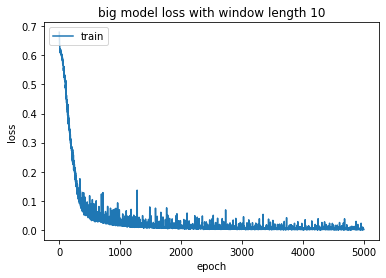

In [61]:
plt.plot(train_losses)
plt.title('big model loss with window length 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [62]:
big_model.reset_states()
test_results = calc_pos_neg_rate(big_model.evaluate(x=test_generator, verbose=0))

In [63]:
big_model.reset_states()
train_results = calc_pos_neg_rate(big_model.evaluate(x=train_generator, verbose=0))

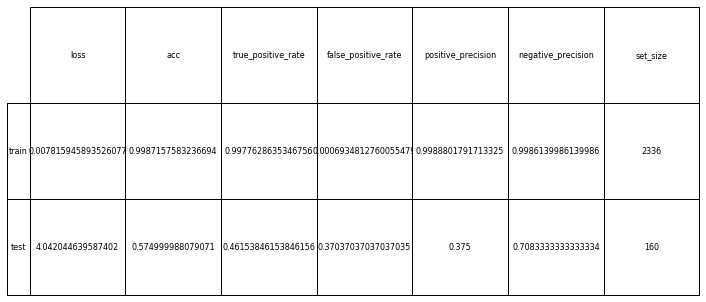

In [64]:
tabular_test_train_results(train_generator, test_generator, train_results, test_results)

Let's save the achieved model for further use.

In [65]:
big_model.save('big_model_10.h5')

## **Transfer Learning**

In this section, we load the pre-trained model and then do partial tuning with training it on the stock with second max trading days. Then, we test it to get accuracy of the model. We set the window length to 10.

In [113]:
stock_with_second_max_trading_days = ten_stocks_with_max_trading_days['TICKER'].iloc[1]
data_related_to_second = data[data['TICKER'] == stock_with_second_max_trading_days]

First of all, let's visualize the whole dataset related to second max stock.

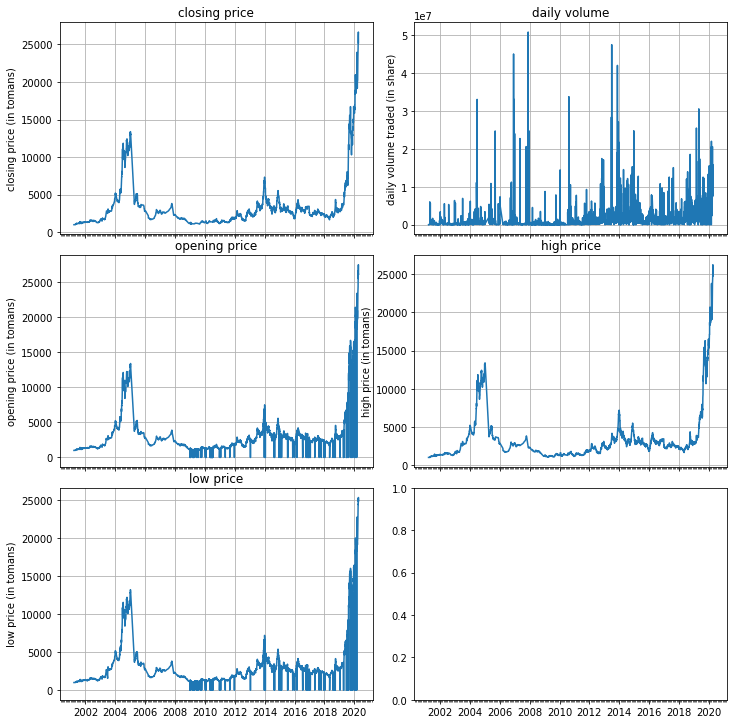

In [18]:
start_period = pandas.to_datetime('20010101', format='%Y%m%d', errors='ignore')
end_period = pandas.to_datetime('20200414', format='%Y%m%d', errors='ignore')
draw_ochlv(data_related_to_second, start_period, end_period)

We first split the dataset into train and test sets.

In [388]:
train_start = pandas.to_datetime('20100101', format='%Y%m%d', errors='ignore')
train_end = pandas.to_datetime('20160719', format='%Y%m%d', errors='ignore')
test_start = pandas.to_datetime('20170101', format='%Y%m%d', errors='ignore')
test_end = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')

Now, let's do some visualization. We draw the changes of features for both datasets.

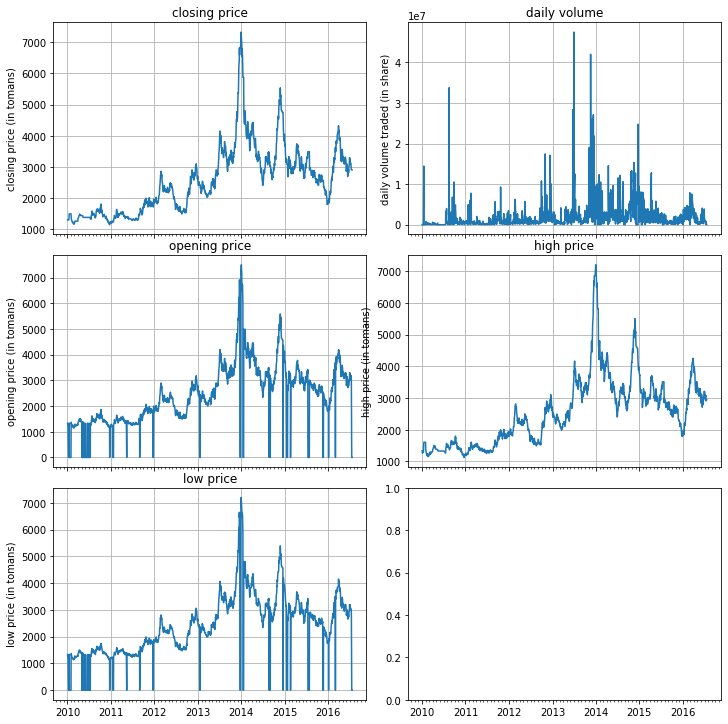

In [29]:
draw_ochlv(data_related_to_second, train_start, train_end)

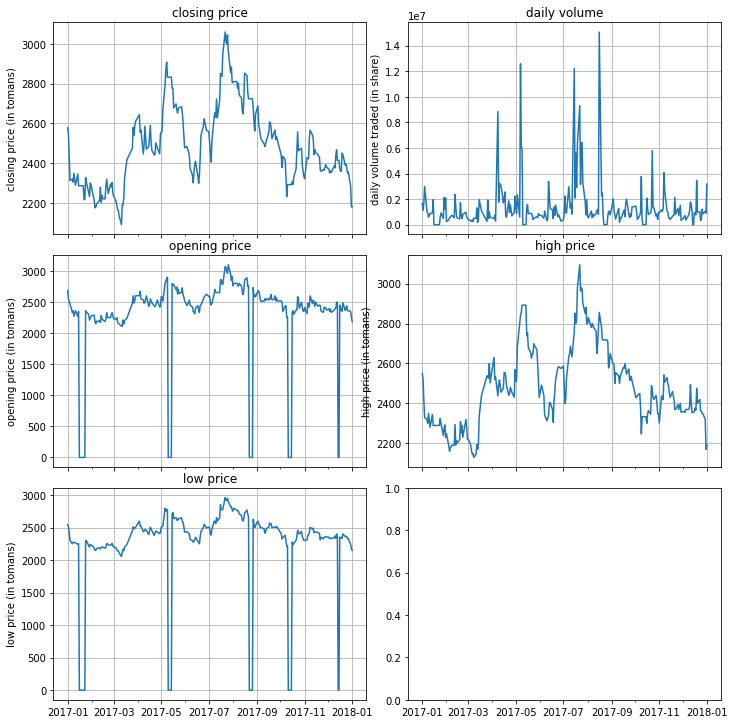

In [30]:
draw_ochlv(data_related_to_second, test_start, test_end)

Next, we load the pretrained model

In [115]:
train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_second_max_trading_days, train_start, train_end, test_start, test_end)

In [331]:
from tensorflow.keras.models import load_model


layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
base_model = build_model(train_generator.dim, optimizer, layers=layers, metrics=metrics)
base_model.load_weights(join(COLAB_DIR,'model_stateful.h5'))
base_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (32, 64)                  17920     
_________________________________________________________________
dense_32 (Dense)             (32, 32)                  2080      
_________________________________________________________________
dropout_8 (Dropout)          (32, 32)                  0         
_________________________________________________________________
dense_33 (Dense)             (32, 16)                  528       
_________________________________________________________________
batch_normalization_8 (Batch (32, 16)                  64        
_________________________________________________________________
dense_34 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_35 (Dense)             (32, 1)                  

In [281]:
epochs = 1000

In [332]:
train_accs, train_losses = fit(base_model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   1.548 seconds , loss : 1.555    accuracy : 0.530    
epoch 2
----------->> Epoch 1/1   0.152 seconds , loss : 0.813    accuracy : 0.566    
epoch 3
----------->> Epoch 1/1   0.152 seconds , loss : 0.730    accuracy : 0.549    
epoch 4
----------->> Epoch 1/1   0.204 seconds , loss : 0.713    accuracy : 0.559    
epoch 5
----------->> Epoch 1/1   0.329 seconds , loss : 0.691    accuracy : 0.600    
epoch 6
----------->> Epoch 1/1   0.313 seconds , loss : 0.689    accuracy : 0.575    
epoch 7
----------->> Epoch 1/1   0.153 seconds , loss : 0.673    accuracy : 0.591    
epoch 8
----------->> Epoch 1/1   0.159 seconds , loss : 0.644    accuracy : 0.613    
epoch 9
----------->> Epoch 1/1   0.165 seconds , loss : 0.638    accuracy : 0.629    
epoch 10
----------->> Epoch 1/1   0.147 seconds , loss : 0.636    accuracy : 0.626    
epoch 11
----------->> Epoch 1/1   0.285 seconds , loss : 0.623    accuracy : 0.640    
epoch 12
----------->> Epoch 1/1   0.258 

----------->> Epoch 1/1   0.176 seconds , loss : 0.194    accuracy : 0.918    
epoch 96
----------->> Epoch 1/1   0.270 seconds , loss : 0.202    accuracy : 0.919    
epoch 97
----------->> Epoch 1/1   0.319 seconds , loss : 0.196    accuracy : 0.923    
epoch 98
----------->> Epoch 1/1   0.250 seconds , loss : 0.195    accuracy : 0.922    
epoch 99
----------->> Epoch 1/1   0.213 seconds , loss : 0.193    accuracy : 0.916    
epoch 100
----------->> Epoch 1/1   0.150 seconds , loss : 0.182    accuracy : 0.933    
epoch 101
----------->> Epoch 1/1   0.254 seconds , loss : 0.190    accuracy : 0.928    
epoch 102
----------->> Epoch 1/1   0.301 seconds , loss : 0.178    accuracy : 0.928    
epoch 103
----------->> Epoch 1/1   0.329 seconds , loss : 0.171    accuracy : 0.928    
epoch 104
----------->> Epoch 1/1   0.283 seconds , loss : 0.166    accuracy : 0.935    
epoch 105
----------->> Epoch 1/1   0.256 seconds , loss : 0.178    accuracy : 0.928    
epoch 106
----------->> Epoch 1/1  

----------->> Epoch 1/1   0.303 seconds , loss : 0.076    accuracy : 0.971    
epoch 280
----------->> Epoch 1/1   0.180 seconds , loss : 0.072    accuracy : 0.973    
epoch 281
----------->> Epoch 1/1   0.257 seconds , loss : 0.093    accuracy : 0.967    
epoch 282
----------->> Epoch 1/1   0.287 seconds , loss : 0.064    accuracy : 0.979    
epoch 283
----------->> Epoch 1/1   0.394 seconds , loss : 0.065    accuracy : 0.974    
epoch 284
----------->> Epoch 1/1   0.205 seconds , loss : 0.054    accuracy : 0.983    
epoch 285
----------->> Epoch 1/1   0.158 seconds , loss : 0.053    accuracy : 0.979    
epoch 286
----------->> Epoch 1/1   0.300 seconds , loss : 0.060    accuracy : 0.977    
epoch 287
----------->> Epoch 1/1   0.276 seconds , loss : 0.065    accuracy : 0.979    
epoch 288
----------->> Epoch 1/1   0.331 seconds , loss : 0.060    accuracy : 0.978    
epoch 289
----------->> Epoch 1/1   0.289 seconds , loss : 0.059    accuracy : 0.981    
epoch 290
----------->> Epoch 1

----------->> Epoch 1/1   0.160 seconds , loss : 0.063    accuracy : 0.984    
epoch 464
----------->> Epoch 1/1   0.185 seconds , loss : 0.047    accuracy : 0.981    
epoch 465
----------->> Epoch 1/1   0.160 seconds , loss : 0.038    accuracy : 0.983    
epoch 466
----------->> Epoch 1/1   0.213 seconds , loss : 0.048    accuracy : 0.984    
epoch 467
----------->> Epoch 1/1   0.152 seconds , loss : 0.023    accuracy : 0.991    
epoch 468
----------->> Epoch 1/1   0.358 seconds , loss : 0.029    accuracy : 0.993    
epoch 469
----------->> Epoch 1/1   0.152 seconds , loss : 0.028    accuracy : 0.990    
epoch 470
----------->> Epoch 1/1   0.167 seconds , loss : 0.019    accuracy : 0.994    
epoch 471
----------->> Epoch 1/1   0.190 seconds , loss : 0.027    accuracy : 0.989    
epoch 472
----------->> Epoch 1/1   0.323 seconds , loss : 0.024    accuracy : 0.991    
epoch 473
----------->> Epoch 1/1   0.158 seconds , loss : 0.021    accuracy : 0.991    
epoch 474
----------->> Epoch 1

----------->> Epoch 1/1   0.323 seconds , loss : 0.024    accuracy : 0.994    
epoch 648
----------->> Epoch 1/1   0.205 seconds , loss : 0.017    accuracy : 0.994    
epoch 649
----------->> Epoch 1/1   0.319 seconds , loss : 0.012    accuracy : 0.996    
epoch 650
----------->> Epoch 1/1   0.309 seconds , loss : 0.012    accuracy : 0.998    
epoch 651
----------->> Epoch 1/1   0.324 seconds , loss : 0.021    accuracy : 0.993    
epoch 652
----------->> Epoch 1/1   0.241 seconds , loss : 0.047    accuracy : 0.986    
epoch 653
----------->> Epoch 1/1   0.255 seconds , loss : 0.059    accuracy : 0.979    
epoch 654
----------->> Epoch 1/1   0.251 seconds , loss : 0.040    accuracy : 0.990    
epoch 655
----------->> Epoch 1/1   0.215 seconds , loss : 0.075    accuracy : 0.978    
epoch 656
----------->> Epoch 1/1   0.337 seconds , loss : 0.039    accuracy : 0.988    
epoch 657
----------->> Epoch 1/1   0.328 seconds , loss : 0.027    accuracy : 0.989    
epoch 658
----------->> Epoch 1

----------->> Epoch 1/1   0.300 seconds , loss : 0.028    accuracy : 0.990    
epoch 832
----------->> Epoch 1/1   0.231 seconds , loss : 0.034    accuracy : 0.991    
epoch 833
----------->> Epoch 1/1   0.294 seconds , loss : 0.020    accuracy : 0.996    
epoch 834
----------->> Epoch 1/1   0.236 seconds , loss : 0.022    accuracy : 0.994    
epoch 835
----------->> Epoch 1/1   0.304 seconds , loss : 0.025    accuracy : 0.993    
epoch 836
----------->> Epoch 1/1   0.263 seconds , loss : 0.029    accuracy : 0.991    
epoch 837
----------->> Epoch 1/1   0.199 seconds , loss : 0.017    accuracy : 0.994    
epoch 838
----------->> Epoch 1/1   0.277 seconds , loss : 0.010    accuracy : 0.998    
epoch 839
----------->> Epoch 1/1   0.260 seconds , loss : 0.012    accuracy : 0.995    
epoch 840
----------->> Epoch 1/1   0.196 seconds , loss : 0.011    accuracy : 0.997    
epoch 841
----------->> Epoch 1/1   0.279 seconds , loss : 0.024    accuracy : 0.994    
epoch 842
----------->> Epoch 1

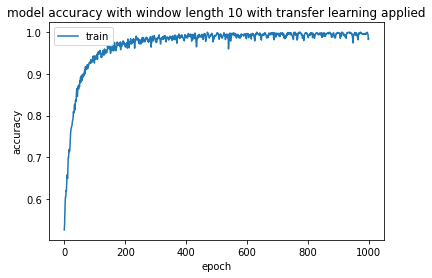

In [320]:
plt.plot(train_accs)
plt.title('model accuracy with window length 10 with transfer learning applied')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

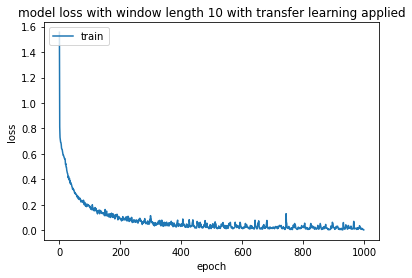

In [333]:
plt.plot(train_losses)
plt.title('model loss with window length 10 with transfer learning applied')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [343]:
base_model.reset_states()
test_results = calc_pos_neg_rate(base_model.evaluate(x=test_generator, verbose=0))

In [344]:
base_model.reset_states()
train_results = calc_pos_neg_rate(base_model.evaluate(x=train_generator, verbose=0))

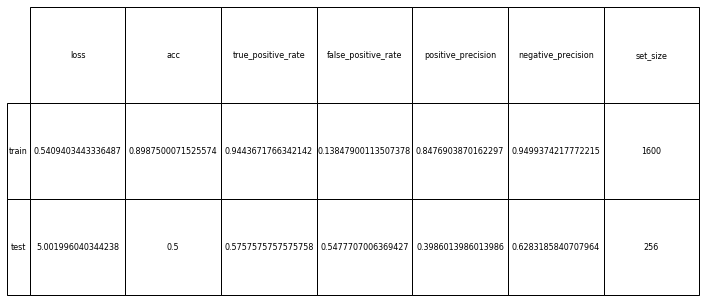

In [345]:
tabular_test_train_results(train_generator, test_generator, train_results, test_results)

Now, let's compare this model with the model trained from scratch.

In [83]:
train_start = pandas.to_datetime('20070101', format='%Y%m%d', errors='ignore')
train_end = pandas.to_datetime('20160719', format='%Y%m%d', errors='ignore')
test_start = pandas.to_datetime('20170101', format='%Y%m%d', errors='ignore')
test_end = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')
epochs = 5000

First of all, let's visualize the new training set again.

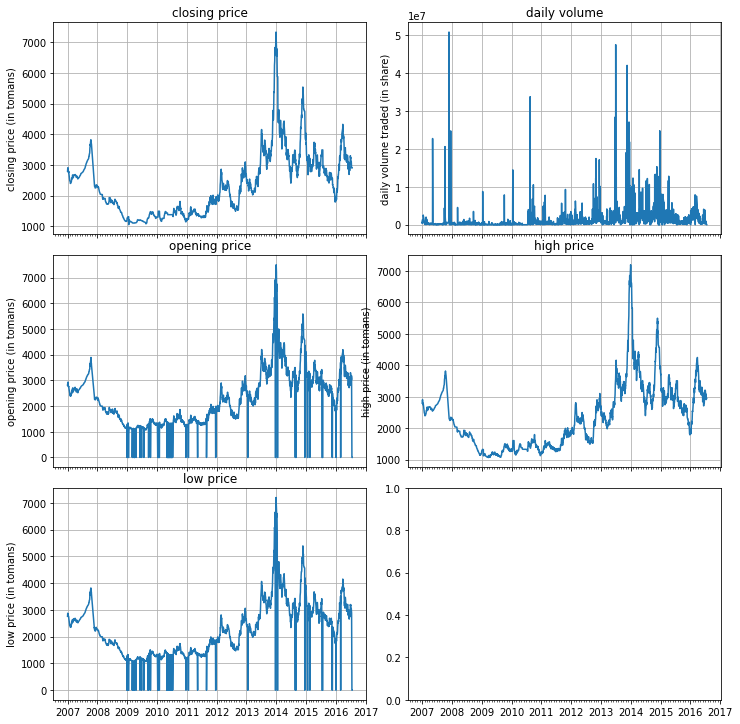

In [79]:
draw_ochlv(data_related_to_second, train_start, train_end)

In [80]:
train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_second_max_trading_days, train_start, train_end, test_start, test_end)

In [97]:
layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
model = build_model(None, optimizer, layers, metrics=metrics)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (32, 64)                  17920     
_________________________________________________________________
dense_32 (Dense)             (32, 32)                  2080      
_________________________________________________________________
dropout_8 (Dropout)          (32, 32)                  0         
_________________________________________________________________
dense_33 (Dense)             (32, 16)                  528       
_________________________________________________________________
batch_normalization_8 (Batch (32, 16)                  64        
_________________________________________________________________
dense_34 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_35 (Dense)             (32, 1)                  

In [98]:
train_accs, train_losses = fit(model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   1.662 seconds , loss : 0.702    accuracy : 0.537    
epoch 2
----------->> Epoch 1/1   0.249 seconds , loss : 0.687    accuracy : 0.550    
epoch 3
----------->> Epoch 1/1   0.237 seconds , loss : 0.686    accuracy : 0.551    
epoch 4
----------->> Epoch 1/1   0.247 seconds , loss : 0.680    accuracy : 0.560    
epoch 5
----------->> Epoch 1/1   0.246 seconds , loss : 0.682    accuracy : 0.556    
epoch 6
----------->> Epoch 1/1   0.220 seconds , loss : 0.680    accuracy : 0.577    
epoch 7
----------->> Epoch 1/1   0.224 seconds , loss : 0.672    accuracy : 0.604    
epoch 8
----------->> Epoch 1/1   0.225 seconds , loss : 0.669    accuracy : 0.594    
epoch 9
----------->> Epoch 1/1   0.213 seconds , loss : 0.674    accuracy : 0.578    
epoch 10
----------->> Epoch 1/1   0.225 seconds , loss : 0.683    accuracy : 0.564    
epoch 11
----------->> Epoch 1/1   0.269 seconds , loss : 0.669    accuracy : 0.588    
epoch 12
----------->> Epoch 1/1   0.235 

----------->> Epoch 1/1   0.297 seconds , loss : 0.546    accuracy : 0.730    
epoch 187
----------->> Epoch 1/1   0.316 seconds , loss : 0.541    accuracy : 0.735    
epoch 188
----------->> Epoch 1/1   0.317 seconds , loss : 0.544    accuracy : 0.738    
epoch 189
----------->> Epoch 1/1   0.336 seconds , loss : 0.545    accuracy : 0.726    
epoch 190
----------->> Epoch 1/1   0.322 seconds , loss : 0.546    accuracy : 0.718    
epoch 191
----------->> Epoch 1/1   0.292 seconds , loss : 0.544    accuracy : 0.733    
epoch 192
----------->> Epoch 1/1   0.233 seconds , loss : 0.541    accuracy : 0.728    
epoch 193
----------->> Epoch 1/1   0.222 seconds , loss : 0.542    accuracy : 0.725    
epoch 194
----------->> Epoch 1/1   0.225 seconds , loss : 0.538    accuracy : 0.733    
epoch 195
----------->> Epoch 1/1   0.244 seconds , loss : 0.549    accuracy : 0.720    
epoch 196
----------->> Epoch 1/1   0.273 seconds , loss : 0.540    accuracy : 0.725    
epoch 197
----------->> Epoch 1

----------->> Epoch 1/1   0.340 seconds , loss : 0.505    accuracy : 0.754    
epoch 371
----------->> Epoch 1/1   0.351 seconds , loss : 0.497    accuracy : 0.753    
epoch 372
----------->> Epoch 1/1   0.347 seconds , loss : 0.505    accuracy : 0.747    
epoch 373
----------->> Epoch 1/1   0.353 seconds , loss : 0.498    accuracy : 0.759    
epoch 374
----------->> Epoch 1/1   0.328 seconds , loss : 0.501    accuracy : 0.754    
epoch 375
----------->> Epoch 1/1   0.307 seconds , loss : 0.501    accuracy : 0.753    
epoch 376
----------->> Epoch 1/1   0.373 seconds , loss : 0.496    accuracy : 0.746    
epoch 377
----------->> Epoch 1/1   0.301 seconds , loss : 0.494    accuracy : 0.750    
epoch 378
----------->> Epoch 1/1   0.299 seconds , loss : 0.493    accuracy : 0.759    
epoch 379
----------->> Epoch 1/1   0.300 seconds , loss : 0.499    accuracy : 0.743    
epoch 380
----------->> Epoch 1/1   0.240 seconds , loss : 0.503    accuracy : 0.754    
epoch 381
----------->> Epoch 1

----------->> Epoch 1/1   0.302 seconds , loss : 0.447    accuracy : 0.783    
epoch 555
----------->> Epoch 1/1   0.298 seconds , loss : 0.447    accuracy : 0.792    
epoch 556
----------->> Epoch 1/1   0.259 seconds , loss : 0.462    accuracy : 0.776    
epoch 557
----------->> Epoch 1/1   0.397 seconds , loss : 0.460    accuracy : 0.776    
epoch 558
----------->> Epoch 1/1   0.389 seconds , loss : 0.455    accuracy : 0.776    
epoch 559
----------->> Epoch 1/1   0.358 seconds , loss : 0.455    accuracy : 0.777    
epoch 560
----------->> Epoch 1/1   0.290 seconds , loss : 0.456    accuracy : 0.774    
epoch 561
----------->> Epoch 1/1   0.300 seconds , loss : 0.453    accuracy : 0.781    
epoch 562
----------->> Epoch 1/1   0.309 seconds , loss : 0.448    accuracy : 0.783    
epoch 563
----------->> Epoch 1/1   0.306 seconds , loss : 0.448    accuracy : 0.780    
epoch 564
----------->> Epoch 1/1   0.333 seconds , loss : 0.453    accuracy : 0.780    
epoch 565
----------->> Epoch 1

----------->> Epoch 1/1   0.263 seconds , loss : 0.399    accuracy : 0.809    
epoch 739
----------->> Epoch 1/1   0.288 seconds , loss : 0.404    accuracy : 0.806    
epoch 740
----------->> Epoch 1/1   0.253 seconds , loss : 0.402    accuracy : 0.801    
epoch 741
----------->> Epoch 1/1   0.248 seconds , loss : 0.392    accuracy : 0.801    
epoch 742
----------->> Epoch 1/1   0.269 seconds , loss : 0.418    accuracy : 0.804    
epoch 743
----------->> Epoch 1/1   0.281 seconds , loss : 0.411    accuracy : 0.800    
epoch 744
----------->> Epoch 1/1   0.259 seconds , loss : 0.400    accuracy : 0.803    
epoch 745
----------->> Epoch 1/1   0.252 seconds , loss : 0.414    accuracy : 0.798    
epoch 746
----------->> Epoch 1/1   0.240 seconds , loss : 0.400    accuracy : 0.805    
epoch 747
----------->> Epoch 1/1   0.246 seconds , loss : 0.396    accuracy : 0.803    
epoch 748
----------->> Epoch 1/1   0.263 seconds , loss : 0.399    accuracy : 0.799    
epoch 749
----------->> Epoch 1

----------->> Epoch 1/1   0.239 seconds , loss : 0.362    accuracy : 0.830    
epoch 923
----------->> Epoch 1/1   0.243 seconds , loss : 0.343    accuracy : 0.835    
epoch 924
----------->> Epoch 1/1   0.234 seconds , loss : 0.328    accuracy : 0.848    
epoch 925
----------->> Epoch 1/1   0.320 seconds , loss : 0.356    accuracy : 0.833    
epoch 926
----------->> Epoch 1/1   0.250 seconds , loss : 0.341    accuracy : 0.837    
epoch 927
----------->> Epoch 1/1   0.244 seconds , loss : 0.341    accuracy : 0.837    
epoch 928
----------->> Epoch 1/1   0.341 seconds , loss : 0.349    accuracy : 0.848    
epoch 929
----------->> Epoch 1/1   0.306 seconds , loss : 0.359    accuracy : 0.824    
epoch 930
----------->> Epoch 1/1   0.284 seconds , loss : 0.352    accuracy : 0.836    
epoch 931
----------->> Epoch 1/1   0.272 seconds , loss : 0.342    accuracy : 0.832    
epoch 932
----------->> Epoch 1/1   0.297 seconds , loss : 0.331    accuracy : 0.849    
epoch 933
----------->> Epoch 1

----------->> Epoch 1/1   0.246 seconds , loss : 0.326    accuracy : 0.846    
epoch 1015
----------->> Epoch 1/1   0.268 seconds , loss : 0.342    accuracy : 0.841    
epoch 1016
----------->> Epoch 1/1   0.263 seconds , loss : 0.322    accuracy : 0.849    
epoch 1017
----------->> Epoch 1/1   0.300 seconds , loss : 0.312    accuracy : 0.855    
epoch 1018
----------->> Epoch 1/1   0.250 seconds , loss : 0.326    accuracy : 0.846    
epoch 1019
----------->> Epoch 1/1   0.259 seconds , loss : 0.324    accuracy : 0.853    
epoch 1020
----------->> Epoch 1/1   0.314 seconds , loss : 0.317    accuracy : 0.853    
epoch 1021
----------->> Epoch 1/1   0.269 seconds , loss : 0.332    accuracy : 0.843    
epoch 1022
----------->> Epoch 1/1   0.256 seconds , loss : 0.325    accuracy : 0.845    
epoch 1023
----------->> Epoch 1/1   0.254 seconds , loss : 0.338    accuracy : 0.841    
epoch 1024
----------->> Epoch 1/1   0.241 seconds , loss : 0.317    accuracy : 0.851    
epoch 1025
----------

----------->> Epoch 1/1   0.257 seconds , loss : 0.284    accuracy : 0.864    
epoch 1197
----------->> Epoch 1/1   0.241 seconds , loss : 0.291    accuracy : 0.868    
epoch 1198
----------->> Epoch 1/1   0.323 seconds , loss : 0.278    accuracy : 0.878    
epoch 1199
----------->> Epoch 1/1   0.312 seconds , loss : 0.287    accuracy : 0.868    
epoch 1200
----------->> Epoch 1/1   0.243 seconds , loss : 0.296    accuracy : 0.871    
epoch 1201
----------->> Epoch 1/1   0.315 seconds , loss : 0.283    accuracy : 0.868    
epoch 1202
----------->> Epoch 1/1   0.236 seconds , loss : 0.294    accuracy : 0.863    
epoch 1203
----------->> Epoch 1/1   0.228 seconds , loss : 0.291    accuracy : 0.862    
epoch 1204
----------->> Epoch 1/1   0.228 seconds , loss : 0.289    accuracy : 0.864    
epoch 1205
----------->> Epoch 1/1   0.309 seconds , loss : 0.272    accuracy : 0.871    
epoch 1206
----------->> Epoch 1/1   0.251 seconds , loss : 0.290    accuracy : 0.868    
epoch 1207
----------

----------->> Epoch 1/1   0.225 seconds , loss : 0.247    accuracy : 0.887    
epoch 1379
----------->> Epoch 1/1   0.280 seconds , loss : 0.253    accuracy : 0.885    
epoch 1380
----------->> Epoch 1/1   0.244 seconds , loss : 0.237    accuracy : 0.893    
epoch 1381
----------->> Epoch 1/1   0.234 seconds , loss : 0.239    accuracy : 0.890    
epoch 1382
----------->> Epoch 1/1   0.281 seconds , loss : 0.249    accuracy : 0.888    
epoch 1383
----------->> Epoch 1/1   0.281 seconds , loss : 0.239    accuracy : 0.892    
epoch 1384
----------->> Epoch 1/1   0.235 seconds , loss : 0.243    accuracy : 0.893    
epoch 1385
----------->> Epoch 1/1   0.232 seconds , loss : 0.259    accuracy : 0.886    
epoch 1386
----------->> Epoch 1/1   0.265 seconds , loss : 0.261    accuracy : 0.889    
epoch 1387
----------->> Epoch 1/1   0.249 seconds , loss : 0.253    accuracy : 0.878    
epoch 1388
----------->> Epoch 1/1   0.229 seconds , loss : 0.252    accuracy : 0.883    
epoch 1389
----------

----------->> Epoch 1/1   0.294 seconds , loss : 0.216    accuracy : 0.907    
epoch 1561
----------->> Epoch 1/1   0.298 seconds , loss : 0.220    accuracy : 0.895    
epoch 1562
----------->> Epoch 1/1   0.274 seconds , loss : 0.219    accuracy : 0.901    
epoch 1563
----------->> Epoch 1/1   0.290 seconds , loss : 0.208    accuracy : 0.909    
epoch 1564
----------->> Epoch 1/1   0.263 seconds , loss : 0.227    accuracy : 0.891    
epoch 1565
----------->> Epoch 1/1   0.274 seconds , loss : 0.228    accuracy : 0.904    
epoch 1566
----------->> Epoch 1/1   0.310 seconds , loss : 0.218    accuracy : 0.907    
epoch 1567
----------->> Epoch 1/1   0.271 seconds , loss : 0.227    accuracy : 0.901    
epoch 1568
----------->> Epoch 1/1   0.315 seconds , loss : 0.209    accuracy : 0.904    
epoch 1569
----------->> Epoch 1/1   0.305 seconds , loss : 0.203    accuracy : 0.909    
epoch 1570
----------->> Epoch 1/1   0.269 seconds , loss : 0.211    accuracy : 0.909    
epoch 1571
----------

----------->> Epoch 1/1   0.247 seconds , loss : 0.194    accuracy : 0.915    
epoch 1743
----------->> Epoch 1/1   0.233 seconds , loss : 0.187    accuracy : 0.916    
epoch 1744
----------->> Epoch 1/1   0.228 seconds , loss : 0.193    accuracy : 0.911    
epoch 1745
----------->> Epoch 1/1   0.250 seconds , loss : 0.185    accuracy : 0.928    
epoch 1746
----------->> Epoch 1/1   0.259 seconds , loss : 0.201    accuracy : 0.914    
epoch 1747
----------->> Epoch 1/1   0.279 seconds , loss : 0.202    accuracy : 0.907    
epoch 1748
----------->> Epoch 1/1   0.271 seconds , loss : 0.187    accuracy : 0.915    
epoch 1749
----------->> Epoch 1/1   0.230 seconds , loss : 0.182    accuracy : 0.917    
epoch 1750
----------->> Epoch 1/1   0.233 seconds , loss : 0.176    accuracy : 0.920    
epoch 1751
----------->> Epoch 1/1   0.228 seconds , loss : 0.190    accuracy : 0.920    
epoch 1752
----------->> Epoch 1/1   0.320 seconds , loss : 0.195    accuracy : 0.916    
epoch 1753
----------

----------->> Epoch 1/1   0.266 seconds , loss : 0.180    accuracy : 0.919    
epoch 1925
----------->> Epoch 1/1   0.324 seconds , loss : 0.186    accuracy : 0.922    
epoch 1926
----------->> Epoch 1/1   0.316 seconds , loss : 0.199    accuracy : 0.914    
epoch 1927
----------->> Epoch 1/1   0.291 seconds , loss : 0.175    accuracy : 0.926    
epoch 1928
----------->> Epoch 1/1   0.306 seconds , loss : 0.164    accuracy : 0.927    
epoch 1929
----------->> Epoch 1/1   0.291 seconds , loss : 0.170    accuracy : 0.925    
epoch 1930
----------->> Epoch 1/1   0.303 seconds , loss : 0.175    accuracy : 0.919    
epoch 1931
----------->> Epoch 1/1   0.291 seconds , loss : 0.162    accuracy : 0.926    
epoch 1932
----------->> Epoch 1/1   0.279 seconds , loss : 0.169    accuracy : 0.927    
epoch 1933
----------->> Epoch 1/1   0.289 seconds , loss : 0.164    accuracy : 0.928    
epoch 1934
----------->> Epoch 1/1   0.358 seconds , loss : 0.189    accuracy : 0.915    
epoch 1935
----------

----------->> Epoch 1/1   0.226 seconds , loss : 0.139    accuracy : 0.938    
epoch 2107
----------->> Epoch 1/1   0.230 seconds , loss : 0.151    accuracy : 0.934    
epoch 2108
----------->> Epoch 1/1   0.226 seconds , loss : 0.152    accuracy : 0.929    
epoch 2109
----------->> Epoch 1/1   0.285 seconds , loss : 0.148    accuracy : 0.930    
epoch 2110
----------->> Epoch 1/1   0.228 seconds , loss : 0.156    accuracy : 0.928    
epoch 2111
----------->> Epoch 1/1   0.272 seconds , loss : 0.146    accuracy : 0.931    
epoch 2112
----------->> Epoch 1/1   0.247 seconds , loss : 0.147    accuracy : 0.938    
epoch 2113
----------->> Epoch 1/1   0.230 seconds , loss : 0.163    accuracy : 0.926    
epoch 2114
----------->> Epoch 1/1   0.226 seconds , loss : 0.162    accuracy : 0.931    
epoch 2115
----------->> Epoch 1/1   0.229 seconds , loss : 0.159    accuracy : 0.929    
epoch 2116
----------->> Epoch 1/1   0.237 seconds , loss : 0.157    accuracy : 0.923    
epoch 2117
----------

----------->> Epoch 1/1   0.340 seconds , loss : 0.152    accuracy : 0.926    
epoch 2289
----------->> Epoch 1/1   0.319 seconds , loss : 0.129    accuracy : 0.942    
epoch 2290
----------->> Epoch 1/1   0.302 seconds , loss : 0.146    accuracy : 0.933    
epoch 2291
----------->> Epoch 1/1   0.318 seconds , loss : 0.131    accuracy : 0.939    
epoch 2292
----------->> Epoch 1/1   0.363 seconds , loss : 0.135    accuracy : 0.938    
epoch 2293
----------->> Epoch 1/1   0.341 seconds , loss : 0.133    accuracy : 0.944    
epoch 2294
----------->> Epoch 1/1   0.321 seconds , loss : 0.144    accuracy : 0.937    
epoch 2295
----------->> Epoch 1/1   0.337 seconds , loss : 0.138    accuracy : 0.937    
epoch 2296
----------->> Epoch 1/1   0.329 seconds , loss : 0.139    accuracy : 0.938    
epoch 2297
----------->> Epoch 1/1   0.329 seconds , loss : 0.149    accuracy : 0.935    
epoch 2298
----------->> Epoch 1/1   0.361 seconds , loss : 0.147    accuracy : 0.934    
epoch 2299
----------

----------->> Epoch 1/1   0.232 seconds , loss : 0.130    accuracy : 0.942    
epoch 2471
----------->> Epoch 1/1   0.263 seconds , loss : 0.125    accuracy : 0.941    
epoch 2472
----------->> Epoch 1/1   0.229 seconds , loss : 0.137    accuracy : 0.936    
epoch 2473
----------->> Epoch 1/1   0.233 seconds , loss : 0.150    accuracy : 0.938    
epoch 2474
----------->> Epoch 1/1   0.226 seconds , loss : 0.121    accuracy : 0.945    
epoch 2475
----------->> Epoch 1/1   0.228 seconds , loss : 0.119    accuracy : 0.942    
epoch 2476
----------->> Epoch 1/1   0.225 seconds , loss : 0.123    accuracy : 0.937    
epoch 2477
----------->> Epoch 1/1   0.227 seconds , loss : 0.118    accuracy : 0.946    
epoch 2478
----------->> Epoch 1/1   0.226 seconds , loss : 0.135    accuracy : 0.936    
epoch 2479
----------->> Epoch 1/1   0.231 seconds , loss : 0.117    accuracy : 0.945    
epoch 2480
----------->> Epoch 1/1   0.225 seconds , loss : 0.131    accuracy : 0.945    
epoch 2481
----------

----------->> Epoch 1/1   0.251 seconds , loss : 0.130    accuracy : 0.943    
epoch 2653
----------->> Epoch 1/1   0.272 seconds , loss : 0.108    accuracy : 0.948    
epoch 2654
----------->> Epoch 1/1   0.268 seconds , loss : 0.113    accuracy : 0.949    
epoch 2655
----------->> Epoch 1/1   0.262 seconds , loss : 0.115    accuracy : 0.945    
epoch 2656
----------->> Epoch 1/1   0.265 seconds , loss : 0.112    accuracy : 0.945    
epoch 2657
----------->> Epoch 1/1   0.262 seconds , loss : 0.099    accuracy : 0.955    
epoch 2658
----------->> Epoch 1/1   0.256 seconds , loss : 0.115    accuracy : 0.944    
epoch 2659
----------->> Epoch 1/1   0.275 seconds , loss : 0.127    accuracy : 0.943    
epoch 2660
----------->> Epoch 1/1   0.272 seconds , loss : 0.155    accuracy : 0.929    
epoch 2661
----------->> Epoch 1/1   0.261 seconds , loss : 0.113    accuracy : 0.949    
epoch 2662
----------->> Epoch 1/1   0.265 seconds , loss : 0.104    accuracy : 0.956    
epoch 2663
----------

----------->> Epoch 1/1   0.227 seconds , loss : 0.124    accuracy : 0.944    
epoch 2835
----------->> Epoch 1/1   0.234 seconds , loss : 0.119    accuracy : 0.945    
epoch 2836
----------->> Epoch 1/1   0.229 seconds , loss : 0.107    accuracy : 0.946    
epoch 2837
----------->> Epoch 1/1   0.233 seconds , loss : 0.103    accuracy : 0.950    
epoch 2838
----------->> Epoch 1/1   0.222 seconds , loss : 0.117    accuracy : 0.942    
epoch 2839
----------->> Epoch 1/1   0.230 seconds , loss : 0.102    accuracy : 0.952    
epoch 2840
----------->> Epoch 1/1   0.231 seconds , loss : 0.107    accuracy : 0.952    
epoch 2841
----------->> Epoch 1/1   0.233 seconds , loss : 0.111    accuracy : 0.946    
epoch 2842
----------->> Epoch 1/1   0.237 seconds , loss : 0.099    accuracy : 0.949    
epoch 2843
----------->> Epoch 1/1   0.232 seconds , loss : 0.153    accuracy : 0.939    
epoch 2844
----------->> Epoch 1/1   0.238 seconds , loss : 0.114    accuracy : 0.946    
epoch 2845
----------

----------->> Epoch 1/1   0.257 seconds , loss : 0.102    accuracy : 0.952    
epoch 3017
----------->> Epoch 1/1   0.268 seconds , loss : 0.085    accuracy : 0.957    
epoch 3018
----------->> Epoch 1/1   0.236 seconds , loss : 0.084    accuracy : 0.959    
epoch 3019
----------->> Epoch 1/1   0.264 seconds , loss : 0.098    accuracy : 0.953    
epoch 3020
----------->> Epoch 1/1   0.230 seconds , loss : 0.099    accuracy : 0.952    
epoch 3021
----------->> Epoch 1/1   0.233 seconds , loss : 0.105    accuracy : 0.955    
epoch 3022
----------->> Epoch 1/1   0.232 seconds , loss : 0.105    accuracy : 0.949    
epoch 3023
----------->> Epoch 1/1   0.227 seconds , loss : 0.092    accuracy : 0.959    
epoch 3024
----------->> Epoch 1/1   0.233 seconds , loss : 0.103    accuracy : 0.952    
epoch 3025
----------->> Epoch 1/1   0.233 seconds , loss : 0.145    accuracy : 0.938    
epoch 3026
----------->> Epoch 1/1   0.232 seconds , loss : 0.130    accuracy : 0.943    
epoch 3027
----------

----------->> Epoch 1/1   0.224 seconds , loss : 0.092    accuracy : 0.958    
epoch 3199
----------->> Epoch 1/1   0.232 seconds , loss : 0.092    accuracy : 0.951    
epoch 3200
----------->> Epoch 1/1   0.228 seconds , loss : 0.105    accuracy : 0.950    
epoch 3201
----------->> Epoch 1/1   0.228 seconds , loss : 0.099    accuracy : 0.947    
epoch 3202
----------->> Epoch 1/1   0.231 seconds , loss : 0.086    accuracy : 0.956    
epoch 3203
----------->> Epoch 1/1   0.227 seconds , loss : 0.086    accuracy : 0.956    
epoch 3204
----------->> Epoch 1/1   0.227 seconds , loss : 0.088    accuracy : 0.956    
epoch 3205
----------->> Epoch 1/1   0.227 seconds , loss : 0.094    accuracy : 0.953    
epoch 3206
----------->> Epoch 1/1   0.229 seconds , loss : 0.109    accuracy : 0.951    
epoch 3207
----------->> Epoch 1/1   0.228 seconds , loss : 0.113    accuracy : 0.945    
epoch 3208
----------->> Epoch 1/1   0.229 seconds , loss : 0.122    accuracy : 0.944    
epoch 3209
----------

----------->> Epoch 1/1   0.227 seconds , loss : 0.133    accuracy : 0.942    
epoch 3381
----------->> Epoch 1/1   0.230 seconds , loss : 0.089    accuracy : 0.962    
epoch 3382
----------->> Epoch 1/1   0.225 seconds , loss : 0.080    accuracy : 0.960    
epoch 3383
----------->> Epoch 1/1   0.230 seconds , loss : 0.093    accuracy : 0.959    
epoch 3384
----------->> Epoch 1/1   0.226 seconds , loss : 0.097    accuracy : 0.963    
epoch 3385
----------->> Epoch 1/1   0.231 seconds , loss : 0.082    accuracy : 0.960    
epoch 3386
----------->> Epoch 1/1   0.224 seconds , loss : 0.093    accuracy : 0.956    
epoch 3387
----------->> Epoch 1/1   0.228 seconds , loss : 0.089    accuracy : 0.955    
epoch 3388
----------->> Epoch 1/1   0.227 seconds , loss : 0.075    accuracy : 0.965    
epoch 3389
----------->> Epoch 1/1   0.232 seconds , loss : 0.087    accuracy : 0.959    
epoch 3390
----------->> Epoch 1/1   0.227 seconds , loss : 0.149    accuracy : 0.938    
epoch 3391
----------

----------->> Epoch 1/1   0.287 seconds , loss : 0.084    accuracy : 0.959    
epoch 3563
----------->> Epoch 1/1   0.264 seconds , loss : 0.079    accuracy : 0.963    
epoch 3564
----------->> Epoch 1/1   0.272 seconds , loss : 0.085    accuracy : 0.956    
epoch 3565
----------->> Epoch 1/1   0.279 seconds , loss : 0.085    accuracy : 0.955    
epoch 3566
----------->> Epoch 1/1   0.284 seconds , loss : 0.084    accuracy : 0.957    
epoch 3567
----------->> Epoch 1/1   0.278 seconds , loss : 0.091    accuracy : 0.952    
epoch 3568
----------->> Epoch 1/1   0.267 seconds , loss : 0.115    accuracy : 0.952    
epoch 3569
----------->> Epoch 1/1   0.269 seconds , loss : 0.106    accuracy : 0.951    
epoch 3570
----------->> Epoch 1/1   0.257 seconds , loss : 0.092    accuracy : 0.956    
epoch 3571
----------->> Epoch 1/1   0.230 seconds , loss : 0.084    accuracy : 0.952    
epoch 3572
----------->> Epoch 1/1   0.246 seconds , loss : 0.074    accuracy : 0.963    
epoch 3573
----------

----------->> Epoch 1/1   0.251 seconds , loss : 0.072    accuracy : 0.968    
epoch 3745
----------->> Epoch 1/1   0.315 seconds , loss : 0.069    accuracy : 0.966    
epoch 3746
----------->> Epoch 1/1   0.293 seconds , loss : 0.061    accuracy : 0.969    
epoch 3747
----------->> Epoch 1/1   0.281 seconds , loss : 0.070    accuracy : 0.966    
epoch 3748
----------->> Epoch 1/1   0.301 seconds , loss : 0.081    accuracy : 0.960    
epoch 3749
----------->> Epoch 1/1   0.279 seconds , loss : 0.096    accuracy : 0.955    
epoch 3750
----------->> Epoch 1/1   0.262 seconds , loss : 0.076    accuracy : 0.958    
epoch 3751
----------->> Epoch 1/1   0.252 seconds , loss : 0.073    accuracy : 0.967    
epoch 3752
----------->> Epoch 1/1   0.250 seconds , loss : 0.069    accuracy : 0.966    
epoch 3753
----------->> Epoch 1/1   0.265 seconds , loss : 0.069    accuracy : 0.964    
epoch 3754
----------->> Epoch 1/1   0.269 seconds , loss : 0.104    accuracy : 0.956    
epoch 3755
----------

----------->> Epoch 1/1   0.224 seconds , loss : 0.094    accuracy : 0.956    
epoch 3927
----------->> Epoch 1/1   0.230 seconds , loss : 0.099    accuracy : 0.960    
epoch 3928
----------->> Epoch 1/1   0.228 seconds , loss : 0.098    accuracy : 0.959    
epoch 3929
----------->> Epoch 1/1   0.313 seconds , loss : 0.082    accuracy : 0.961    
epoch 3930
----------->> Epoch 1/1   0.235 seconds , loss : 0.056    accuracy : 0.969    
epoch 3931
----------->> Epoch 1/1   0.227 seconds , loss : 0.062    accuracy : 0.965    
epoch 3932
----------->> Epoch 1/1   0.235 seconds , loss : 0.049    accuracy : 0.972    
epoch 3933
----------->> Epoch 1/1   0.225 seconds , loss : 0.079    accuracy : 0.957    
epoch 3934
----------->> Epoch 1/1   0.277 seconds , loss : 0.061    accuracy : 0.972    
epoch 3935
----------->> Epoch 1/1   0.241 seconds , loss : 0.062    accuracy : 0.967    
epoch 3936
----------->> Epoch 1/1   0.227 seconds , loss : 0.060    accuracy : 0.964    
epoch 3937
----------

----------->> Epoch 1/1   0.254 seconds , loss : 0.058    accuracy : 0.971    
epoch 4109
----------->> Epoch 1/1   0.258 seconds , loss : 0.071    accuracy : 0.967    
epoch 4110
----------->> Epoch 1/1   0.250 seconds , loss : 0.059    accuracy : 0.968    
epoch 4111
----------->> Epoch 1/1   0.280 seconds , loss : 0.066    accuracy : 0.969    
epoch 4112
----------->> Epoch 1/1   0.275 seconds , loss : 0.060    accuracy : 0.967    
epoch 4113
----------->> Epoch 1/1   0.292 seconds , loss : 0.062    accuracy : 0.969    
epoch 4114
----------->> Epoch 1/1   0.350 seconds , loss : 0.058    accuracy : 0.971    
epoch 4115
----------->> Epoch 1/1   0.298 seconds , loss : 0.119    accuracy : 0.957    
epoch 4116
----------->> Epoch 1/1   0.258 seconds , loss : 0.090    accuracy : 0.955    
epoch 4117
----------->> Epoch 1/1   0.262 seconds , loss : 0.074    accuracy : 0.964    
epoch 4118
----------->> Epoch 1/1   0.258 seconds , loss : 0.069    accuracy : 0.963    
epoch 4119
----------

----------->> Epoch 1/1   0.234 seconds , loss : 0.063    accuracy : 0.972    
epoch 4291
----------->> Epoch 1/1   0.235 seconds , loss : 0.060    accuracy : 0.971    
epoch 4292
----------->> Epoch 1/1   0.240 seconds , loss : 0.057    accuracy : 0.970    
epoch 4293
----------->> Epoch 1/1   0.241 seconds , loss : 0.058    accuracy : 0.968    
epoch 4294
----------->> Epoch 1/1   0.230 seconds , loss : 0.123    accuracy : 0.952    
epoch 4295
----------->> Epoch 1/1   0.238 seconds , loss : 0.082    accuracy : 0.961    
epoch 4296
----------->> Epoch 1/1   0.267 seconds , loss : 0.065    accuracy : 0.968    
epoch 4297
----------->> Epoch 1/1   0.252 seconds , loss : 0.063    accuracy : 0.968    
epoch 4298
----------->> Epoch 1/1   0.283 seconds , loss : 0.054    accuracy : 0.971    
epoch 4299
----------->> Epoch 1/1   0.262 seconds , loss : 0.052    accuracy : 0.973    
epoch 4300
----------->> Epoch 1/1   0.262 seconds , loss : 0.053    accuracy : 0.973    
epoch 4301
----------

----------->> Epoch 1/1   0.235 seconds , loss : 0.043    accuracy : 0.979    
epoch 4473
----------->> Epoch 1/1   0.228 seconds , loss : 0.045    accuracy : 0.976    
epoch 4474
----------->> Epoch 1/1   0.246 seconds , loss : 0.049    accuracy : 0.973    
epoch 4475
----------->> Epoch 1/1   0.241 seconds , loss : 0.056    accuracy : 0.971    
epoch 4476
----------->> Epoch 1/1   0.233 seconds , loss : 0.055    accuracy : 0.972    
epoch 4477
----------->> Epoch 1/1   0.224 seconds , loss : 0.053    accuracy : 0.974    
epoch 4478
----------->> Epoch 1/1   0.228 seconds , loss : 0.057    accuracy : 0.969    
epoch 4479
----------->> Epoch 1/1   0.228 seconds , loss : 0.078    accuracy : 0.967    
epoch 4480
----------->> Epoch 1/1   0.234 seconds , loss : 0.076    accuracy : 0.959    
epoch 4481
----------->> Epoch 1/1   0.231 seconds , loss : 0.064    accuracy : 0.970    
epoch 4482
----------->> Epoch 1/1   0.233 seconds , loss : 0.059    accuracy : 0.970    
epoch 4483
----------

----------->> Epoch 1/1   0.282 seconds , loss : 0.048    accuracy : 0.978    
epoch 4655
----------->> Epoch 1/1   0.234 seconds , loss : 0.055    accuracy : 0.974    
epoch 4656
----------->> Epoch 1/1   0.272 seconds , loss : 0.047    accuracy : 0.976    
epoch 4657
----------->> Epoch 1/1   0.234 seconds , loss : 0.046    accuracy : 0.972    
epoch 4658
----------->> Epoch 1/1   0.276 seconds , loss : 0.049    accuracy : 0.977    
epoch 4659
----------->> Epoch 1/1   0.231 seconds , loss : 0.047    accuracy : 0.975    
epoch 4660
----------->> Epoch 1/1   0.248 seconds , loss : 0.042    accuracy : 0.981    
epoch 4661
----------->> Epoch 1/1   0.260 seconds , loss : 0.047    accuracy : 0.977    
epoch 4662
----------->> Epoch 1/1   0.226 seconds , loss : 0.048    accuracy : 0.977    
epoch 4663
----------->> Epoch 1/1   0.229 seconds , loss : 0.055    accuracy : 0.974    
epoch 4664
----------->> Epoch 1/1   0.235 seconds , loss : 0.052    accuracy : 0.971    
epoch 4665
----------

----------->> Epoch 1/1   0.242 seconds , loss : 0.050    accuracy : 0.970    
epoch 4837
----------->> Epoch 1/1   0.229 seconds , loss : 0.053    accuracy : 0.969    
epoch 4838
----------->> Epoch 1/1   0.251 seconds , loss : 0.050    accuracy : 0.974    
epoch 4839
----------->> Epoch 1/1   0.244 seconds , loss : 0.039    accuracy : 0.976    
epoch 4840
----------->> Epoch 1/1   0.251 seconds , loss : 0.042    accuracy : 0.980    
epoch 4841
----------->> Epoch 1/1   0.241 seconds , loss : 0.041    accuracy : 0.983    
epoch 4842
----------->> Epoch 1/1   0.227 seconds , loss : 0.049    accuracy : 0.977    
epoch 4843
----------->> Epoch 1/1   0.229 seconds , loss : 0.052    accuracy : 0.978    
epoch 4844
----------->> Epoch 1/1   0.248 seconds , loss : 0.052    accuracy : 0.970    
epoch 4845
----------->> Epoch 1/1   0.246 seconds , loss : 0.044    accuracy : 0.977    
epoch 4846
----------->> Epoch 1/1   0.249 seconds , loss : 0.053    accuracy : 0.971    
epoch 4847
----------

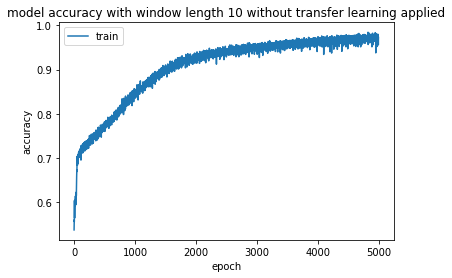

In [99]:
plt.plot(train_accs)
plt.title('model accuracy with window length 10 without transfer learning applied')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

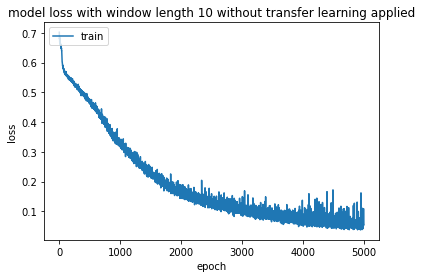

In [100]:
plt.plot(train_losses)
plt.title('model loss with window length 10 without transfer learning applied')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [101]:
base_model.reset_states()
test_results = calc_pos_neg_rate(base_model.evaluate(x=test_generator, verbose=0))

In [102]:
base_model.reset_states()
train_results = calc_pos_neg_rate(base_model.evaluate(x=train_generator, verbose=0))

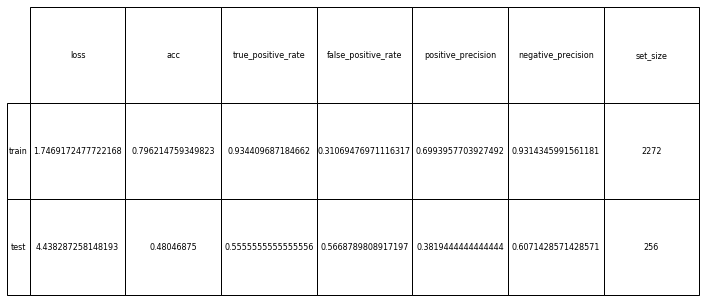

In [103]:
tabular_test_train_results(train_generator, test_generator, train_results, test_results)